# clean notebook for generating scripts, submitting scripts, and plotting results

## helper funcs

In [3]:
# train/test csv file read
# automated multi-round submission & eval??? averaging??

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil
import subprocess
from pathlib import Path
from itertools import product

# wulab = '../../../wulab_shared/jessica_code/automatic_vehicular_control/automatic_vehicular_control'
# wulab = '~/wulab_shared/jessica_code/automatic_vehicular_control/automatic_vehicular_control'

def create_file_with_contents(file_path, contents):
    try:
        with open(file_path, 'w') as file:
            file.write(contents)
    except Exception as e:
        print(f"Error: {e}")
        
def submit_job(script_path):
    output = subprocess.run(f'LLsub {script_path}', shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
    return output.stdout, output.stderr

def verify_execution(log_path):
    if not os.path.exists(log_path):
        return False
    with open(log_path) as file:
        last_line = ''
        for line in file:
            last_line = line
        return ('job done!' in last_line)
    
def verify_multiple_execution(log_paths, print_success=False):
    failed = [x for x in log_paths if not verify_execution(x)]
    success = [x for x in log_paths if verify_execution(x)]
    if failed:
        print(f'failed scripts: {failed}')
    if print_success:
        print(f'successful scripts: {success}')
    else:
        print('all scripts success!')
        
def prep_additional_training(source_dir, target_dir, source_e):
    # copy source model-e.pth into target model-0.pth, copy related part of train_results.csv
    Path(f'{target_dir}').mkdir(parents=True, exist_ok=True)
    os.system(f'(head -{source_e+2} {source_dir}/train_results.csv) >> {target_dir}/train_results.csv')
    # copy relevant model *.pth file
    Path(f'{target_dir}/models').mkdir(parents=True, exist_ok=True)
    shutil.copy(f'{source_dir}/models/model-{source_e}.pth', f'{target_dir}/models/model-0.pth')

def plot_training(exp_dir, columns, hp_values, hp_name, suptitle, run_nums, mean=False, xlen=150, transformations={'drac_mean': lambda x: -1*x}):
    fig, axs = plt.subplots(2, int(len(hp_values)//2+1), figsize=(18, 8),  sharex=True, sharey=True)
    axs_flat = axs.flatten()

    cmap_plasma = plt.cm.get_cmap('plasma')
    num_colors = len(columns)+1 if mean else (len(columns)+2)*len(run_nums) # fix colorspace!
    colors = [cmap_plasma(i / (num_colors - 1)) for i in range(num_colors)]
    
    try:

        for h, (hp) in enumerate(hp_values):
            plot_dict = {col: [] for col in columns}
            for i in run_nums:
                cur_dir = f'{exp_dir}/{hp}_{i}'
                train_csv = f'{cur_dir}/train_results.csv'
                if os.path.exists(train_csv):
                
                    train_df = pd.read_csv(train_csv)
                    for col in columns:
                        plot_dict[col] += [train_df[col]]
        
            for col, y in plot_dict.items():
                max_length = max(len(_) for _ in y)
                y = [np.pad(_, (0, max_length - len(_)), constant_values=np.nan) for _ in y]
                y = np.vstack(y)
                plot_dict[col] = np.nanmean(y, axis=0) if mean else y

            ax = axs_flat[h]
            ax.set_title(f'{hp_name}={hp}')

            if mean:
                xlen=min([y.shape[0] for _, y in plot_dict.items()] + [xlen+1])
                x=np.arange(xlen)
                for c, (col, y) in enumerate(plot_dict.items()): 
                    ax.plot(x, y[:xlen], color=colors[c], label=f'mean {col} over 3 runs')
            else:
                xlen=min([y.shape[1] for _, y in plot_dict.items()] + [xlen+1]) # bug: will only graph up to xlen of first hyperparameter
                x=np.arange(xlen)
                for c, (col, y) in enumerate(plot_dict.items()): 
                    if col in transformations:
                        y = transformations[col](y)
                    for row_i in range(y.shape[0]): 
                        # fix colorspace!
                        ax.plot(x, y[row_i][:xlen], color=colors[(c+2)*(row_i+1)], label=f'{col} run {row_i}')  # bug: legend isn't accurate to run number, e.g. if run 0 not there, 1 will be 0

        fig.text(0.5, 0.04, 'episodes', ha='center', va='center') # xlabel
        fig.text(0.08, 0.5, 'reward term values', ha='center', va='center', rotation='vertical') # ylabel
        plt.suptitle(suptitle)
        axs[-1, -1].axis('off')
        legend_handles, legend_labels = axs_flat[4].get_legend_handles_labels()
        plt.legend(handles=legend_handles, labels=legend_labels, loc='lower right', bbox_to_anchor=(1.5, 0))
        # plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(e)
        print(i, hp)

    
def plot_avg_eval(exp_dir, e, beta_values, run_nums, title, csv_default=True): 
    ssms, speeds, labels = [], [], []
    for beta in beta_values:
        cur_ssms, cur_speeds = [], []
        for i in run_nums:
            cur_dir = f'{exp_dir}/{beta}_{i}'
            eval_csv = f'{cur_dir}/eval_e{e}.csv' if csv_default else f'{cur_dir}/eval_e{e}_on{beta}.csv'
            if os.path.exists(eval_csv):
                try:
                    eval_df = pd.read_csv(eval_csv)
                    cur_ssms += [np.mean(eval_df['ssm_mean'])]
                    cur_speeds += [np.mean(eval_df['speed_reward_mean'])]
                    
                except:
                    print(i, beta)

        ssms += [np.mean(cur_ssms)]
        speeds += [np.mean(cur_speeds)]
        labels += [f'{beta} Scratch avg']

    print(ssms, speeds)

    plt.scatter(ssms, speeds, c=np.arange(len(ssms)), cmap='plasma')
    for (li, xi, yi) in zip(labels, ssms, speeds):
        plt.annotate(f'{li}', (xi, yi), textcoords="offset points", xytext=(2,5),
                     ha='center', fontsize=8)

    plt.title(title)
    plt.xlabel('ssm')
    plt.ylabel('speed')
    plt.tight_layout()
    plt.show()
    
    return ssms, speeds, labels
    
    
def plot_best_eval(exp_dir, e, beta_values, run_nums, title, beta_to_i, csv_default=True): 
    ssms, speeds, labels = [], [], []
    for beta in beta_values:
        i = beta_to_i[beta]
        cur_dir = f'{exp_dir}/{beta}_{i}'
        eval_csv = f'{cur_dir}/eval_e{e}.csv' if csv_default else f'{cur_dir}/eval_e{e}_on{beta}.csv'
        if os.path.exists(eval_csv):
            try:
                eval_df = pd.read_csv(eval_csv)
                
                ssms += [np.mean(eval_df['ssm_mean'])]
                speeds += [np.mean(eval_df['speed_reward_mean'])]
                labels += [f'{beta} Scratch best']
            except:
                print(i, beta)

    print(ssms, speeds)

    plt.scatter(ssms, speeds, c=np.arange(len(ssms)), cmap='plasma')
    for (li, xi, yi) in zip(labels, ssms, speeds):
        plt.annotate(f'{li}', (xi, yi), textcoords="offset points", xytext=(2,5),
                     ha='center', fontsize=8)

    plt.title(title)
    plt.xlabel('ssm')
    plt.ylabel('speed')
    plt.tight_layout()
    plt.show()    
    
    return ssms, speeds, labels

def plot_all_eval(exp_dir, e, beta_values, run_nums, title, csv_default=True, show=False): 
    ssms, speeds, labels = [], [], []
    for beta in beta_values:
        for i in run_nums:
            cur_dir = f'{exp_dir}/{beta}_{i}'
            eval_csv = f'{cur_dir}/eval_e{e}.csv' if csv_default else f'{cur_dir}/eval_e{e}_on{beta}.csv'
            if os.path.exists(eval_csv):
                try:
                    eval_df = pd.read_csv(eval_csv)

                    ssms += [np.mean(eval_df['ssm_mean'])]
                    speeds += [np.mean(eval_df['speed_reward_mean'])]
                    labels += [f'{beta} Scratch']
                except:
                    print(i, beta)

    # print(ssms, speeds, labels)

    if show:
        plt.scatter(ssms, speeds, c=np.arange(len(ssms)), cmap='plasma')
        for (li, xi, yi) in zip(labels, ssms, speeds):
            plt.annotate(f'{li}', (xi, yi), textcoords="offset points", xytext=(2,5),
                         ha='center', fontsize=8)

        plt.title(title)
        plt.xlabel('ssm')
        plt.ylabel('speed')
        plt.tight_layout()
        plt.show()    
    
    return ssms, speeds, labels
                
def get_best_run(exp_dir, e, beta_values, num_runs): # for each beta, return run with highest average total reward at eval
    best_i_per_beta = dict()
    for beta in beta_values:
        rewards = []
        for i in run_nums:
            cur_dir = f'{exp_dir}/{beta}_{i}'
            eval_csv = f'{cur_dir}/eval_e{e}.csv'
            try:
                eval_df = pd.read_csv(eval_csv)
                rewards += [(np.mean(eval_df['reward_mean']), i)]
            except:
                print(i, beta)
        best_i_per_beta[beta] = max(rewards, key=lambda x: x[0])[1]
    return best_i_per_beta

def pareto_frontier(xs, ys, labels):
    pareto_points = []
    for point in zip(xs, ys, labels):
        is_pareto = True
        for other_point in zip(xs, ys, labels):
            if other_point[0] >= point[0] and other_point[1] >= point[1] and other_point != point:
                is_pareto = False
                continue
        if is_pareto:
            pareto_points += [point]
    pareto_points = sorted(pareto_points, key=lambda x: x[0])
    return list(zip(*pareto_points))

## single ring

#### helper funcs

In [11]:
single_folder = 'pareto/single_ring'
single_num_runs = 3 #number of training runs for each experiment

def single_ring_train_script_text(
        output_log='output-%j.log',
        run_dir='.', 
        worker_kwargs=[{'circumference': 250}], 
        n_workers=45,
        n_rollouts_per_step=45,
        warmup_steps=2000,
        skip_stat_steps=5000,
        horizon=5000,
        global_reward=True,
        n_steps=50,
        alg='TRPO',
        use_critic=False,
        gamma=0.9995,
        beta=0,
        scale_ttc=1,
        scale_drac=1,
        seed_np=False,
        seed_torch=False,
        residual_transfer=False,
        mrtl=False,
        handcraft=False,
        step_save=False,
    
        lr=1e-4,
        wb=False,
        tb=False
    ): # format into script runnable on supercloud
    script_text = (f'''#!/bin/sh

#SBATCH -o {output_log}
#SBATCH --time=72:00:00          # total run time limit (HH:MM:SS)
#SBATCH -c {n_workers}

'''
f'''python $F/ring.py {run_dir} "worker_kwargs={worker_kwargs}" "n_workers={n_workers}" "n_rollouts_per_step={n_rollouts_per_step}" "warmup_steps={warmup_steps}"'''
f''' "skip_stat_steps={skip_stat_steps}" "horizon={horizon}" "global_reward={global_reward}" "n_steps={n_steps}" "alg='{alg}'" "use_critic={use_critic}" "gamma={gamma}" "beta={beta}"'''
f''' "scale_ttc={scale_ttc}" "scale_drac={scale_drac}" "seed_np={seed_np}" "seed_torch={seed_torch}" "residual_transfer={residual_transfer}" "mrtl={mrtl}" "handcraft={handcraft}" "step_save={step_save}" "lr={lr}" "wb={wb}" "tb={tb}" '''
                  )
    return script_text

def single_ring_eval_script_text(
        output_log='output-%j.log',
        run_dir='.', 
        e='50',
        warmup_steps=2000,
        skip_stat_steps=5000,
        horizon=1000,
        circumference=250,
        n_steps=10,
        n_rollouts_per_step=1, 
        skip_vehicle_info_stat_steps=False,
        full_rollout_only=True,
        result_save='evaluations/eval.csv',
        vehicle_info_save='trajectories/trajectory.npz',
        save_agent=True,
        beta=0,
        scale_ttc=1,
        scale_drac=1,
        residual_transfer=False,
        mrtl=False,
    ): # format into script runnable on supercloud
    script_text = (f'''#!/bin/sh

#SBATCH -o {output_log}
#SBATCH --time=72:00:00          # total run time limit (HH:MM:SS)
#SBATCH -c 40

'''
f'''python $F/ring.py {run_dir} "e={e}" "warmup_steps={warmup_steps}" "skip_stat_steps={skip_stat_steps}" "horizon={horizon}" "circumference={circumference}" "n_steps={n_steps}"'''
f''' "n_rollouts_per_step={n_rollouts_per_step}" "skip_vehicle_info_stat_steps={skip_vehicle_info_stat_steps}" "full_rollout_only={full_rollout_only}"'''
f''' "result_save={result_save}" "vehicle_info_save={vehicle_info_save}" "save_agent={save_agent}"'''
f''' "beta={beta}" "scale_ttc={scale_ttc}" "scale_drac={scale_drac}" "residual_transfer={residual_transfer}" "mrtl={mrtl}"'''
                  )
    return script_text

def single_get_best_source_per_target(i_list, source_list, target_list, exp_dir, e=290): # returns {t: best s}
    best = dict()
    
    for t in target_list:
        avg_performance_per_source = dict() # s -> (avg reward, number runs)
        for i in i_list:
            for s in source_list:
                try:
                    source_dir = f'{single_scratch_exp_dir}/{s}_{source_best_runs_per_beta[s]}'
                    target_dir = f'{exp_dir}/{s}_{source_best_runs_per_beta[s]}_e{source_e}_to_{t}_{i}'

                    eval_df = pd.read_csv(f'{target_dir}/eval_e{e}.csv')
                    avg_reward = np.mean(eval_df['reward_mean'])

                    if s in avg_performance_per_source:
                        perf, num = avg_performance_per_source[s] 
                        avg_performance_per_source[s] = ((perf*num+avg_reward)/(num+1), num+1)
                    else:
                        avg_performance_per_source[s] = (avg_reward, 1)
                except Exception as exc:
                    print(i, s, t)
                    print(exc)
        best_source = max(avg_performance_per_source, key=lambda x: avg_performance_per_source[x][0])
        best[t] = best_source
    return best

def plot_best_eval_additional_training_methods(exp_dir, target_values, title, best_source_per_target, label_method, i_range=[0,1], e=290, source_e=145): 
    ssms, speeds, labels = [], [], []
    for t in target_values:
        s = best_source_per_target[t]
        cur_ssms, cur_speeds = [], []
        for i in i_range:
            target_dir = f'{exp_dir}/{s}_{source_best_runs_per_beta[s]}_e{source_e}_to_{t}_{i}'
            eval_csv = f'{target_dir}/eval_e{e}.csv'
            if os.path.exists(eval_csv):
                try:
                    eval_df = pd.read_csv(eval_csv)

                    cur_ssms += [np.mean(eval_df['ssm_mean'])]
                    cur_speeds += [np.mean(eval_df['speed_reward_mean'])]
                    
                except:
                    print(s, t)
        
        ssms += [sum(cur_ssms)/len(cur_ssms)]        
        speeds += [sum(cur_speeds)/len(cur_speeds)]   
        labels += [f'{t} {label_method}']

    # print(ssms, speeds, labels)

    plt.scatter(ssms, speeds, c=np.arange(len(ssms)), cmap='plasma')
    for (li, xi, yi) in zip(labels, ssms, speeds):
        plt.annotate(f'{li}', (xi, yi), textcoords="offset points", xytext=(2,5),
                     ha='center', fontsize=8)

    plt.title(title)
    plt.xlabel('ssm')
    plt.ylabel('speed')
    plt.tight_layout()
    plt.show()
    
    return ssms, speeds, labels


def get_all_eval_additional_training_methods(exp_dir, target_values, source_values, label_method, i_range=[0,1], e=290, source_e=145): 
    ssms, speeds, labels = [], [], []
    for t in target_values:
        for s in source_values:
            for i in i_range:
                # cur_ssms, cur_speeds  = [], []
                target_dir = f'{exp_dir}/{s}_{source_best_runs_per_beta[s]}_e{source_e}_to_{t}_{i}'
                eval_csv = f'{target_dir}/eval_e{e}.csv'
                if os.path.exists(eval_csv):
                    try:
                        eval_df = pd.read_csv(eval_csv)

                        ssms += [np.mean(eval_df['ssm_mean'])]
                        speeds += [np.mean(eval_df['speed_reward_mean'])]
                        # labels += [f'{s} to {t} run {i} {label_method}']
                        labels += [f'({s},{t},{i},{label_method})']

                    except:
                        print(s, t)
    
    return ssms, speeds, labels


##### find seed

In [6]:
import random
single_ring_seed_dir = f'{single_folder}/seeding'
# single_ring_seed_dir = f'{single_folder}/seeding1'
Path(f'{single_ring_seed_dir}').mkdir(parents=True, exist_ok=True)

def seed_single(torch_seeds, np_seeds):
    output_logs = []
    for i in range(8):
        torch_seed, np_seed = torch_seeds[i], np_seeds[i]
        cur_dir = f'{single_ring_seed_dir}/beta1.0_SSM1_torch{torch_seed}_np{np_seed}'
        Path(f'{cur_dir}').mkdir(parents=True, exist_ok=True)
        output_log_name = f'{cur_dir}/train.log'
        train_script_text = single_ring_train_script_text(output_log=output_log_name, run_dir=cur_dir, beta=1.0, n_steps=400, seed_torch=torch_seed, seed_np=np_seed)
        train_script_path = f'{cur_dir}/traintorch{torch_seed}_np{np_seed}_beta1.0_SSM1_.sh'
        create_file_with_contents(train_script_path, train_script_text)
        out, err = submit_job(train_script_path)
        output_logs += [output_log_name]
    return output_logs

In [4]:
random_torch_seeds = [random.randint(0, 1000000) for _ in range(8)]

seed_seq = np.random.SeedSequence()
random_np_seeds = seed_seq.generate_state(8)

print(random_torch_seeds)
print(list(random_np_seeds))

outputs = seed_single(random_torch_seeds, random_np_seeds)
print(outputs)

[240601, 447296, 117660, 889594, 656520, 404927, 706208, 332566]
[3021712657, 2132428247, 619204545, 2674239850, 2256595450, 253931823, 204545208, 88212365]
['pareto/single_ring/seeding/beta0.5_SSM1_torch240601_np3021712657/train.log', 'pareto/single_ring/seeding/beta0.5_SSM1_torch447296_np2132428247/train.log', 'pareto/single_ring/seeding/beta0.5_SSM1_torch117660_np619204545/train.log', 'pareto/single_ring/seeding/beta0.5_SSM1_torch889594_np2674239850/train.log', 'pareto/single_ring/seeding/beta0.5_SSM1_torch656520_np2256595450/train.log', 'pareto/single_ring/seeding/beta0.5_SSM1_torch404927_np253931823/train.log', 'pareto/single_ring/seeding/beta0.5_SSM1_torch706208_np204545208/train.log', 'pareto/single_ring/seeding/beta0.5_SSM1_torch332566_np88212365/train.log']


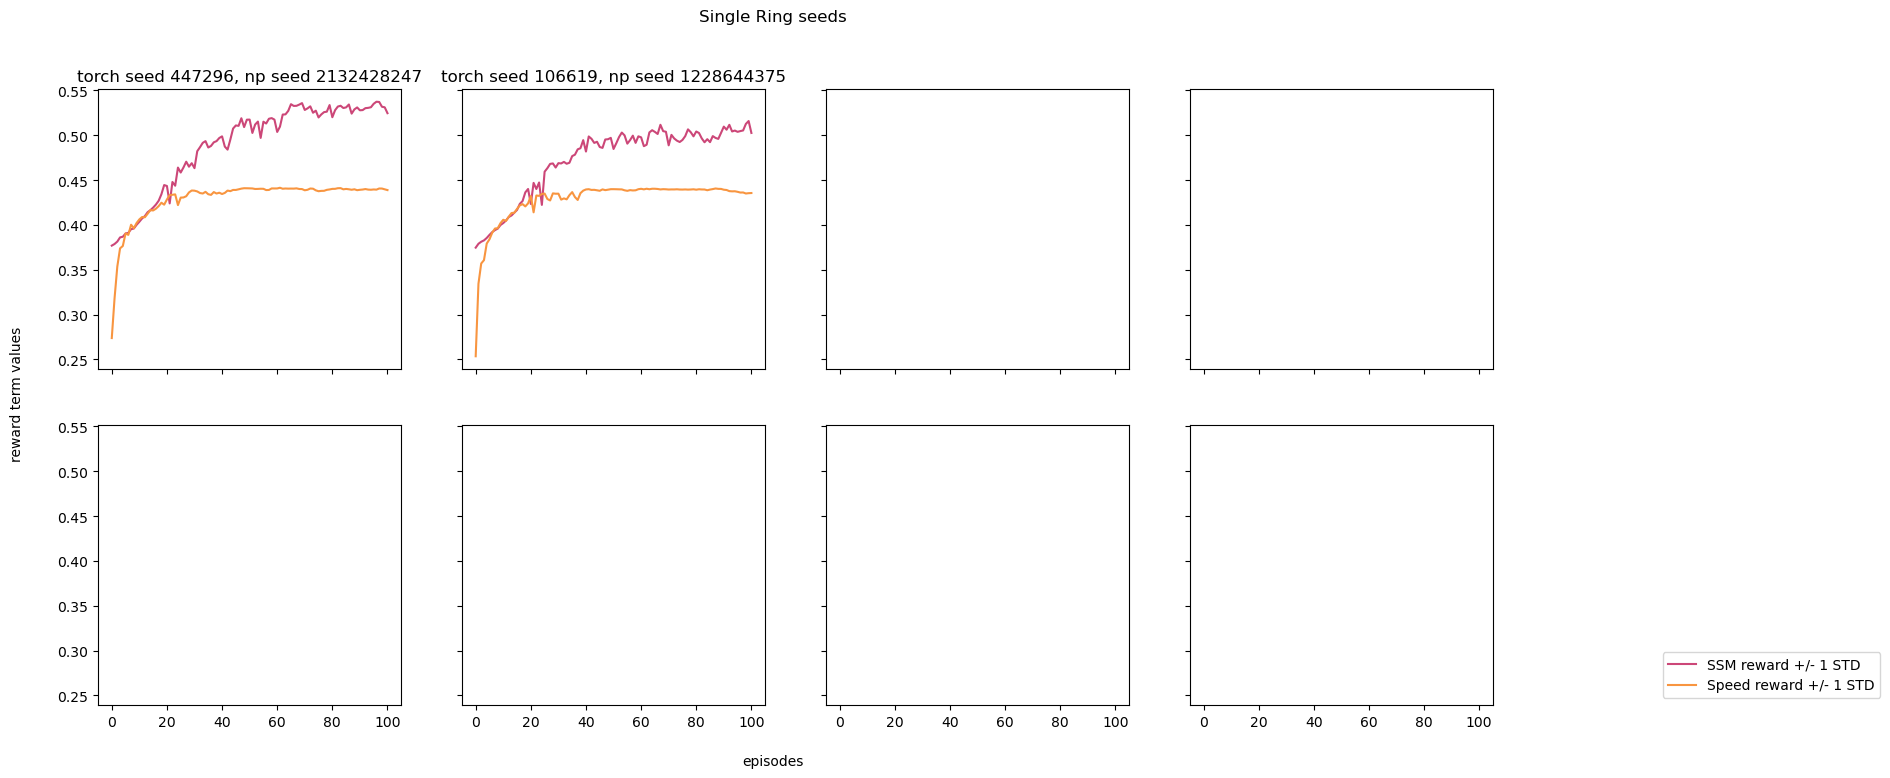

In [9]:
# train progress: plot rewards for each seed

fig, axs = plt.subplots(2, 4, figsize=(18, 8),  sharex=True, sharey=True)
axs_flat = axs.flatten()

cmap_plasma = plt.cm.get_cmap('plasma')
colors = [cmap_plasma(i / (5 - 1)) for i in range(5)] # split plasma into 12 colors

random_torch_seeds=[240601, 447296, 117660, 889594, 656520, 404927, 706208, 332566]
random_np_seeds=[3021712657, 2132428247, 619204545, 2674239850, 2256595450, 253931823, 204545208, 88212365]

# seeding1_random_torch_seeds=[106619, 14606, 203490, 393074, 423228, 60365, 731208, 778321]
# seeding1_random_np_seeds=[1228644375 , 4191455537, 488264084, 3451991332 , 4202972154, 3618751158 , 2140084723, 2109944452]

# seeds_to_test=[(f'{single_folder}/seeding', 447296, 2132428247), (f'{single_folder}/seeding1', 106619, 1228644375)]

for i in range(8):
    torch_seed, np_seed = random_torch_seeds[i], random_np_seeds[i]
    torch_seed, np_seed = seeding1_random_torch_seeds[i], seeding1_random_np_seeds[i]
    cur_dir = f'{single_ring_seed_dir}/beta0.5_SSM1_torch{torch_seed}_np{np_seed}'
# for i, (parent, torch_seed, np_seed) in enumerate(seeds_to_test):
#     cur_dir = f'{parent}/beta0.5_SSM1_torch{torch_seed}_np{np_seed}'
    train_csv = f'{cur_dir}/train_results.csv'
    if os.path.exists(train_csv):
        train_df = pd.read_csv(train_csv)
        ttc_y, ttc_std = train_df['ttc_mean'], train_df['ttc_std']
        speed_y, speed_std = train_df['speed_reward_mean'], train_df['speed_reward_std']
        drac_y, drac_std = -train_df['drac_mean'], train_df['drac_std']
        ssm_y, ssm_std = train_df['ssm_mean'], train_df['ssm_std']

        x = np.arange(len(speed_y))
    
        # pet_y = train_df['pet_mean']
        # ax.plot(x, pet_y, color='orange', label='pet')

        ax = axs_flat[i]
        ax.set_title(f'torch seed {torch_seed}, np seed {np_seed}')
        # ax.plot(x, ttc_y, color=colors[0], label=f'TTC run{i}')
        # ax.fill_between(x, ttc_y-ttc_std, ttc_y+ttc_std, color='red', alpha=0.2)
        # ax.plot(x, drac_y, color=colors[1], label=f'-1 * DRAC run{i}')
        # ax.fill_between(x, drac_y-drac_std, drac_y+drac_std, color='purple', alpha=0.2)
        ax.plot(x, ssm_y, color=colors[2], label=f'SSM reward +/- 1 STD')
        # ax.fill_between(x, ssm_y-ssm_std, ssm_y+ssm_std, color='red', alpha=0.2)
        ax.plot(x, speed_y, color=colors[3], label=f'Speed reward +/- 1 STD')
        # ax.fill_between(x, speed_y-speed_std, speed_y+speed_std, color='blue', alpha=0.2)

fig.text(0.5, 0.04, 'episodes', ha='center', va='center') # xlabel
fig.text(0.08, 0.5, 'reward term values', ha='center', va='center', rotation='vertical') # ylabel

plt.suptitle('Single Ring seeds')
legend_handles, legend_labels = axs_flat[0].get_legend_handles_labels()
plt.legend(handles=legend_handles, labels=legend_labels, loc='lower right', bbox_to_anchor=(2.3, 0))
# plt.tight_layout()
plt.show()

# seeding1_2runs_random_torch_seeds = [163294, 2230, 294334, 472352, 719900, 768924, 78194, 789334]
# seeding1_2runs_random_np_seeds=[1823195711, 1406418984, 3695343398, 3440784316, 932307645, 410281240, 4140499927, 3809329783]
# runs=[0, 1]


# for i in range(8):
#     for j in runs:
#         # torch_seed, np_seed = random_torch_seeds[i], random_np_seeds[i]
#         torch_seed, np_seed = seeding1_2runs_random_torch_seeds[i], seeding1_2runs_random_np_seeds[i]
#         cur_dir = f'{single_ring_seed_dir}/beta0.5_SSM1_torch{torch_seed}_np{np_seed}_{j}'
#         train_csv = f'{cur_dir}/train_results.csv'
#         if os.path.exists(train_csv):
#             train_df = pd.read_csv(train_csv)
#             ttc_y, ttc_std = train_df['ttc_mean'], train_df['ttc_std']
#             speed_y, speed_std = train_df['speed_reward_mean'], train_df['speed_reward_std']
#             drac_y, drac_std = -train_df['drac_mean'], train_df['drac_std']
#             ssm_y, ssm_std = train_df['ssm_mean'], train_df['ssm_std']

#             x = np.arange(len(speed_y))

#             # pet_y = train_df['pet_mean']
#             # ax.plot(x, pet_y, color='orange', label='pet')

#             ax = axs_flat[i]
#             ax.set_title(f'torch seed {torch_seed}, np seed {np_seed}')
#             # ax.plot(x, ttc_y, color=colors[0], label=f'TTC run{i}')
#             # ax.fill_between(x, ttc_y-ttc_std, ttc_y+ttc_std, color='red', alpha=0.2)
#             # ax.plot(x, drac_y, color=colors[1], label=f'-1 * DRAC run{i}')
#             # ax.fill_between(x, drac_y-drac_std, drac_y+drac_std, color='purple', alpha=0.2)
#             ax.plot(x, ssm_y, color=colors[2], label=f'SSM reward +/- 1 STD')
#             # ax.fill_between(x, ssm_y-ssm_std, ssm_y+ssm_std, color='red', alpha=0.2)
#             ax.plot(x, speed_y, color=colors[3], label=f'Speed reward +/- 1 STD')
#             # ax.fill_between(x, speed_y-speed_std, speed_y+speed_std, color='blue', alpha=0.2)
            
#         else:
#             print(torch_seed, np_seed, j)

# fig.text(0.5, 0.04, 'episodes', ha='center', va='center') # xlabel
# fig.text(0.08, 0.5, 'reward term values', ha='center', va='center', rotation='vertical') # ylabel

# plt.suptitle('Single Ring seeds')
# legend_handles, legend_labels = axs_flat[0].get_legend_handles_labels()
# plt.legend(handles=legend_handles, labels=legend_labels, loc='lower right', bbox_to_anchor=(2.3, 0))
# # plt.tight_layout()
# plt.show()





##### Scaling SSM reward term (from scratch, TTC and DRAC)

In [30]:
single_ring_scaling_SSM_dir = f'{single_folder}/ssm_scaling_5'
Path(f'{single_ring_scaling_SSM_dir}').mkdir(parents=True, exist_ok=True)
scale_values=[s/10.0 for s in range(1, 11)]
run_nums=np.arange(single_num_runs)
# seed_np = 2132428247
# seed_torch = 447296

seed_np=1228644375
seed_torch=106619

In [4]:
# testing scaling ssm term appropriately, between [0.1, 1]

def scale_SSM_single(i_scale_pairs):
    output_logs = []
    for i, scale in i_scale_pairs:
        cur_dir = f'{single_ring_scaling_SSM_dir}/beta0.5_SSM{scale}_run{i}'
        Path(f'{cur_dir}').mkdir(parents=True, exist_ok=True)
        output_log_name = f'{cur_dir}/train0.5_SSM{scale}_run{i}.log'
        train_script_text = single_ring_train_script_text(output_log=output_log_name, run_dir=cur_dir, beta=0.5, scale_ttc=scale, scale_drac=scale, n_steps=300, seed_np=seed_np, seed_torch=seed_torch)
        train_script_path = f'{cur_dir}/train0.5_SSM{scale}_run{i}.sh'
        create_file_with_contents(train_script_path, train_script_text)
        out, err = submit_job(train_script_path)
        output_logs += [output_log_name]
    return output_logs

In [5]:
train_outputs = scale_SSM_single(product(run_nums, scale_values))
print(train_outputs)

['pareto/single_ring/ssm_scaling/beta0.5_SSM0.1_run0/train0.5_SSM0.1_run0.log', 'pareto/single_ring/ssm_scaling/beta0.5_SSM0.2_run0/train0.5_SSM0.2_run0.log', 'pareto/single_ring/ssm_scaling/beta0.5_SSM0.3_run0/train0.5_SSM0.3_run0.log', 'pareto/single_ring/ssm_scaling/beta0.5_SSM0.4_run0/train0.5_SSM0.4_run0.log', 'pareto/single_ring/ssm_scaling/beta0.5_SSM0.5_run0/train0.5_SSM0.5_run0.log', 'pareto/single_ring/ssm_scaling/beta0.5_SSM0.6_run0/train0.5_SSM0.6_run0.log', 'pareto/single_ring/ssm_scaling/beta0.5_SSM0.7_run0/train0.5_SSM0.7_run0.log', 'pareto/single_ring/ssm_scaling/beta0.5_SSM0.8_run0/train0.5_SSM0.8_run0.log', 'pareto/single_ring/ssm_scaling/beta0.5_SSM0.9_run0/train0.5_SSM0.9_run0.log', 'pareto/single_ring/ssm_scaling/beta0.5_SSM1.0_run0/train0.5_SSM1.0_run0.log', 'pareto/single_ring/ssm_scaling/beta0.5_SSM0.1_run1/train0.5_SSM0.1_run1.log', 'pareto/single_ring/ssm_scaling/beta0.5_SSM0.2_run1/train0.5_SSM0.2_run1.log', 'pareto/single_ring/ssm_scaling/beta0.5_SSM0.3_run1

In [15]:
scale_SSM_single([(0, 0.1)])
# rm -rf 0.2, 1
# rm -rf 0.1, 2

['pareto/single_ring/ssm_scaling/beta0.5_SSM0.1_run0/train0.5_SSM0.1_run0.log']

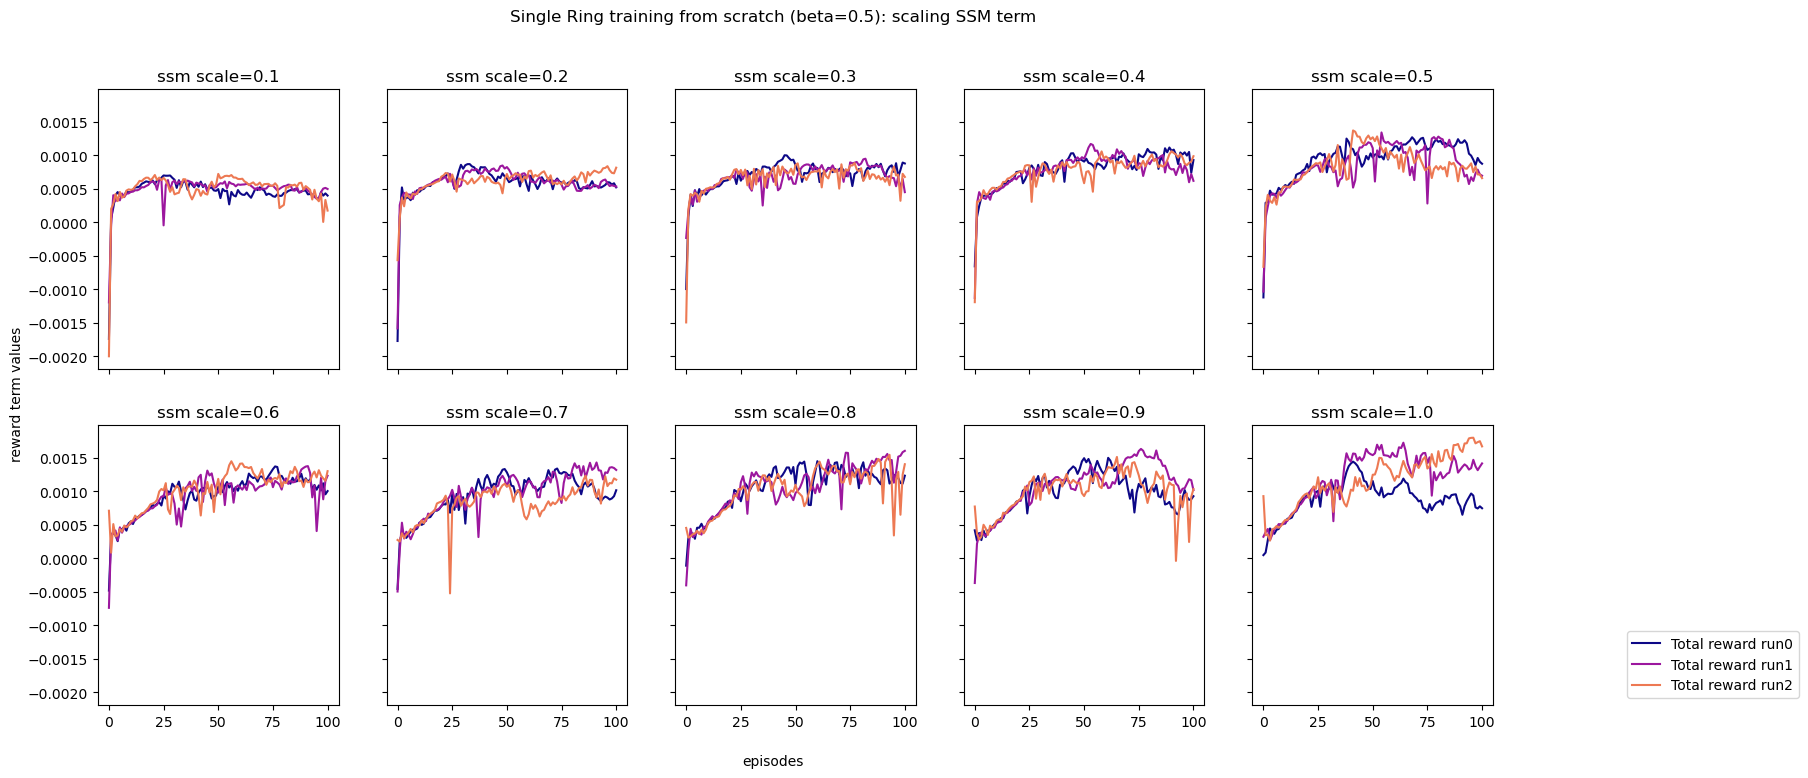

In [36]:
# train progress: plot reward terms for each run of each ssm term scale value

# ssm_term = scale*(ttc - drac)/2
# reward_func = (0.5)*speed_reward + (0.5)*ssm_term

fig, axs = plt.subplots(2, 5, figsize=(18, 8),  sharex=True, sharey=True)
axs_flat = axs.flatten()

cmap_plasma = plt.cm.get_cmap('plasma')
colors = [cmap_plasma(i / (16 - 1)) for i in range(16)] # split plasma into 12 colors

for i, scale in product(run_nums, scale_values):
    cur_dir = f'{single_ring_scaling_SSM_dir}/beta0.5_SSM{scale}_run{i}'
    train_csv = f'{cur_dir}/train_results.csv'
    if os.path.exists(train_csv):
        try:
            train_df = pd.read_csv(train_csv)
            ttc_y, ttc_std = train_df['ttc_mean'], train_df['ttc_std']
            speed_y, speed_std = train_df['speed_reward_mean'], train_df['speed_reward_std']
            drac_y, drac_std = -train_df['drac_mean'], train_df['drac_std']
            ssm_y, ssm_std = train_df['ssm_mean'], train_df['ssm_std']

            x = np.arange(len(speed_y))

            ax = axs_flat[int(10*scale)-1]
            ax.set_title(f'ssm scale={scale}')
            
            ax.plot(x, train_df['reward_mean'], color=colors[5*i], label=f'Total reward run{i}')
        except:
            print(i,scale)

fig.text(0.5, 0.04, 'episodes', ha='center', va='center') # xlabel
fig.text(0.08, 0.5, 'reward term values', ha='center', va='center', rotation='vertical') # ylabel

plt.suptitle('Single Ring training from scratch (beta=0.5): scaling SSM term')
legend_handles, legend_labels = axs_flat[0].get_legend_handles_labels()
plt.legend(handles=legend_handles, labels=legend_labels, loc='lower right', bbox_to_anchor=(2.3, 0))
# plt.tight_layout()
plt.show()

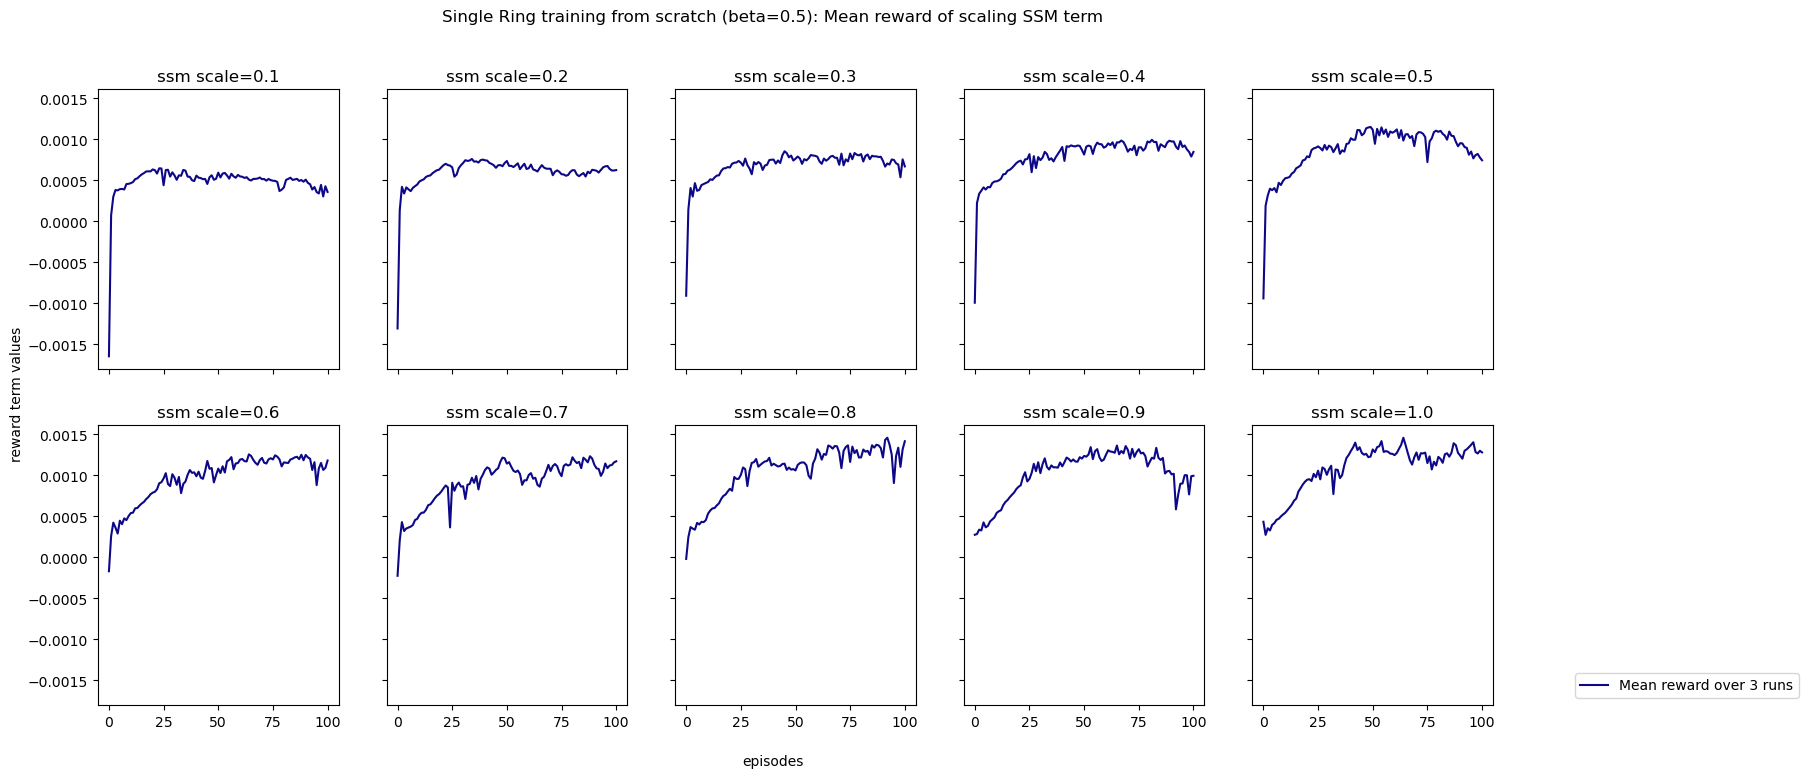

In [41]:
# train progress: plot mean reward terms of each ssm term scale value

# ssm_term = scale*(ttc - drac)/2
# reward_func = (0.5)*speed_reward + (0.5)*ssm_term

#ssm_scaling_5 or 4

fig, axs = plt.subplots(2, 5, figsize=(18, 8),  sharex=True, sharey=True)
axs_flat = axs.flatten()

cmap_plasma = plt.cm.get_cmap('plasma')
colors = [cmap_plasma(i / (9 - 1)) for i in range(9)] # split plasma into 9 colors

for scale in scale_values:
    rewards, reward_stds = [], []
    for i in run_nums:
        
        cur_dir = f'{single_ring_scaling_SSM_dir}/beta0.5_SSM{scale}_run{i}'
        train_csv = f'{cur_dir}/train_results.csv'
        if os.path.exists(train_csv):
            try:
                train_df = pd.read_csv(train_csv)
                rewards += [train_df['reward_mean']]
                # reward_stds += [train_df['reward_std']]
            except:
                print(scale, i)
            
    if rewards:
        
        max_length = max(len(x) for x in rewards)
        rewards = [np.pad(x, (0, max_length - len(x)), constant_values=np.nan) for x in rewards]
        rewards = np.vstack(rewards)
        rewards_mean = np.nanmean(rewards, axis=0)
        # max_length = max(len(x) for x in reward_stds)
        # reward_stds = [np.pad(x, (0, max_length - len(x)), constant_values=np.nan) for x in reward_stds]
        # reward_stds = np.vstack(reward_stds)
        # reward_stds_mean = np.nanmean(reward_stds, axis=0)
        

        x = np.arange(len(rewards_mean))

        ax = axs_flat[int(10*scale)-1]
        ax.set_title(f'ssm scale={scale}')
        ax.plot(x, rewards_mean, color=colors[0], label=f'Mean reward over 3 runs')
        # ax.fill_between(x, rewards_mean-reward_stds_mean, rewards_mean-reward_stds_mean, color=colors[1], alpha=0.2)

fig.text(0.5, 0.04, 'episodes', ha='center', va='center') # xlabel
fig.text(0.08, 0.5, 'reward term values', ha='center', va='center', rotation='vertical') # ylabel

plt.suptitle('Single Ring training from scratch (beta=0.5): Mean reward of scaling SSM term')
legend_handles, legend_labels = axs_flat[0].get_legend_handles_labels()
plt.legend(handles=legend_handles, labels=legend_labels, loc='lower right', bbox_to_anchor=(2.3, 0))
# plt.tight_layout()
plt.show()

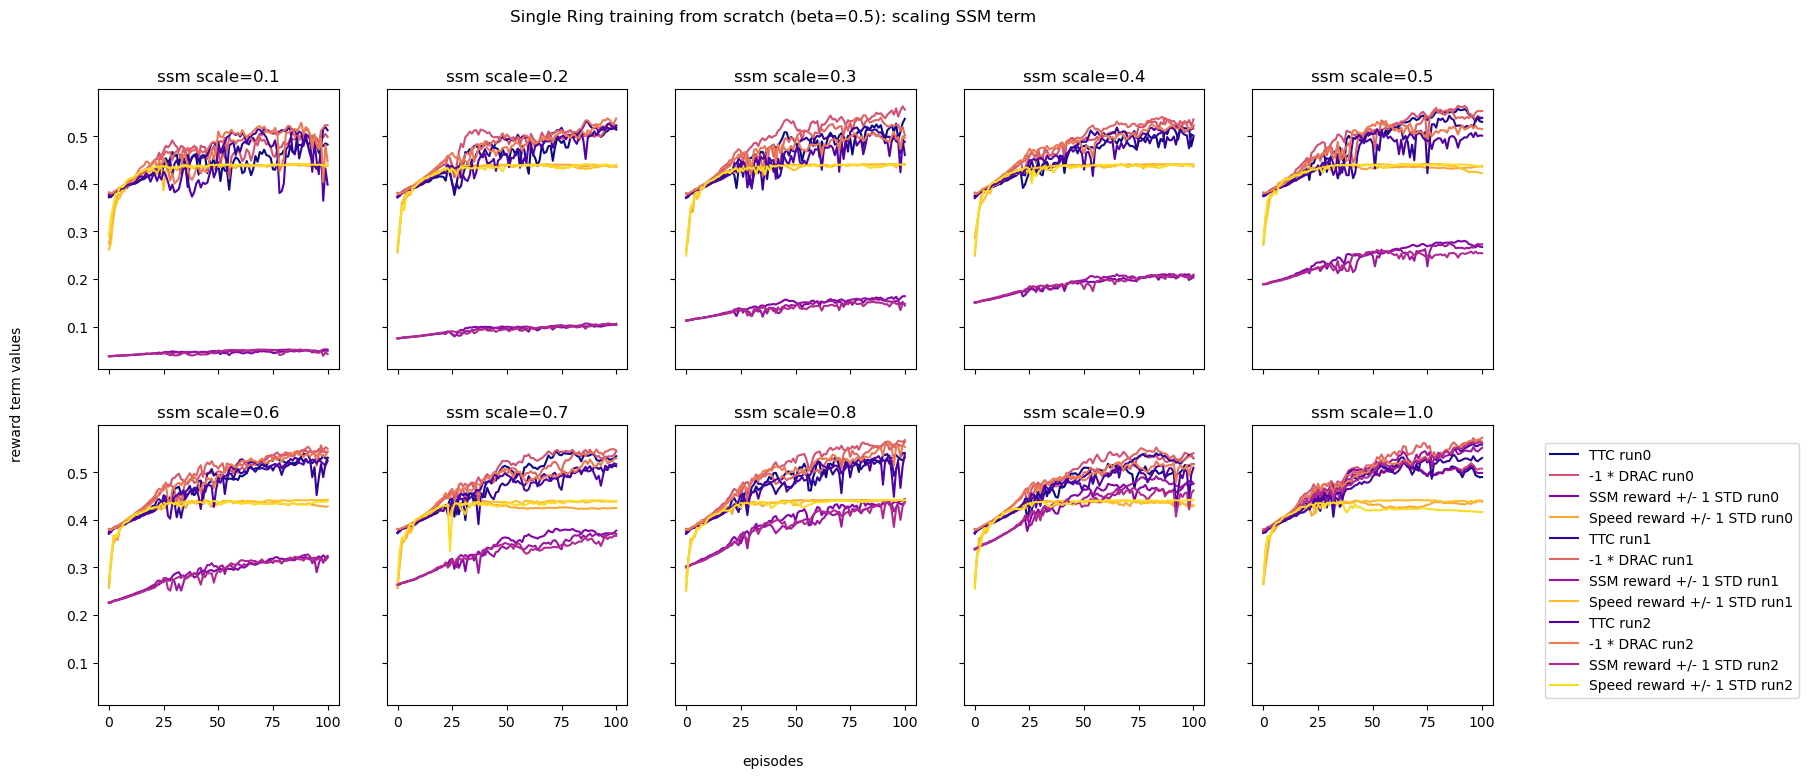

In [33]:
# train progress: plot reward terms for each run of each ssm term scale value

# ssm_term = scale*(ttc - drac)/2
# reward_func = (0.5)*speed_reward + (0.5)*ssm_term

fig, axs = plt.subplots(2, 5, figsize=(18, 8),  sharex=True, sharey=True)
axs_flat = axs.flatten()

cmap_plasma = plt.cm.get_cmap('plasma')
colors = [cmap_plasma(i / (16 - 1)) for i in range(16)] # split plasma into 12 colors

for i, scale in product(run_nums, scale_values):
    cur_dir = f'{single_ring_scaling_SSM_dir}/beta0.5_SSM{scale}_run{i}'
    train_csv = f'{cur_dir}/train_results.csv'
    if os.path.exists(train_csv):
        try:
            # print(i,scale)
            train_df = pd.read_csv(train_csv)
            ttc_y, ttc_std = train_df['ttc_mean'], train_df['ttc_std']
            speed_y, speed_std = train_df['speed_reward_mean'], train_df['speed_reward_std']
            drac_y, drac_std = -train_df['drac_mean'], train_df['drac_std']
            ssm_y, ssm_std = train_df['ssm_mean'], train_df['ssm_std']

            x = np.arange(len(speed_y))

            # pet_y = train_df['pet_mean']
            # ax.plot(x, pet_y, color='orange', label='pet')

            ax = axs_flat[int(10*scale)-1]
            ax.set_title(f'ssm scale={scale}')
            
            ax.plot(x, ttc_y, color=colors[i], label=f'TTC run{i}')
            # ax.fill_between(x, ttc_y-ttc_std, ttc_y+ttc_std, color='red', alpha=0.2)
            ax.plot(x, drac_y, color=colors[i+8], label=f'-1 * DRAC run{i}')
            # ax.fill_between(x, drac_y-drac_std, drac_y+drac_std, color='purple', alpha=0.2)
            ax.plot(x, ssm_y, color=colors[i+4], label=f'SSM reward +/- 1 STD run{i}')
            # ax.fill_between(x, ssm_y-ssm_std, ssm_y+ssm_std, color='red', alpha=0.2)
            ax.plot(x, speed_y, color=colors[i+12], label=f'Speed reward +/- 1 STD run{i}')
            # ax.fill_between(x, speed_y-speed_std, speed_y+speed_std, color='blue', alpha=0.2)
        except:
            print(i,scale)

fig.text(0.5, 0.04, 'episodes', ha='center', va='center') # xlabel
fig.text(0.08, 0.5, 'reward term values', ha='center', va='center', rotation='vertical') # ylabel

plt.suptitle('Single Ring training from scratch (beta=0.5): scaling SSM term')
legend_handles, legend_labels = axs_flat[0].get_legend_handles_labels()
plt.legend(handles=legend_handles, labels=legend_labels, loc='lower right', bbox_to_anchor=(2.3, 0))
# plt.tight_layout()
plt.show()

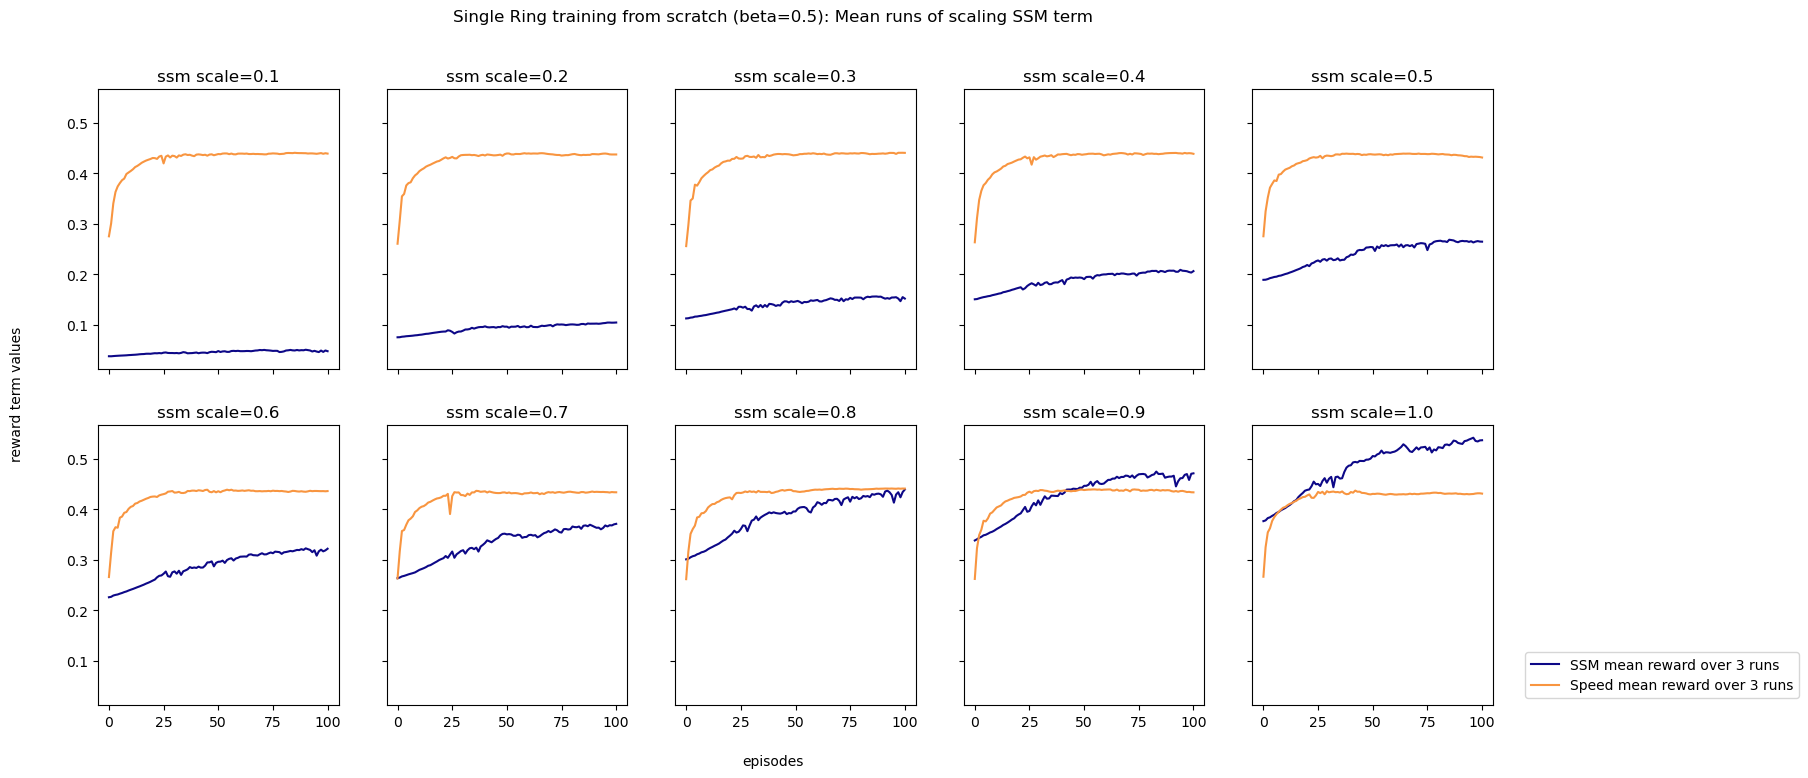

In [5]:
# train progress: plot mean reward terms of each ssm term scale value

# ssm_term = scale*(ttc - drac)/2
# reward_func = (0.5)*speed_reward + (0.5)*ssm_term

#ssm_scaling_5 or 4

fig, axs = plt.subplots(2, 5, figsize=(18, 8),  sharex=True, sharey=True)
axs_flat = axs.flatten()

cmap_plasma = plt.cm.get_cmap('plasma')
colors = [cmap_plasma(i / (9 - 1)) for i in range(9)] # split plasma into 9 colors

for scale in scale_values:
    ssms, speeds = [], []
    for i in run_nums:
        
        cur_dir = f'{single_ring_scaling_SSM_dir}/beta0.5_SSM{scale}_run{i}'
        train_csv = f'{cur_dir}/train_results.csv'
        if os.path.exists(train_csv):
            try:
                train_df = pd.read_csv(train_csv)
                ssm_y, ssm_std = train_df['ssm_mean'], train_df['ssm_std']
                speed_y, speed_std = train_df['speed_reward_mean'], train_df['speed_reward_std']

                ssms += [ssm_y]
                speeds += [speed_y]
            except:
                print(scale, i)
            
    if ssms:
            
        max_length = max(len(x) for x in ssms)
        ssms = [np.pad(x, (0, max_length - len(x)), constant_values=np.nan) for x in ssms]
        ssms = np.vstack(ssms)
        ssm_mean = np.nanmean(ssms, axis=0)
        max_length = max(len(x) for x in speeds)
        speeds = [np.pad(x, (0, max_length - len(x)), constant_values=np.nan) for x in speeds]
        speeds = np.vstack(speeds)
        speed_mean = np.nanmean(speeds, axis=0)

        x = np.arange(max(len(ssm_mean), len(speed_mean)))

        ax = axs_flat[int(10*scale)-1]
        ax.set_title(f'ssm scale={scale}')
        ax.plot(x, ssm_mean, color=colors[0], label=f'SSM mean reward over 3 runs')
        ax.plot(x, speed_mean, color=colors[-3], label=f'Speed mean reward over 3 runs')

fig.text(0.5, 0.04, 'episodes', ha='center', va='center') # xlabel
fig.text(0.08, 0.5, 'reward term values', ha='center', va='center', rotation='vertical') # ylabel

plt.suptitle('Single Ring training from scratch (beta=0.5): Mean runs of scaling SSM term')
legend_handles, legend_labels = axs_flat[0].get_legend_handles_labels()
plt.legend(handles=legend_handles, labels=legend_labels, loc='lower right', bbox_to_anchor=(2.3, 0))
# plt.tight_layout()
plt.show()



##### from scratch, all SSMs (TTC and DRAC)

In [56]:
single_scratch_exp_dir = f'{single_folder}/from_scratch'
Path(f'{single_scratch_exp_dir}').mkdir(parents=True, exist_ok=True)
beta_values=[b/10.0 for b in range(11)]
run_nums=np.arange(single_num_runs)

# seed_np = 2132428247
# seed_torch = 447296
# scale=0.8
# n_steps=100
# # n_steps=300

seed_np=1228644375
seed_torch=106619
scale=0.8
n_steps=150
#n_steps=75


In [5]:
# train

# based on scaling section, reward func is as follows:
# ssm_term = scale*(ttc - drac)/2
# reward_func = (0.5)*speed_reward + (0.5)*ssm_term

def train_single_scratch(i_beta_pairs):
    output_logs = []
    for i, beta in i_beta_pairs:
        cur_dir = f'{single_scratch_exp_dir}/{beta}_{i}'
        Path(f'{cur_dir}').mkdir(parents=True, exist_ok=True)
        output_log_name = f'{cur_dir}/train{beta}_{i}.log'
        train_script_text = single_ring_train_script_text(output_log=output_log_name, run_dir=cur_dir, beta=beta, scale_ttc=scale, scale_drac=scale, n_steps=n_steps, seed_np=seed_np, seed_torch=seed_torch)
        train_script_path = f'{cur_dir}/train{beta}_{i}.sh'
        create_file_with_contents(train_script_path, train_script_text)
        out, err = submit_job(train_script_path)
        output_logs += [output_log_name]
    return output_logs

In [5]:
train_outputs = train_single_scratch(product(run_nums, beta_values))
print(train_outputs)

['pareto/single_ring/from_scratch/0.0_0/train0.0_0.log', 'pareto/single_ring/from_scratch/0.1_0/train0.1_0.log', 'pareto/single_ring/from_scratch/0.2_0/train0.2_0.log', 'pareto/single_ring/from_scratch/0.3_0/train0.3_0.log', 'pareto/single_ring/from_scratch/0.4_0/train0.4_0.log', 'pareto/single_ring/from_scratch/0.5_0/train0.5_0.log', 'pareto/single_ring/from_scratch/0.6_0/train0.6_0.log', 'pareto/single_ring/from_scratch/0.7_0/train0.7_0.log', 'pareto/single_ring/from_scratch/0.8_0/train0.8_0.log', 'pareto/single_ring/from_scratch/0.9_0/train0.9_0.log', 'pareto/single_ring/from_scratch/1.0_0/train1.0_0.log', 'pareto/single_ring/from_scratch/0.0_1/train0.0_1.log', 'pareto/single_ring/from_scratch/0.1_1/train0.1_1.log', 'pareto/single_ring/from_scratch/0.2_1/train0.2_1.log', 'pareto/single_ring/from_scratch/0.3_1/train0.3_1.log', 'pareto/single_ring/from_scratch/0.4_1/train0.4_1.log', 'pareto/single_ring/from_scratch/0.5_1/train0.5_1.log', 'pareto/single_ring/from_scratch/0.6_1/train0.6

In [65]:
# retrain failed runs

# rm -rf relevant dir
train_single_scratch([(1, 0.4)])

['pareto/single_ring/from_scratch/0.4_1/train0.4_1.log']

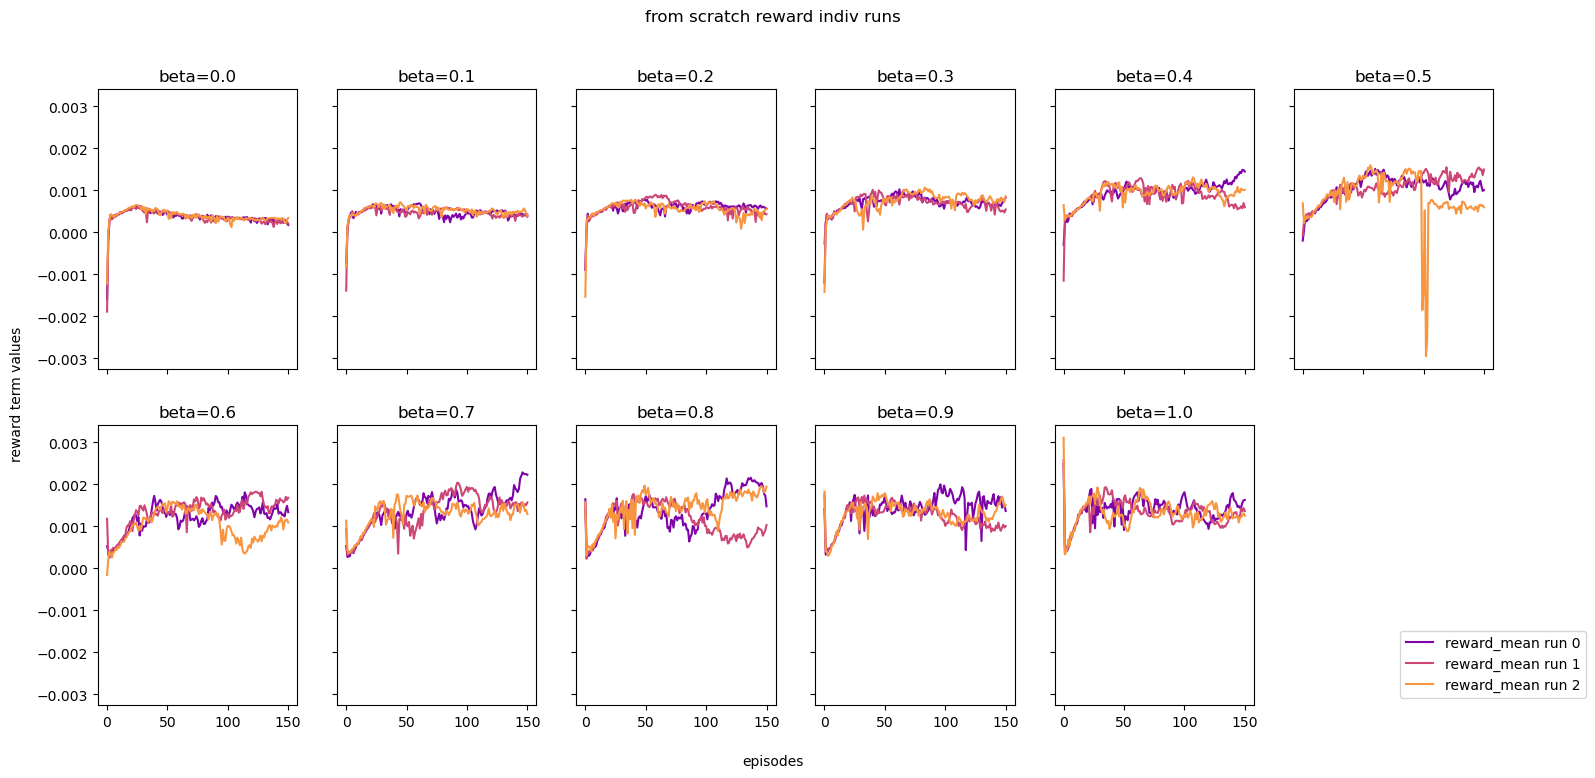

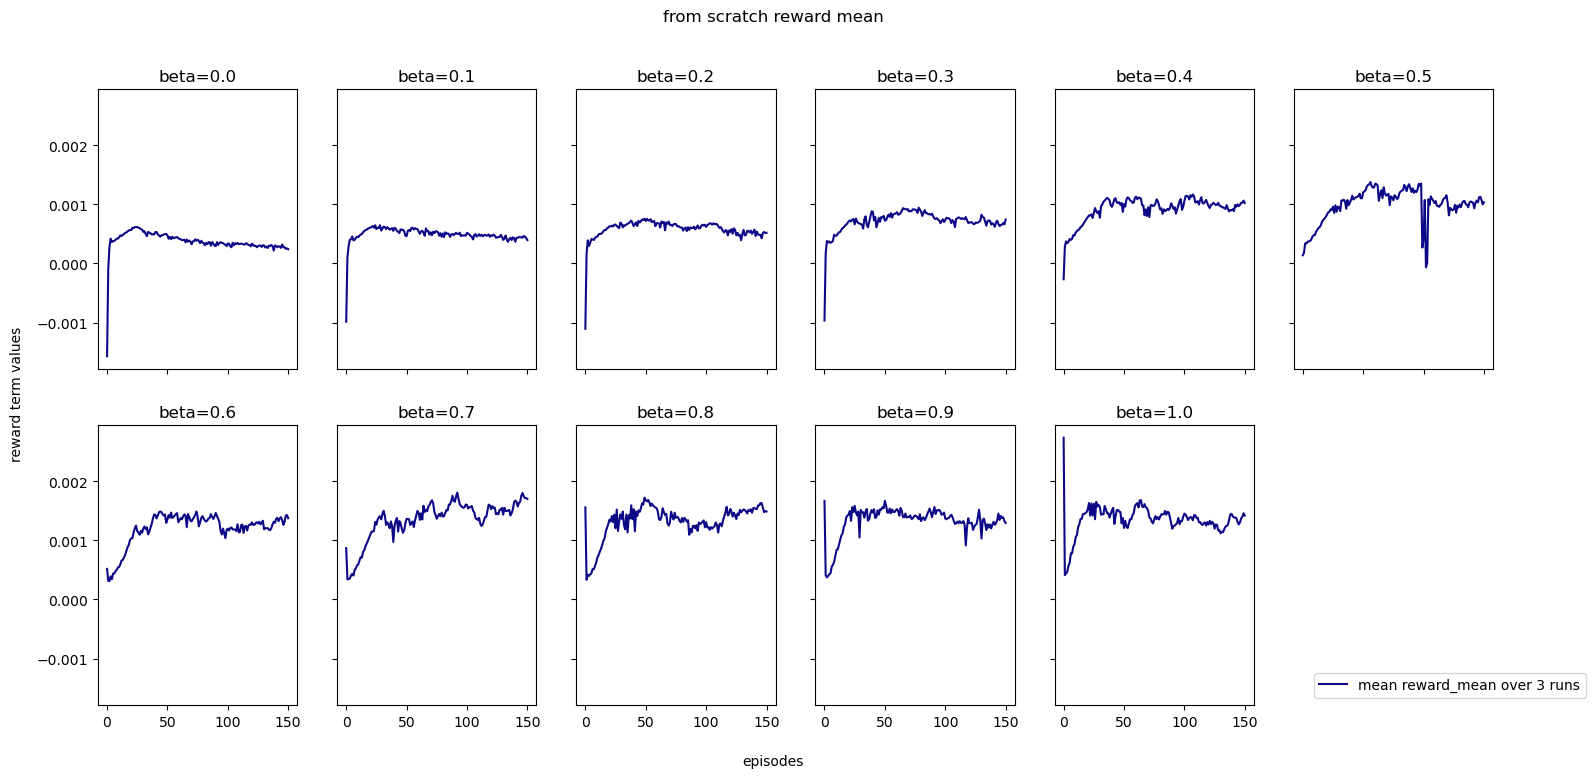

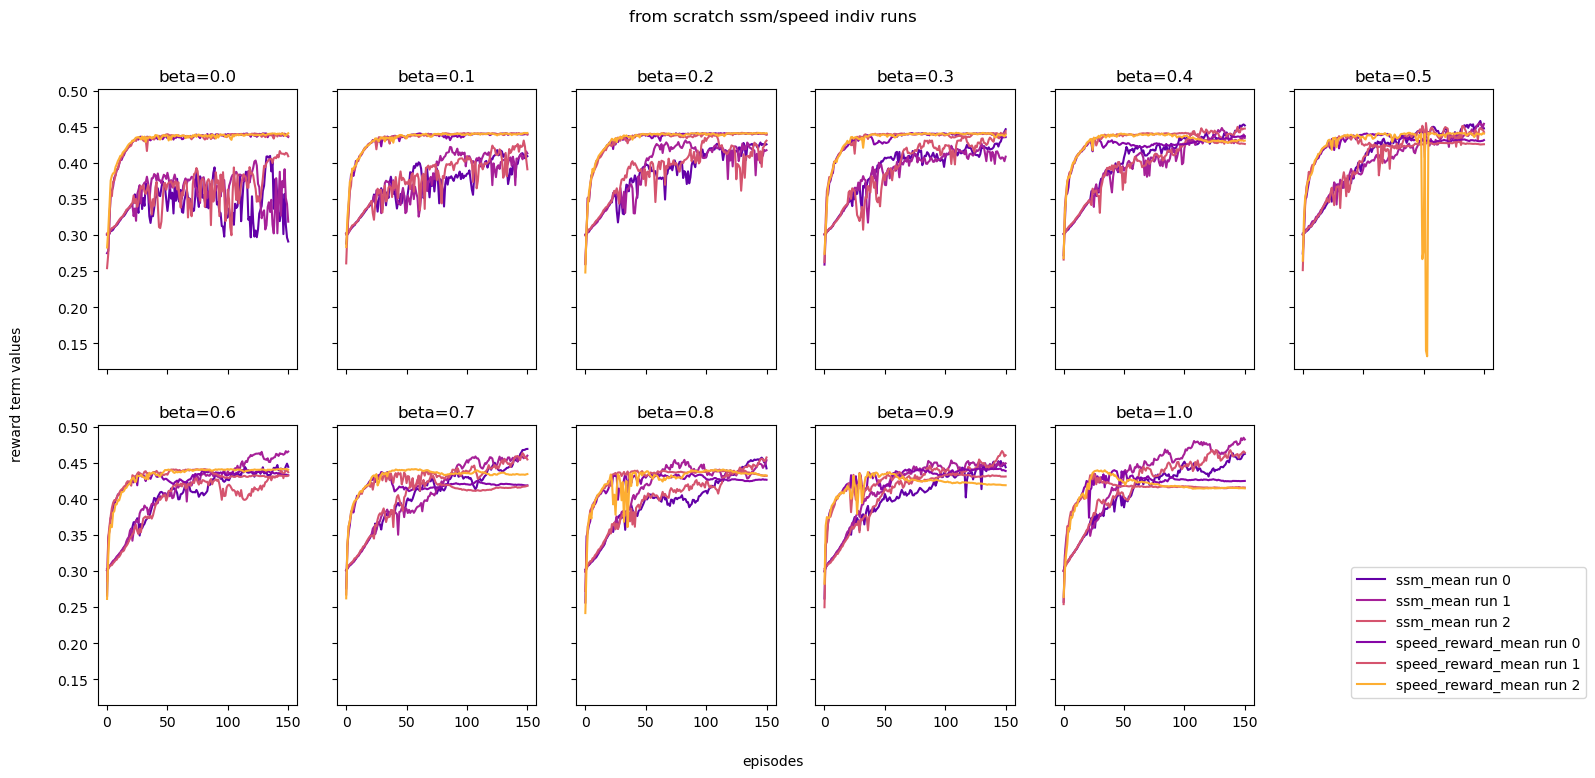

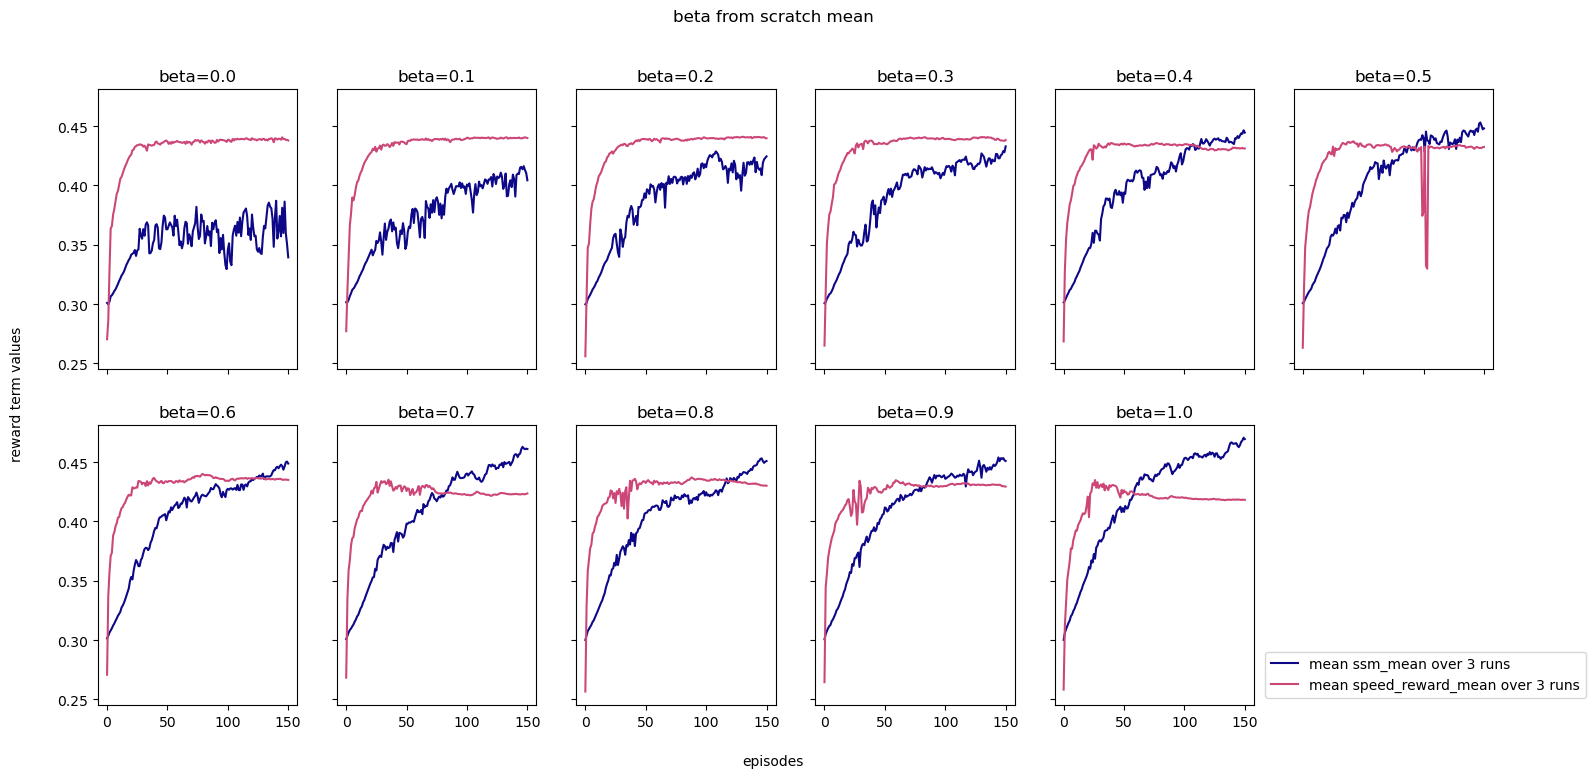

In [5]:
# train progress: plot overall reward

plot_training(single_scratch_exp_dir, ['reward_mean'], beta_values, 'beta', 'from scratch reward indiv runs', run_nums, mean=False, xlen=n_steps)
plot_training(single_scratch_exp_dir, ['reward_mean'], beta_values, 'beta', 'from scratch reward mean', run_nums, mean=True, xlen=n_steps)

# plotting ssm and speed for interest
plot_training(single_scratch_exp_dir, ['ssm_mean', 'speed_reward_mean'], beta_values, 'beta', 'from scratch ssm/speed indiv runs', run_nums, mean=False, xlen=n_steps)
plot_training(single_scratch_exp_dir, ['ssm_mean', 'speed_reward_mean'], beta_values, 'beta', 'beta from scratch mean', run_nums, mean=True, xlen=n_steps)

In [161]:
# verify successful train
train_outputs=['pareto/single_ring/from_scratch/0.0_0/train0.0_0.log', 'pareto/single_ring/from_scratch/0.0_1/train0.0_1.log', 'pareto/single_ring/from_scratch/0.0_2/train0.0_2.log', 'pareto/single_ring/from_scratch/0.1_0/train0.1_0.log', 'pareto/single_ring/from_scratch/0.1_1/train0.1_1.log', 'pareto/single_ring/from_scratch/0.1_2/train0.1_2.log', 'pareto/single_ring/from_scratch/0.2_0/train0.2_0.log', 'pareto/single_ring/from_scratch/0.2_1/train0.2_1.log', 'pareto/single_ring/from_scratch/0.2_2/train0.2_2.log', 'pareto/single_ring/from_scratch/0.3_0/train0.3_0.log', 'pareto/single_ring/from_scratch/0.3_1/train0.3_1.log', 'pareto/single_ring/from_scratch/0.3_2/train0.3_2.log', 'pareto/single_ring/from_scratch/0.4_0/train0.4_0.log', 'pareto/single_ring/from_scratch/0.4_1/train0.4_1.log', 'pareto/single_ring/from_scratch/0.4_2/train0.4_2.log', 'pareto/single_ring/from_scratch/0.5_0/train0.5_0.log', 'pareto/single_ring/from_scratch/0.5_1/train0.5_1.log', 'pareto/single_ring/from_scratch/0.5_2/train0.5_2.log', 'pareto/single_ring/from_scratch/0.6_0/train0.6_0.log', 'pareto/single_ring/from_scratch/0.6_1/train0.6_1.log', 'pareto/single_ring/from_scratch/0.6_2/train0.6_2.log', 'pareto/single_ring/from_scratch/0.7_0/train0.7_0.log', 'pareto/single_ring/from_scratch/0.7_1/train0.7_1.log', 'pareto/single_ring/from_scratch/0.7_2/train0.7_2.log', 'pareto/single_ring/from_scratch/0.8_0/train0.8_0.log', 'pareto/single_ring/from_scratch/0.8_1/train0.8_1.log', 'pareto/single_ring/from_scratch/0.8_2/train0.8_2.log', 'pareto/single_ring/from_scratch/0.9_0/train0.9_0.log', 'pareto/single_ring/from_scratch/0.9_1/train0.9_1.log', 'pareto/single_ring/from_scratch/0.9_2/train0.9_2.log', 'pareto/single_ring/from_scratch/1.0_0/train1.0_0.log', 'pareto/single_ring/from_scratch/1.0_1/train1.0_1.log', 'pareto/single_ring/from_scratch/1.0_2/train1.0_2.log']
verify_multiple_execution(train_outputs) 

failed scripts: ['pareto/single_ring/from_scratch/0.0_0/train0.0_0.log', 'pareto/single_ring/from_scratch/0.0_1/train0.0_1.log', 'pareto/single_ring/from_scratch/0.5_2/train0.5_2.log', 'pareto/single_ring/from_scratch/1.0_2/train1.0_2.log']


In [7]:
# eval

def eval_single_scratch(i_beta_pairs, e):
    output_logs = []
    for i, beta in i_beta_pairs:
        cur_dir = f'{single_scratch_exp_dir}/{beta}_{i}'
        output_log_name = f'{cur_dir}/eval{beta}_{i}_{e}.log'
        # eval_script_text = single_ring_eval_script_text(e=e, beta=beta, output_log=output_log_name, run_dir=cur_dir, result_save=f'{cur_dir}/eval_e{e}_on{beta}.csv', vehicle_info_save=f'{cur_dir}/trajectory.npz', scale_ttc=scale, scale_drac=scale)
        eval_script_text = single_ring_eval_script_text(e=e, beta=beta, output_log=output_log_name, run_dir=cur_dir, result_save=f'{cur_dir}/eval_e{e}.csv', vehicle_info_save=f'{cur_dir}/trajectory.npz', scale_ttc=scale, scale_drac=scale)

        eval_script_path = f'{cur_dir}/eval{beta}_{i}_{e}.sh'
        create_file_with_contents(eval_script_path, eval_script_text)
        out, err = submit_job(eval_script_path)
        output_logs += [output_log_name]
    return output_logs

In [48]:
eval_outputs = eval_single_scratch(product(run_nums,beta_values), 75)
print(eval_outputs)

['pareto/single_ring/from_scratch/0.0_0/eval0.0_0_75.log', 'pareto/single_ring/from_scratch/0.1_0/eval0.1_0_75.log', 'pareto/single_ring/from_scratch/0.2_0/eval0.2_0_75.log', 'pareto/single_ring/from_scratch/0.3_0/eval0.3_0_75.log', 'pareto/single_ring/from_scratch/0.4_0/eval0.4_0_75.log', 'pareto/single_ring/from_scratch/0.5_0/eval0.5_0_75.log', 'pareto/single_ring/from_scratch/0.6_0/eval0.6_0_75.log', 'pareto/single_ring/from_scratch/0.7_0/eval0.7_0_75.log', 'pareto/single_ring/from_scratch/0.8_0/eval0.8_0_75.log', 'pareto/single_ring/from_scratch/0.9_0/eval0.9_0_75.log', 'pareto/single_ring/from_scratch/1.0_0/eval1.0_0_75.log', 'pareto/single_ring/from_scratch/0.0_1/eval0.0_1_75.log', 'pareto/single_ring/from_scratch/0.1_1/eval0.1_1_75.log', 'pareto/single_ring/from_scratch/0.2_1/eval0.2_1_75.log', 'pareto/single_ring/from_scratch/0.3_1/eval0.3_1_75.log', 'pareto/single_ring/from_scratch/0.4_1/eval0.4_1_75.log', 'pareto/single_ring/from_scratch/0.5_1/eval0.5_1_75.log', 'pareto/singl

In [49]:
eval_outputs = eval_single_scratch(product(run_nums,beta_values), 150)
print(eval_outputs)

['pareto/single_ring/from_scratch/0.0_0/eval0.0_0_150.log', 'pareto/single_ring/from_scratch/0.1_0/eval0.1_0_150.log', 'pareto/single_ring/from_scratch/0.2_0/eval0.2_0_150.log', 'pareto/single_ring/from_scratch/0.3_0/eval0.3_0_150.log', 'pareto/single_ring/from_scratch/0.4_0/eval0.4_0_150.log', 'pareto/single_ring/from_scratch/0.5_0/eval0.5_0_150.log', 'pareto/single_ring/from_scratch/0.6_0/eval0.6_0_150.log', 'pareto/single_ring/from_scratch/0.7_0/eval0.7_0_150.log', 'pareto/single_ring/from_scratch/0.8_0/eval0.8_0_150.log', 'pareto/single_ring/from_scratch/0.9_0/eval0.9_0_150.log', 'pareto/single_ring/from_scratch/1.0_0/eval1.0_0_150.log', 'pareto/single_ring/from_scratch/0.0_1/eval0.0_1_150.log', 'pareto/single_ring/from_scratch/0.1_1/eval0.1_1_150.log', 'pareto/single_ring/from_scratch/0.2_1/eval0.2_1_150.log', 'pareto/single_ring/from_scratch/0.3_1/eval0.3_1_150.log', 'pareto/single_ring/from_scratch/0.4_1/eval0.4_1_150.log', 'pareto/single_ring/from_scratch/0.5_1/eval0.5_1_150.lo

In [50]:
eval_outputs = eval_single_scratch(product(run_nums,beta_values), 145)
print(eval_outputs)

['pareto/single_ring/from_scratch/0.0_0/eval0.0_0_145.log', 'pareto/single_ring/from_scratch/0.1_0/eval0.1_0_145.log', 'pareto/single_ring/from_scratch/0.2_0/eval0.2_0_145.log', 'pareto/single_ring/from_scratch/0.3_0/eval0.3_0_145.log', 'pareto/single_ring/from_scratch/0.4_0/eval0.4_0_145.log', 'pareto/single_ring/from_scratch/0.5_0/eval0.5_0_145.log', 'pareto/single_ring/from_scratch/0.6_0/eval0.6_0_145.log', 'pareto/single_ring/from_scratch/0.7_0/eval0.7_0_145.log', 'pareto/single_ring/from_scratch/0.8_0/eval0.8_0_145.log', 'pareto/single_ring/from_scratch/0.9_0/eval0.9_0_145.log', 'pareto/single_ring/from_scratch/1.0_0/eval1.0_0_145.log', 'pareto/single_ring/from_scratch/0.0_1/eval0.0_1_145.log', 'pareto/single_ring/from_scratch/0.1_1/eval0.1_1_145.log', 'pareto/single_ring/from_scratch/0.2_1/eval0.2_1_145.log', 'pareto/single_ring/from_scratch/0.3_1/eval0.3_1_145.log', 'pareto/single_ring/from_scratch/0.4_1/eval0.4_1_145.log', 'pareto/single_ring/from_scratch/0.5_1/eval0.5_1_145.lo

In [8]:
# rerun failed evals ():

# rm -rf relevant files
eval_single_scratch([(1, 0.4)], 75)
eval_single_scratch([(1, 0.4)], 145)

['pareto/single_ring/from_scratch/0.4_1/eval0.4_1_145.log']

In [33]:
# verify successful eval
verify_multiple_execution(eval_outputs)

failed scripts: ['pareto/single_ring/from_scratch/0.8_0/eval0.8_0_150.log', 'pareto/single_ring/from_scratch/0.9_0/eval0.9_0_150.log', 'pareto/single_ring/from_scratch/1.0_0/eval1.0_0_150.log', 'pareto/single_ring/from_scratch/0.0_1/eval0.0_1_150.log', 'pareto/single_ring/from_scratch/0.1_1/eval0.1_1_150.log', 'pareto/single_ring/from_scratch/0.2_1/eval0.2_1_150.log', 'pareto/single_ring/from_scratch/0.3_1/eval0.3_1_150.log', 'pareto/single_ring/from_scratch/0.4_1/eval0.4_1_150.log']


[0.36169427986204034, 0.38551961692247955, 0.40172069979168645, 0.4066574781985179, 0.4048474226186241, 0.41375570111414817, 0.41422743109116583, 0.4109776183776024, 0.414643811087729, 0.420311286226095, 0.4317886791433245] [0.4376915381285313, 0.4385323926449927, 0.4385755553858967, 0.439177649248273, 0.43472674206929934, 0.42755802857708575, 0.4377802884351101, 0.424233501870301, 0.4324455366320837, 0.4307284927206501, 0.42034031979300845]


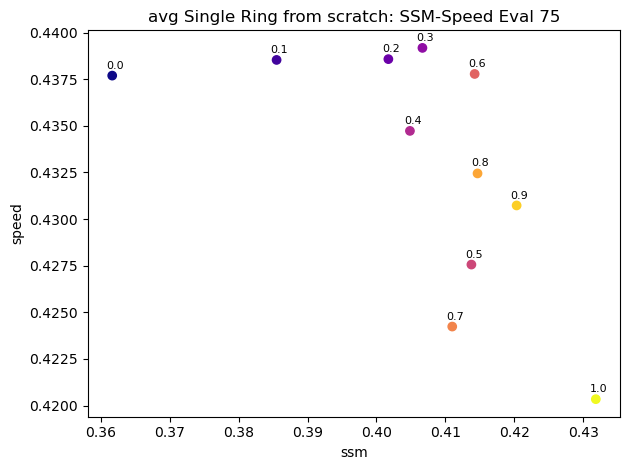

[0.3484438963906403, 0.3755363595315879, 0.4206736154259604, 0.4059257067202228, 0.41481766483225463, 0.4144518735143832, 0.42427549843522466, 0.4237177800178956, 0.39758465733724285, 0.42941786026853696, 0.42531586543918065] [0.4371922126109388, 0.4397062401674692, 0.43734830721656853, 0.43863156031792816, 0.42615632707679224, 0.42742803514146666, 0.44005716222833896, 0.43648461998783966, 0.4334786411369048, 0.4261144382719664, 0.42048807866900895]


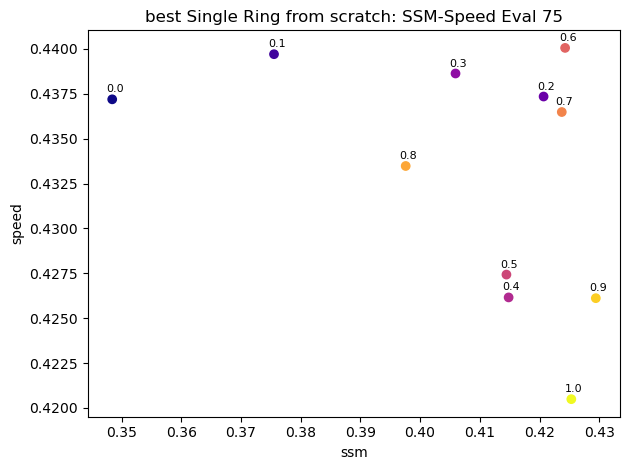

In [19]:
# plot all eval points

# eval with scale=0.8

plot_avg_eval(single_scratch_exp_dir, 75, beta_values, run_nums, 'avg Single Ring from scratch: SSM-Speed Eval 75') 
best_at_75 = get_best_run(single_scratch_exp_dir, 75, beta_values, run_nums)
plot_best_eval(single_scratch_exp_dir, 75, beta_values, run_nums, 'best Single Ring from scratch: SSM-Speed Eval 75', best_at_75) 

In [58]:
eval_onbeta_outputs = eval_single_scratch(product(run_nums,beta_values), 75)

[0.3629336897058377, 0.3848839301866614, 0.40214046160889677, 0.4063790222453898, 0.4087445998253374, 0.41485775435336825, 0.41451420313185455, 0.4112068063416426, 0.41557187999587714, 0.4199247276333283, 0.4320560076417694] [0.4377362011110708, 0.4383718830893602, 0.438656612029022, 0.43918765200290366, 0.43256897800010996, 0.42808184978670694, 0.4377578028654119, 0.4241644395569459, 0.43249251265283584, 0.43074790040860345, 0.4203023082579212]


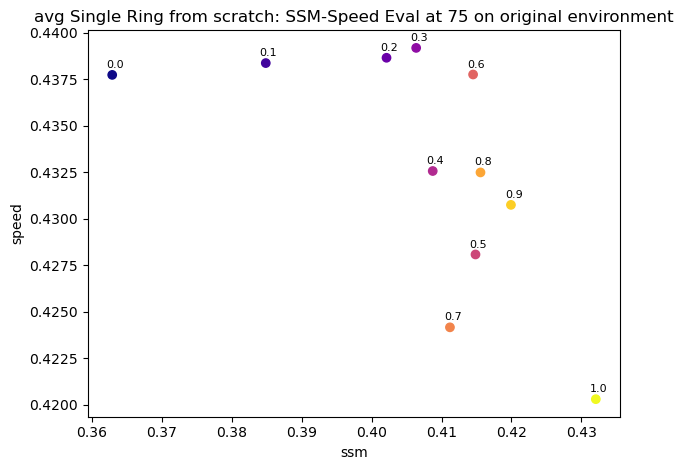

[0.3494551263239166, 0.3766779175377072, 0.4210686572448806, 0.4050792098213648, 0.4140276852420258, 0.41632678059512, 0.4253483931527503, 0.42325825013464735, 0.3969425187108791, 0.4294717889184754, 0.4257536573955406] [0.43703887047102014, 0.4395915685032511, 0.4373171021661345, 0.4387367468383746, 0.4261235759897854, 0.42911836491590477, 0.44009279206838564, 0.4363347640559496, 0.4334142038977774, 0.4261141458544607, 0.42030815819120304]


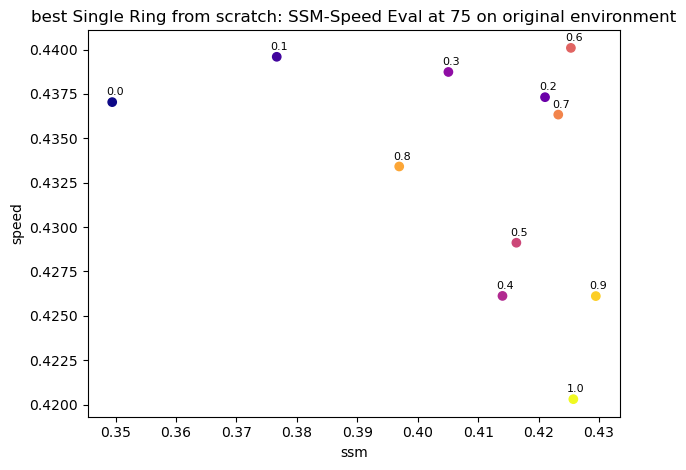

In [20]:
# plot all eval points

# eval on each training beta!!

plot_avg_eval(single_scratch_exp_dir, 75, beta_values, run_nums, 'avg Single Ring from scratch: SSM-Speed Eval at 75 on original environment', csv_default=False) 
best_at_75 = get_best_run(single_scratch_exp_dir, 75, beta_values, run_nums)
plot_best_eval(single_scratch_exp_dir, 75, beta_values, run_nums, 'best Single Ring from scratch: SSM-Speed Eval at 75 on original environment', best_at_75, csv_default=False) 

[0.3391613907457873, 0.391187083419187, 0.4177105406129096, 0.42530063594663275, 0.44394558196204226, 0.44001349669974027, 0.4423017378515546, 0.4532096985817739, 0.4441675033391624, 0.4445186332279371, 0.4623439552933209] [0.4378147206285045, 0.438797235985448, 0.43906345523623097, 0.437506153940659, 0.4335417863876046, 0.43161971463661136, 0.434653330456682, 0.42350745624566377, 0.42980635395922856, 0.4291976752758689, 0.4183613711213572]


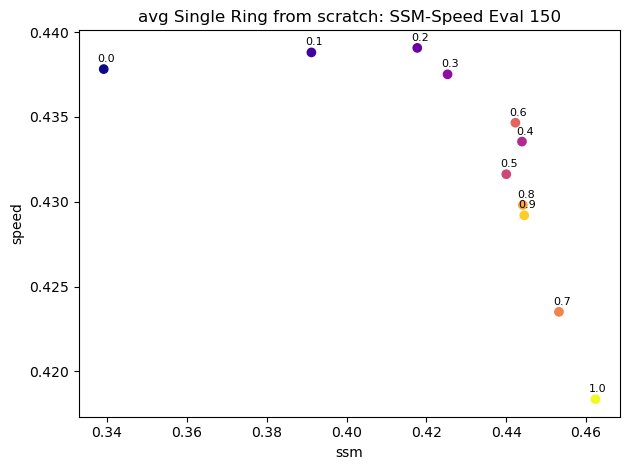

1 0.4
[0.3009856662808846, 0.4056419238692368, 0.4203303628081782, 0.39922670791851356, 0.4457171081897503, 0.4443647662262736, 0.4602139562567866, 0.43877469179700873, 0.44793435149937866, 0.4358470313783383, 0.4556729079883547] [0.43732266092413996, 0.43861186298354476, 0.4385455795049915, 0.4396186310332542, 0.43649395111381584, 0.4312225916780288, 0.4316423638657435, 0.43398209776217406, 0.43134857374781915, 0.43796191866477063, 0.42487686765121147]


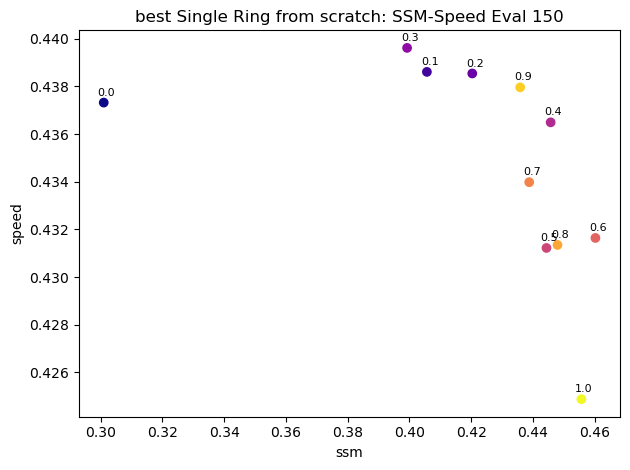

In [21]:
# plot all eval points

plot_avg_eval(single_scratch_exp_dir, 150, beta_values, run_nums, 'avg Single Ring from scratch: SSM-Speed Eval 150') 
best_at_150 = get_best_run(single_scratch_exp_dir, 150, beta_values, run_nums)
plot_best_eval(single_scratch_exp_dir, 150, beta_values, run_nums, 'best Single Ring from scratch: SSM-Speed Eval 150', best_at_150) 

[0.3708762092415719, 0.4058325740141884, 0.4089461825826035, 0.41993502146089307, 0.43413285197848234, 0.44028752245973696, 0.441157035772125, 0.4557280121797276, 0.4465649998499582, 0.4422992144620941, 0.4556185187809567] [0.43933974466498976, 0.4391321100767773, 0.44031746722349796, 0.43798440997782384, 0.43137558596217795, 0.43175169969825217, 0.4350659824765537, 0.422906313399297, 0.4303390528217334, 0.43062104686697983, 0.4185443466428463]


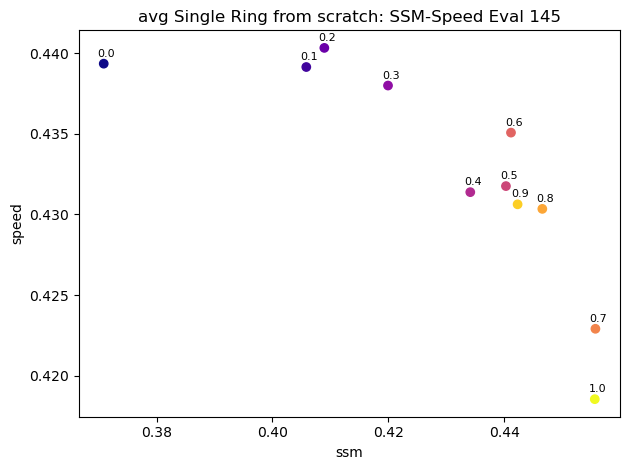

[0.3466891438094143, 0.3984994843734302, 0.41987897519985484, 0.42463294835995125, 0.4408988623672839, 0.4467198029666591, 0.45670831104049886, 0.44838963288381867, 0.44471209162332687, 0.4511780417508392, 0.44997521132001345] [0.4394247473206428, 0.43755515880769896, 0.44002903132576926, 0.43695044398552396, 0.4358402997486161, 0.4297967443754784, 0.43168582879281747, 0.4333957361954501, 0.4321577102585713, 0.4194123921954106, 0.41486625887548084]


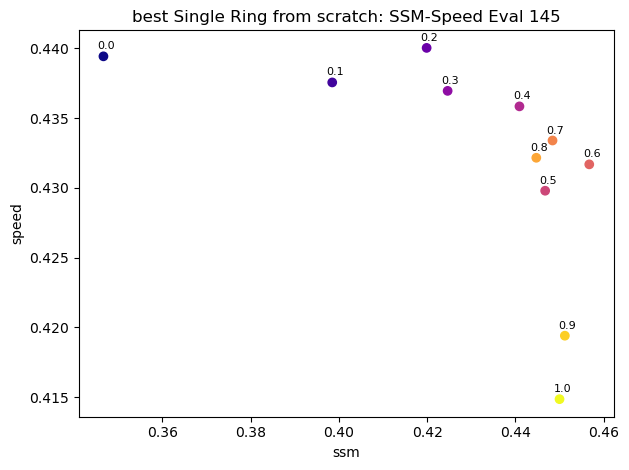

In [47]:
# plot all eval points

plot_avg_eval(single_scratch_exp_dir, 145, beta_values, run_nums, 'avg Single Ring from scratch: SSM-Speed Eval 145') 
best_at_145 = get_best_run(single_scratch_exp_dir, 145, beta_values, run_nums)
plot_best_eval(single_scratch_exp_dir, 145, beta_values, run_nums, 'best Single Ring from scratch: SSM-Speed Eval 145', best_at_145) 

In [ ]:
# plot Pareto frontier of evals



##### finetuning

In [57]:
single_finetune_exp_dir = f'{single_folder}/finetune'
Path(f'{single_finetune_exp_dir}').mkdir(parents=True, exist_ok=True)

source_values=[b/10.0 for b in range(11)]
target_values=[b/10.0 for b in range(11)]
run_nums=np.arange(single_num_runs)

seed_np=1228644375
seed_torch=106619
scale=0.8
# n_steps=150

source_e=145
additional_e=145
source_best_runs_per_beta = get_best_run(single_scratch_exp_dir, source_e, beta_values, run_nums)

In [30]:

def train_single_finetune(i_source_target_triples):
    output_logs = []
    for i, s, t in i_source_target_triples:
        source_dir = f'{single_scratch_exp_dir}/{s}_{source_best_runs_per_beta[s]}'
        target_dir = f'{single_finetune_exp_dir}/{s}_{source_best_runs_per_beta[s]}_e{source_e}_to_{t}_{i}'
        prep_additional_training(source_dir, target_dir, source_e)
        
        output_log_name = f'{target_dir}/train.log'
        train_script_text = single_ring_train_script_text(output_log=output_log_name, run_dir=target_dir, beta=t, scale_ttc=scale, scale_drac=scale, n_steps=source_e+additional_e, seed_np=seed_np, seed_torch=seed_torch)
        train_script_path = f'{target_dir}/FTtrain{s}to{t}_{i}.sh'
        create_file_with_contents(train_script_path, train_script_text)
        out, err = submit_job(train_script_path)
        output_logs += [output_log_name]
    return output_logs

In [ ]:
def train_uppertriangular_single_finetune(i_source_target_triples):
    output_logs = []
    for i, s, t in i_source_target_triples:
        if t > s:
            source_dir = f'{single_scratch_exp_dir}/{s}_{source_best_runs_per_beta[s]}'
            target_dir = f'{single_finetune_exp_dir}/{s}_{source_best_runs_per_beta[s]}_e{source_e}_to_{t}_{i}'
            prep_additional_training(source_dir, target_dir, source_e)

            output_log_name = f'{target_dir}/train.log'
            train_script_text = single_ring_train_script_text(output_log=output_log_name, run_dir=target_dir, beta=t, scale_ttc=scale, scale_drac=scale, n_steps=source_e+additional_e, seed_np=seed_np, seed_torch=seed_torch)
            train_script_path = f'{target_dir}/FTtrain{s}to{t}_{i}.sh'
            create_file_with_contents(train_script_path, train_script_text)
            out, err = submit_job(train_script_path)
            output_logs += [output_log_name]
    print(output_logs)
    
    
def train_lowertriangular_single_finetune(i_source_target_triples):
    output_logs = []
    for i, s, t in i_source_target_triples:
        if t <= s:
            source_dir = f'{single_scratch_exp_dir}/{s}_{source_best_runs_per_beta[s]}'
            target_dir = f'{single_finetune_exp_dir}/{s}_{source_best_runs_per_beta[s]}_e{source_e}_to_{t}_{i}'
            prep_additional_training(source_dir, target_dir, source_e)

            output_log_name = f'{target_dir}/train.log'
            train_script_text = single_ring_train_script_text(output_log=output_log_name, run_dir=target_dir, beta=t, scale_ttc=scale, scale_drac=scale, n_steps=source_e+additional_e, seed_np=seed_np, seed_torch=seed_torch)
            train_script_path = f'{target_dir}/FTtrain{s}to{t}_{i}.sh'
            create_file_with_contents(train_script_path, train_script_text)
            out, err = submit_job(train_script_path)
            output_logs += [output_log_name]
    print(output_logs)

In [12]:
# train_single_finetune(product(run_nums, source_values, target_values))

# train_single_finetune(product([0], [0.0, 0.2, 0.4, 0.6, 0.8, 1.0], [1.0]))
# train_uppertriangular_single_finetune(product([0], [0.0, 0.2, 0.4, 0.6, 0.8, 1.0], [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]))
train_single_finetune(product([1], [0.0, 0.2, 0.4, 0.6, 0.8, 1.0], [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]))

['pareto/single_ring/finetune/0.0_0_e145_to_0.0_1/train.log',
 'pareto/single_ring/finetune/0.0_0_e145_to_0.2_1/train.log',
 'pareto/single_ring/finetune/0.0_0_e145_to_0.4_1/train.log',
 'pareto/single_ring/finetune/0.0_0_e145_to_0.6_1/train.log',
 'pareto/single_ring/finetune/0.0_0_e145_to_0.8_1/train.log',
 'pareto/single_ring/finetune/0.0_0_e145_to_1.0_1/train.log',
 'pareto/single_ring/finetune/0.2_0_e145_to_0.0_1/train.log',
 'pareto/single_ring/finetune/0.2_0_e145_to_0.2_1/train.log',
 'pareto/single_ring/finetune/0.2_0_e145_to_0.4_1/train.log',
 'pareto/single_ring/finetune/0.2_0_e145_to_0.6_1/train.log',
 'pareto/single_ring/finetune/0.2_0_e145_to_0.8_1/train.log',
 'pareto/single_ring/finetune/0.2_0_e145_to_1.0_1/train.log',
 'pareto/single_ring/finetune/0.4_0_e145_to_0.0_1/train.log',
 'pareto/single_ring/finetune/0.4_0_e145_to_0.2_1/train.log',
 'pareto/single_ring/finetune/0.4_0_e145_to_0.4_1/train.log',
 'pareto/single_ring/finetune/0.4_0_e145_to_0.6_1/train.log',
 'pareto

In [34]:
train_uppertriangular_single_finetune(product([0], [0.2], [0.8]))

['pareto/single_ring/finetune/0.2_0_e145_to_0.8_0/train.log']


In [ ]:
train_uppertriangular_single_finetune(product([1], [0.0, 0.2, 0.4, 0.6, 0.8, 1.0], [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]))

In [31]:
# train_single_finetune(product([1], [0.2], [0.6]))
train_single_finetune(product([1], [0.8], [0.4, 0.8]))

['pareto/single_ring/finetune/0.8_2_e145_to_0.4_1/train.log',
 'pareto/single_ring/finetune/0.8_2_e145_to_0.8_1/train.log']

In [32]:
train_single_finetune(product([0], [0.6], [0.2]))
train_single_finetune(product([0], [0.8], [0.4]))

['pareto/single_ring/finetune/0.8_2_e145_to_0.4_0/train.log']

In [23]:
#verify trained
output_logs = ['pareto/single_ring/finetune/0.0_0_e145_to_0.2_0/train.log', 'pareto/single_ring/finetune/0.0_0_e145_to_0.4_0/train.log', 'pareto/single_ring/finetune/0.0_0_e145_to_0.6_0/train.log', 'pareto/single_ring/finetune/0.0_0_e145_to_0.8_0/train.log', 'pareto/single_ring/finetune/0.0_0_e145_to_1.0_0/train.log', 'pareto/single_ring/finetune/0.2_0_e145_to_0.4_0/train.log', 'pareto/single_ring/finetune/0.2_0_e145_to_0.6_0/train.log', 'pareto/single_ring/finetune/0.2_0_e145_to_0.8_0/train.log', 'pareto/single_ring/finetune/0.2_0_e145_to_1.0_0/train.log', 'pareto/single_ring/finetune/0.4_0_e145_to_0.6_0/train.log', 'pareto/single_ring/finetune/0.4_0_e145_to_0.8_0/train.log', 'pareto/single_ring/finetune/0.4_0_e145_to_1.0_0/train.log', 'pareto/single_ring/finetune/0.6_1_e145_to_0.8_0/train.log', 'pareto/single_ring/finetune/0.6_1_e145_to_1.0_0/train.log', 'pareto/single_ring/finetune/0.8_2_e145_to_1.0_0/train.log']
verify_multiple_execution(output_logs)

failed scripts: ['pareto/single_ring/finetune/0.2_0_e145_to_0.8_0/train.log']


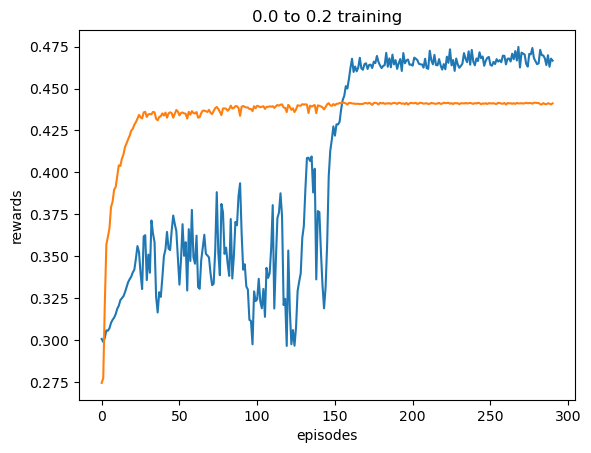

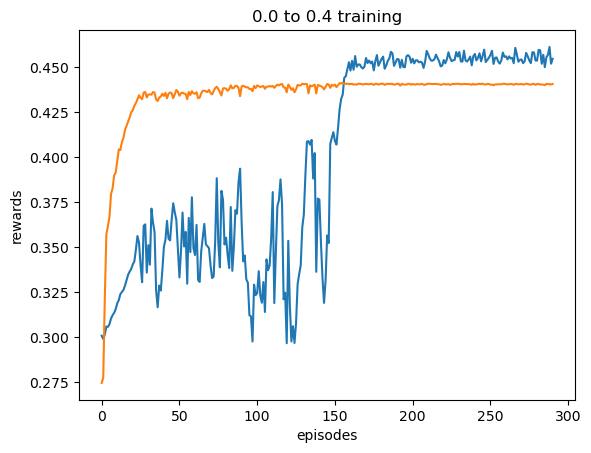

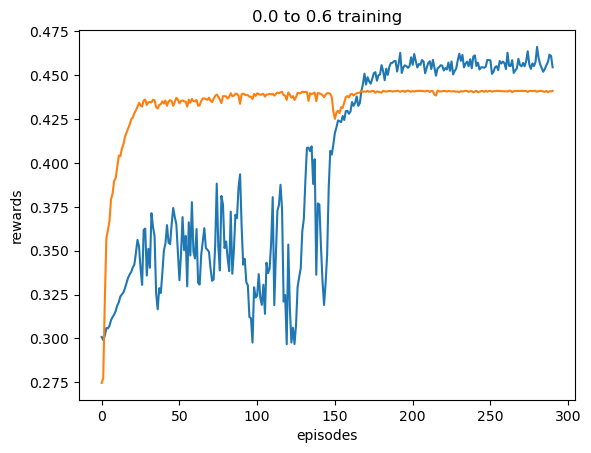

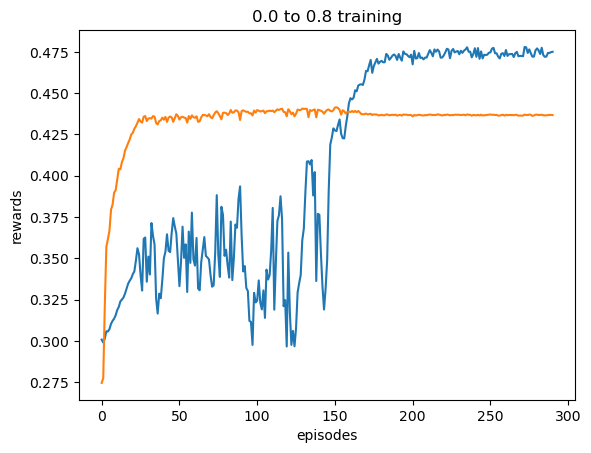

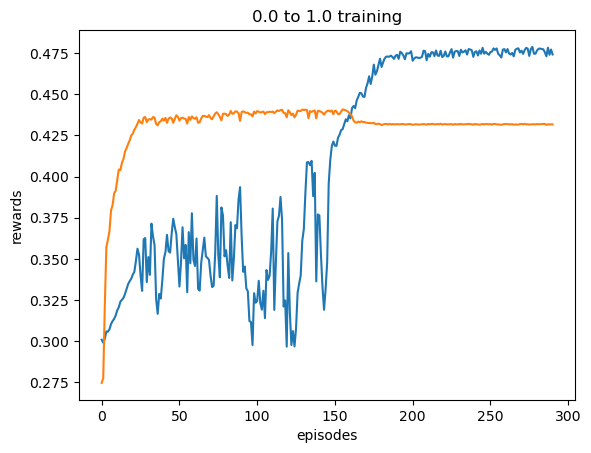

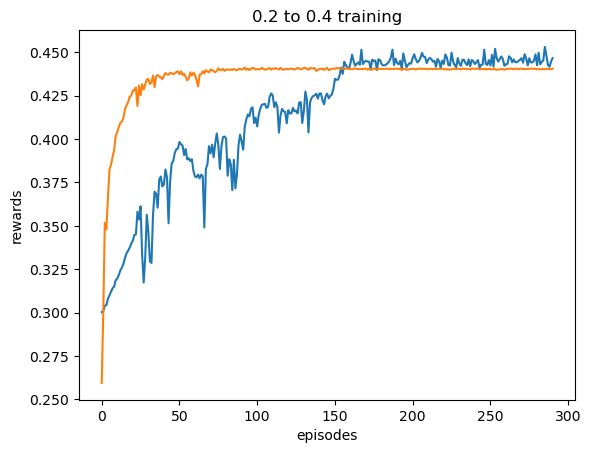

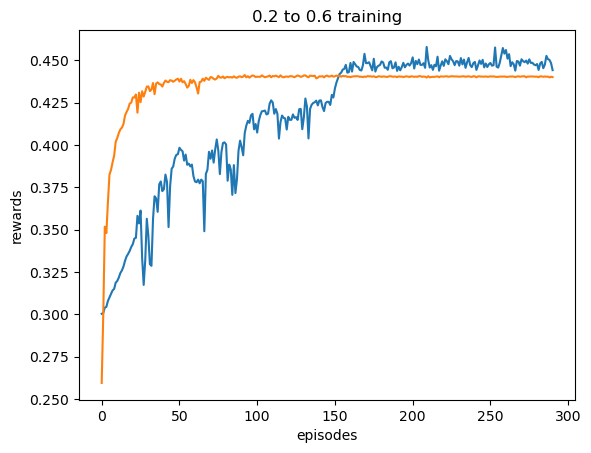

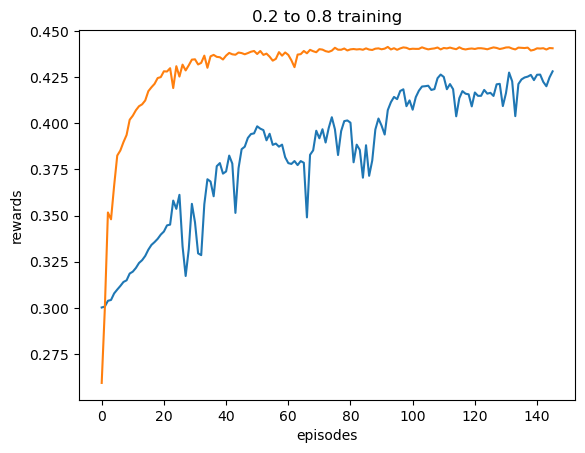

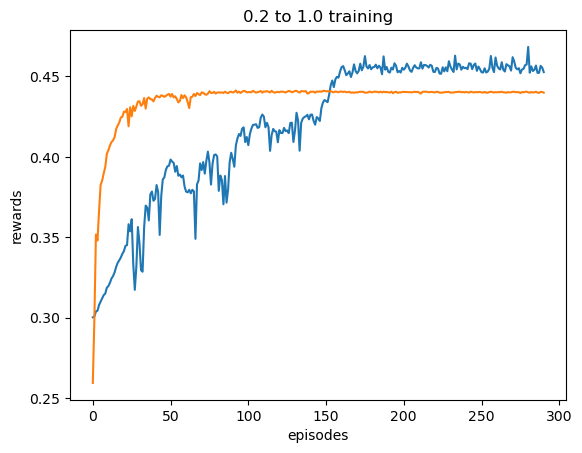

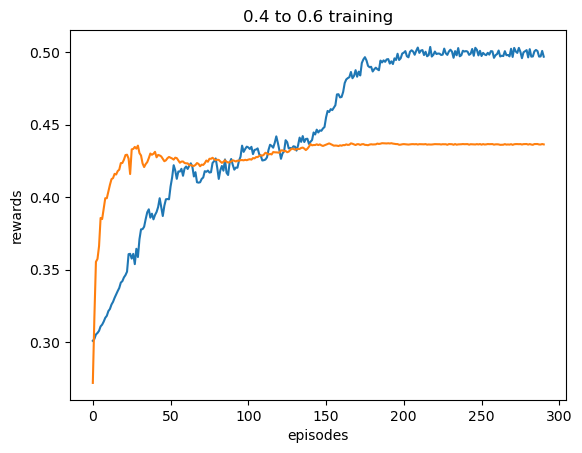

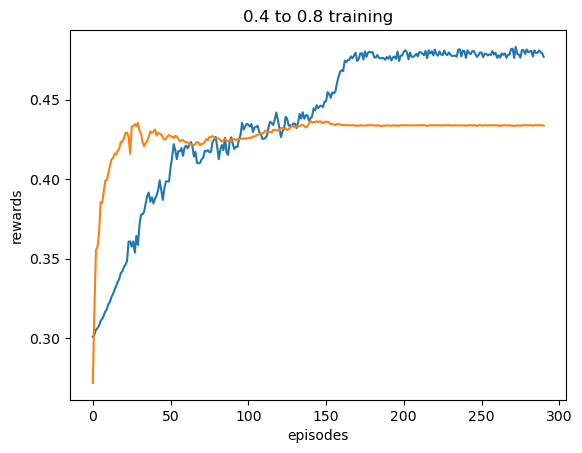

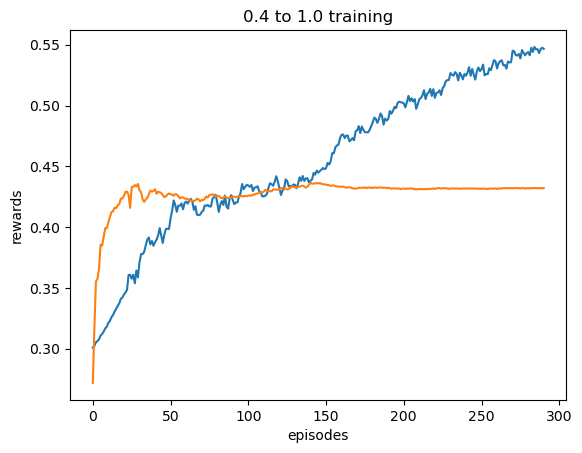

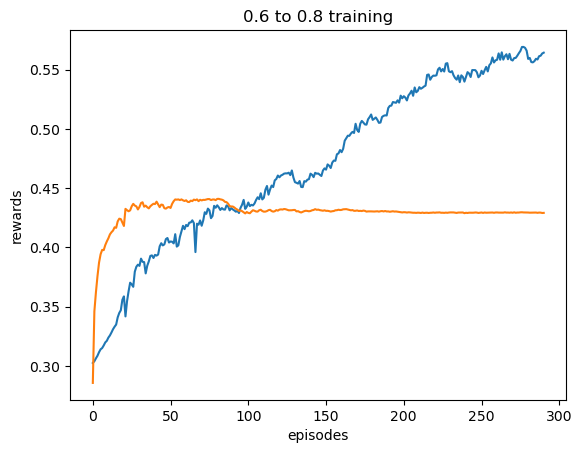

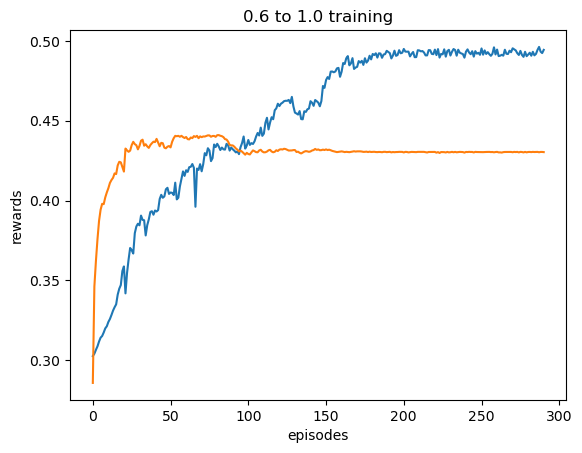

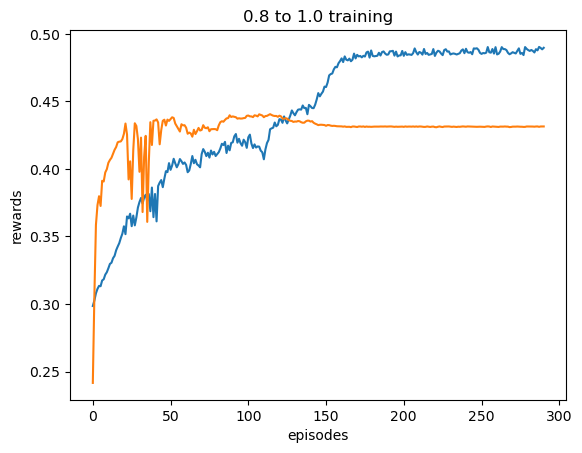

In [43]:
# plot during training

for i, s, t in product([0], [0.0, 0.2, 0.4, 0.6, 0.8, 1.0], [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]):
    if t > s:
        target_train_csv = f'{single_finetune_exp_dir}/{s}_{source_best_runs_per_beta[s]}_e{source_e}_to_{t}_{i}/train_results.csv'
        try:
            train_df = pd.read_csv(target_train_csv)
            ssms, speeds, rewards = train_df['ssm_mean'], train_df['speed_reward_mean'], train_df['reward_mean']
            plt.plot(np.arange(len(ssms)), ssms, label='ssms')
            plt.plot(np.arange(len(speeds)), speeds, label='speeds')
            # plt.plot(np.arange(len(rewards)), rewards, label='rewards')
            
            plt.title(f'{s} to {t} training')
            plt.xlabel('episodes')
            plt.ylabel('rewards')
            # plt.legend(handles=legend_handles, labels=legend_labels, loc='lower right', bbox_to_anchor=(1.5, 0))
            plt.show()
        except Exception as e:
            print(i, s, t)
            print(e)
        


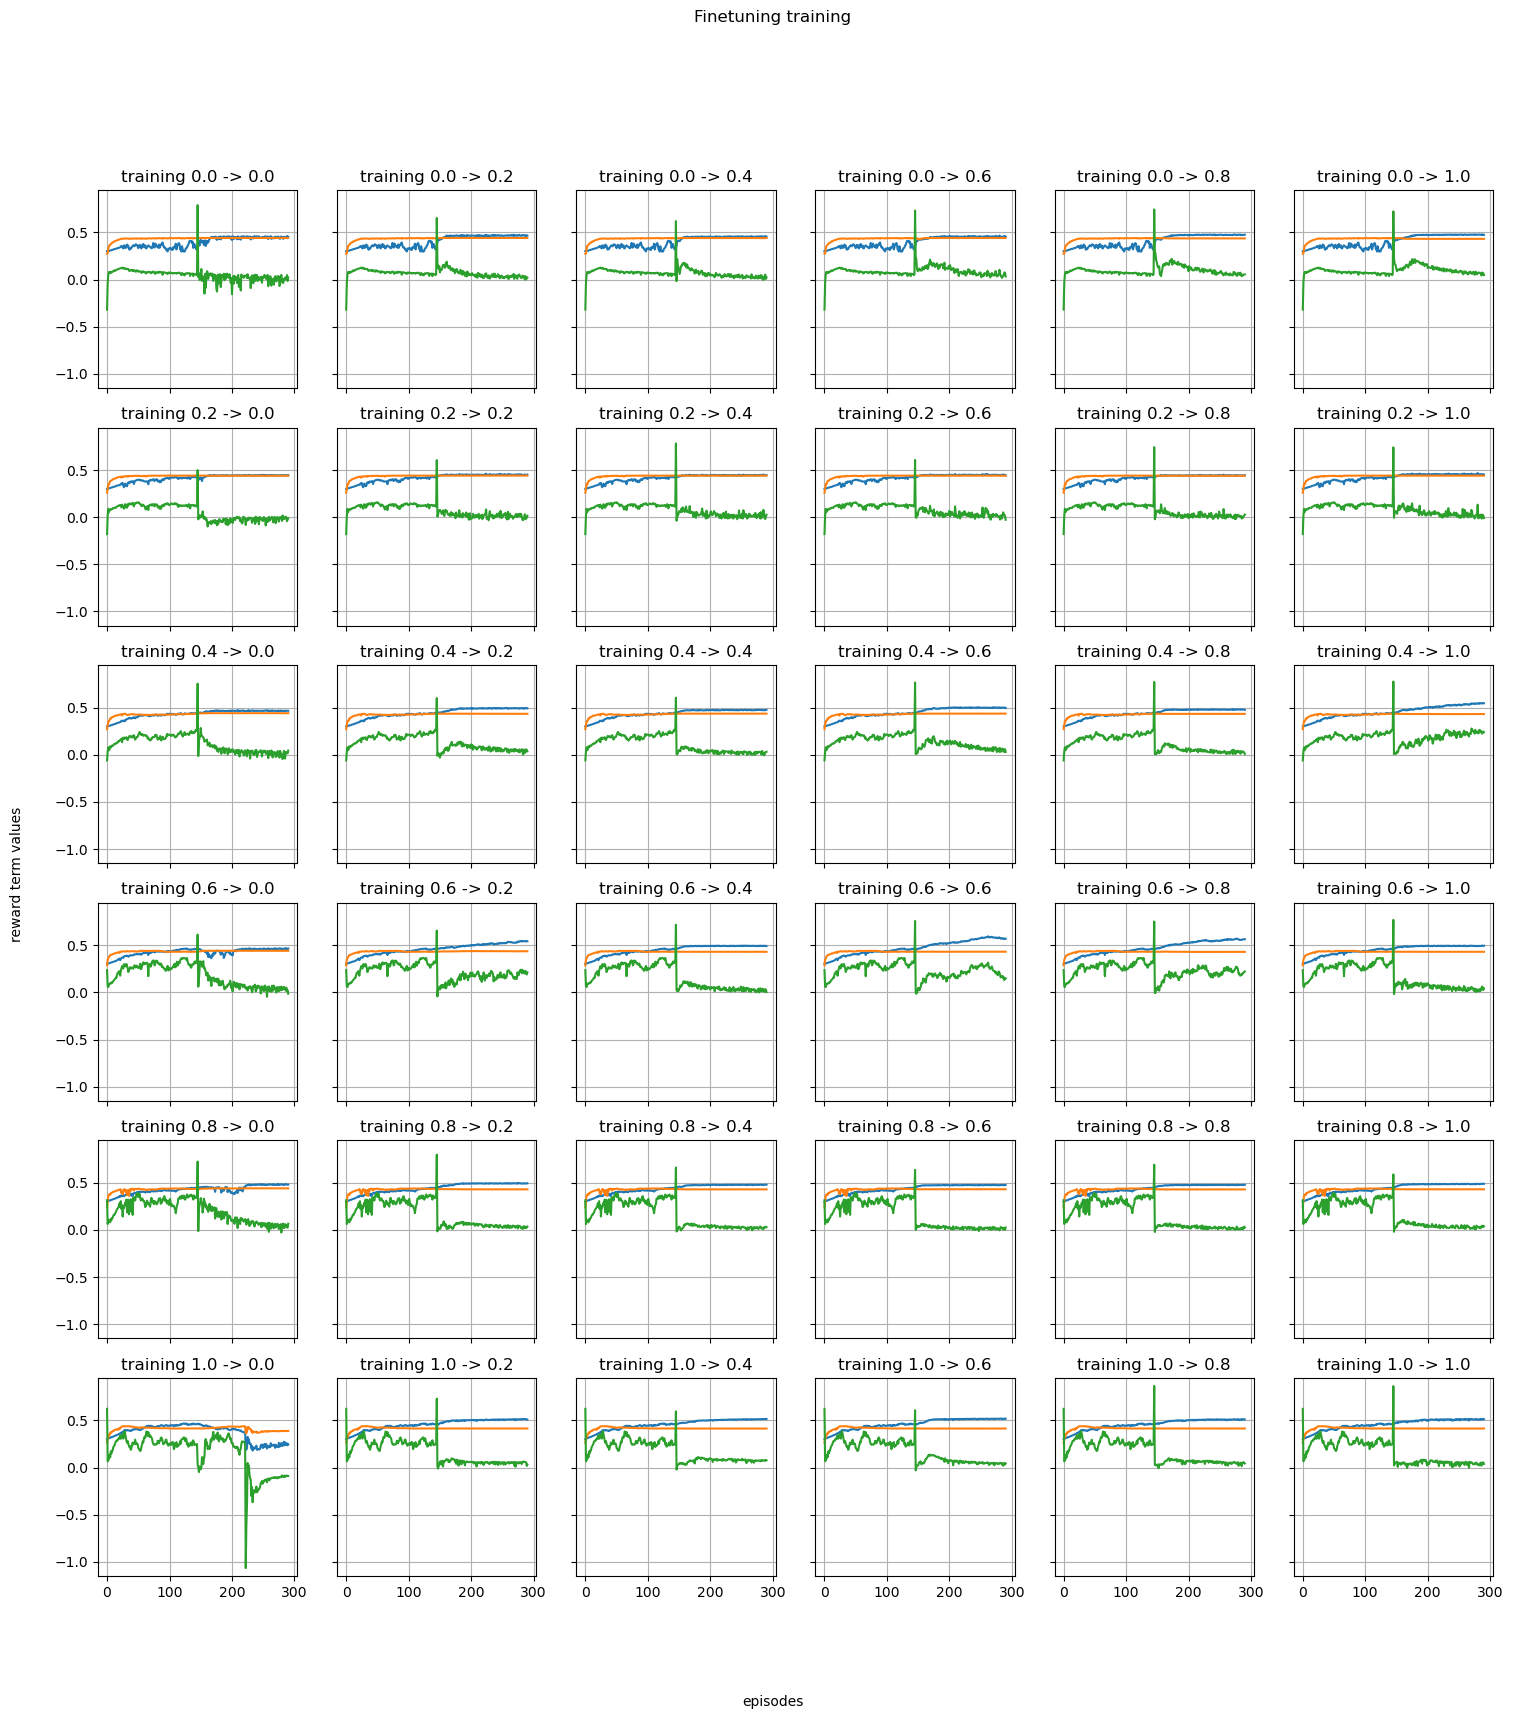

In [57]:
fig, axs = plt.subplots(6, 6, figsize=(18, 18),  sharex=True, sharey=True)
axs_flat = axs.flatten()

for ind, (i, s, t) in enumerate(product([0], [0.0, 0.2, 0.4, 0.6, 0.8, 1.0], [0.0, 0.2, 0.4, 0.6, 0.8, 1.0])):
    target_train_csv = f'{single_finetune_exp_dir}/{s}_{source_best_runs_per_beta[s]}_e{source_e}_to_{t}_{i}/train_results.csv'
    # print(target_train_csv)
    try:
        train_df = pd.read_csv(target_train_csv)
        ssms, speeds, rewards = train_df['ssm_mean'], train_df['speed_reward_mean'], train_df['reward_mean']
        
        ax = axs_flat[ind]
        ax.set_title(f'training {s} -> {t}')
        
        ax.plot(np.arange(len(ssms)), ssms, label='ssms')
        ax.plot(np.arange(len(speeds)), speeds, label='speeds')
        ax.plot(np.arange(len(rewards)), 200*rewards, label='rewards')
        ax.set_ylim(-1.15, 0.95)
        ax.grid(True)
        
    except Exception as e:
        print(i, s, t)
        print(e)
        
fig.text(0.5, 0.04, 'episodes', ha='center', va='center') # xlabel
fig.text(0.08, 0.5, 'reward term values', ha='center', va='center', rotation='vertical') # ylabel
plt.suptitle('Finetuning training')
# plt.tight_layout()
plt.show()

In [ ]:
# plot during training single, mean

In [93]:
#eval

def eval_single_finetune(i_source_target_triples, e):
    output_logs = []
    for i, s, t in i_source_target_triples:
        try:
            source_dir = f'{single_scratch_exp_dir}/{s}_{source_best_runs_per_beta[s]}'
            target_dir = f'{single_finetune_exp_dir}/{s}_{source_best_runs_per_beta[s]}_e{source_e}_to_{t}_{i}'

            output_log_name = f'{target_dir}/eval.log'
            eval_script_text = single_ring_eval_script_text(e=e, beta=t, output_log=output_log_name, run_dir=target_dir, result_save=f'{target_dir}/eval_e{e}.csv', vehicle_info_save=f'{target_dir}/trajectory.npz', scale_ttc=scale, scale_drac=scale)

            eval_script_path = f'{target_dir}/FTeval{s}to{t}_{i}.sh'
            create_file_with_contents(eval_script_path, eval_script_text)
            out, err = submit_job(eval_script_path)
            output_logs += [output_log_name]
        except Exception as e:
            print(i, s, t)
            print(e)
    return output_logs

In [31]:
eval_single_finetune(product([0, 1], [0.0, 0.2, 0.4, 0.6, 0.8, 1.0], [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]), 290)

['pareto/single_ring/finetune/0.0_0_e145_to_0.0_0/eval.log',
 'pareto/single_ring/finetune/0.0_0_e145_to_0.2_0/eval.log',
 'pareto/single_ring/finetune/0.0_0_e145_to_0.4_0/eval.log',
 'pareto/single_ring/finetune/0.0_0_e145_to_0.6_0/eval.log',
 'pareto/single_ring/finetune/0.0_0_e145_to_0.8_0/eval.log',
 'pareto/single_ring/finetune/0.0_0_e145_to_1.0_0/eval.log',
 'pareto/single_ring/finetune/0.2_0_e145_to_0.0_0/eval.log',
 'pareto/single_ring/finetune/0.2_0_e145_to_0.2_0/eval.log',
 'pareto/single_ring/finetune/0.2_0_e145_to_0.4_0/eval.log',
 'pareto/single_ring/finetune/0.2_0_e145_to_0.6_0/eval.log',
 'pareto/single_ring/finetune/0.2_0_e145_to_0.8_0/eval.log',
 'pareto/single_ring/finetune/0.2_0_e145_to_1.0_0/eval.log',
 'pareto/single_ring/finetune/0.4_0_e145_to_0.0_0/eval.log',
 'pareto/single_ring/finetune/0.4_0_e145_to_0.2_0/eval.log',
 'pareto/single_ring/finetune/0.4_0_e145_to_0.4_0/eval.log',
 'pareto/single_ring/finetune/0.4_0_e145_to_0.6_0/eval.log',
 'pareto/single_ring/fin

In [94]:
# eval_single_finetune(product([0], [0.6], [0.2]), 290)
# eval_single_finetune(product([0], [0.8], [0.4]), 290)
# eval_single_finetune(product([1], [0.2], [0.6]), 290)

eval_single_finetune(product([1], [0.8], [0.4, 0.8]), 290)

['pareto/single_ring/finetune/0.8_2_e145_to_0.4_1/eval.log',
 'pareto/single_ring/finetune/0.8_2_e145_to_0.8_1/eval.log']

In [ ]:
#verify eval

In [75]:

    
single_finetune_best_source_per_target = single_get_best_source_per_target([0, 1], [0.0, 0.2, 0.4, 0.6, 0.8, 1.0], [0.0, 0.2, 0.4, 0.6, 0.8, 1.0], single_finetune_exp_dir)

1 0.8 0.4
[Errno 2] No such file or directory: 'pareto/single_ring/finetune/0.8_2_e145_to_0.4_1/eval_e290.csv'
1 0.8 0.8
[Errno 2] No such file or directory: 'pareto/single_ring/finetune/0.8_2_e145_to_0.8_1/eval_e290.csv'


In [ ]:
#plot pareto

##### residual transfer (residual policy)

In [58]:
single_restransfer_exp_dir = f'{single_folder}/residual_transfer'
Path(f'{single_restransfer_exp_dir}').mkdir(parents=True, exist_ok=True)

source_values=[b/10.0 for b in range(11)]
target_values=[b/10.0 for b in range(11)]
run_nums=np.arange(single_num_runs)

seed_np=1228644375
seed_torch=106619
scale=0.8
# n_steps=150

source_e=145
additional_e=145
source_best_runs_per_beta = get_best_run(single_scratch_exp_dir, source_e, beta_values, run_nums)

In [69]:

def train_single_restransfer(i_source_target_triples):
    output_logs = []
    for i, s, t in i_source_target_triples:
        source_dir = f'{single_scratch_exp_dir}/{s}_{source_best_runs_per_beta[s]}'
        target_dir = f'{single_restransfer_exp_dir}/{s}_{source_best_runs_per_beta[s]}_e{source_e}_to_{t}_{i}'
        prep_additional_training(source_dir, target_dir, source_e)
        
        output_log_name = f'{target_dir}/train.log'
        train_script_text = single_ring_train_script_text(output_log=output_log_name, run_dir=target_dir, beta=t, scale_ttc=scale, scale_drac=scale, n_steps=source_e+additional_e, seed_np=seed_np, seed_torch=seed_torch, residual_transfer=True)
        train_script_path = f'{target_dir}/RTtrain{s}to{t}_{i}.sh'
        create_file_with_contents(train_script_path, train_script_text)
        out, err = submit_job(train_script_path)
        output_logs += [output_log_name]
    return output_logs

def train_uppertriangular_single_restransfer(i_source_target_triples):
    output_logs = []
    for i, s, t in i_source_target_triples:
        if t > s:
            source_dir = f'{single_scratch_exp_dir}/{s}_{source_best_runs_per_beta[s]}'
            target_dir = f'{single_restransfer_exp_dir}/{s}_{source_best_runs_per_beta[s]}_e{source_e}_to_{t}_{i}'
            prep_additional_training(source_dir, target_dir, source_e)

            output_log_name = f'{target_dir}/train.log'
            train_script_text = single_ring_train_script_text(output_log=output_log_name, run_dir=target_dir, beta=t, scale_ttc=scale, scale_drac=scale, n_steps=source_e+additional_e, seed_np=seed_np, seed_torch=seed_torch, residual_transfer=True)
            train_script_path = f'{target_dir}/RTtrain{s}to{t}_{i}.sh'
            create_file_with_contents(train_script_path, train_script_text)
            out, err = submit_job(train_script_path)
            output_logs += [output_log_name]
    return output_logs

def train_diagonal_single_restransfer(i_source_target_triples):
    output_logs = []
    for i, s, t in i_source_target_triples:
        if t == s:
            source_dir = f'{single_scratch_exp_dir}/{s}_{source_best_runs_per_beta[s]}'
            target_dir = f'{single_restransfer_exp_dir}/{s}_{source_best_runs_per_beta[s]}_e{source_e}_to_{t}_{i}'
            prep_additional_training(source_dir, target_dir, source_e)

            output_log_name = f'{target_dir}/train.log'
            train_script_text = single_ring_train_script_text(output_log=output_log_name, run_dir=target_dir, beta=t, scale_ttc=scale, scale_drac=scale, n_steps=source_e+additional_e, seed_np=seed_np, seed_torch=seed_torch, residual_transfer=True)
            train_script_path = f'{target_dir}/RTtrain{s}to{t}_{i}.sh'
            create_file_with_contents(train_script_path, train_script_text)
            out, err = submit_job(train_script_path)
            output_logs += [output_log_name]
    return output_logs

def train_lowertriangular_single_restransfer(i_source_target_triples):
    output_logs = []
    for i, s, t in i_source_target_triples:
        if t < s:
            source_dir = f'{single_scratch_exp_dir}/{s}_{source_best_runs_per_beta[s]}'
            target_dir = f'{single_restransfer_exp_dir}/{s}_{source_best_runs_per_beta[s]}_e{source_e}_to_{t}_{i}'
            prep_additional_training(source_dir, target_dir, source_e)

            output_log_name = f'{target_dir}/train.log'
            train_script_text = single_ring_train_script_text(output_log=output_log_name, run_dir=target_dir, beta=t, scale_ttc=scale, scale_drac=scale, n_steps=source_e+additional_e, seed_np=seed_np, seed_torch=seed_torch, residual_transfer=True)
            train_script_path = f'{target_dir}/RTtrain{s}to{t}_{i}.sh'
            create_file_with_contents(train_script_path, train_script_text)
            out, err = submit_job(train_script_path)
            output_logs += [output_log_name]
    return output_logs

In [5]:
train_outputs = train_single_restransfer(product(run_nums, beta_values))
print(train_outputs)

['pareto/single_ring/residual_transfer/0.8_0/train0.8_0.log']


In [96]:
# train_uppertriangular_single_restransfer(product([0], [0.0, 0.2, 0.4, 0.6, 0.8, 1.0], [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]))
# train_diagonal_single_restransfer(product([0], [0.0, 0.2, 0.4, 0.6, 0.8, 1.0], [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]))
train_lowertriangular_single_restransfer(product([0], [0.0, 0.2, 0.4, 0.6, 0.8, 1.0], [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]))
# train_single_restransfer(product([1], [0.0, 0.2, 0.4, 0.6, 0.8, 1.0], [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]))

['pareto/single_ring/residual_transfer/0.2_0_e145_to_0.0_0/train.log',
 'pareto/single_ring/residual_transfer/0.4_0_e145_to_0.0_0/train.log',
 'pareto/single_ring/residual_transfer/0.4_0_e145_to_0.2_0/train.log',
 'pareto/single_ring/residual_transfer/0.6_1_e145_to_0.0_0/train.log',
 'pareto/single_ring/residual_transfer/0.6_1_e145_to_0.2_0/train.log',
 'pareto/single_ring/residual_transfer/0.6_1_e145_to_0.4_0/train.log',
 'pareto/single_ring/residual_transfer/0.8_2_e145_to_0.0_0/train.log',
 'pareto/single_ring/residual_transfer/0.8_2_e145_to_0.2_0/train.log',
 'pareto/single_ring/residual_transfer/0.8_2_e145_to_0.4_0/train.log',
 'pareto/single_ring/residual_transfer/0.8_2_e145_to_0.6_0/train.log',
 'pareto/single_ring/residual_transfer/1.0_2_e145_to_0.0_0/train.log',
 'pareto/single_ring/residual_transfer/1.0_2_e145_to_0.2_0/train.log',
 'pareto/single_ring/residual_transfer/1.0_2_e145_to_0.4_0/train.log',
 'pareto/single_ring/residual_transfer/1.0_2_e145_to_0.6_0/train.log',
 'pare

In [108]:
train_single_restransfer(product([0], [0.4], [0.4, 0.6, 1.0]))
train_single_restransfer(product([0], [0.8], [0.8]))
# train_single_restransfer(product([1], [0.8], [0.8]))

['pareto/single_ring/residual_transfer/0.8_2_e145_to_0.8_0/train.log']

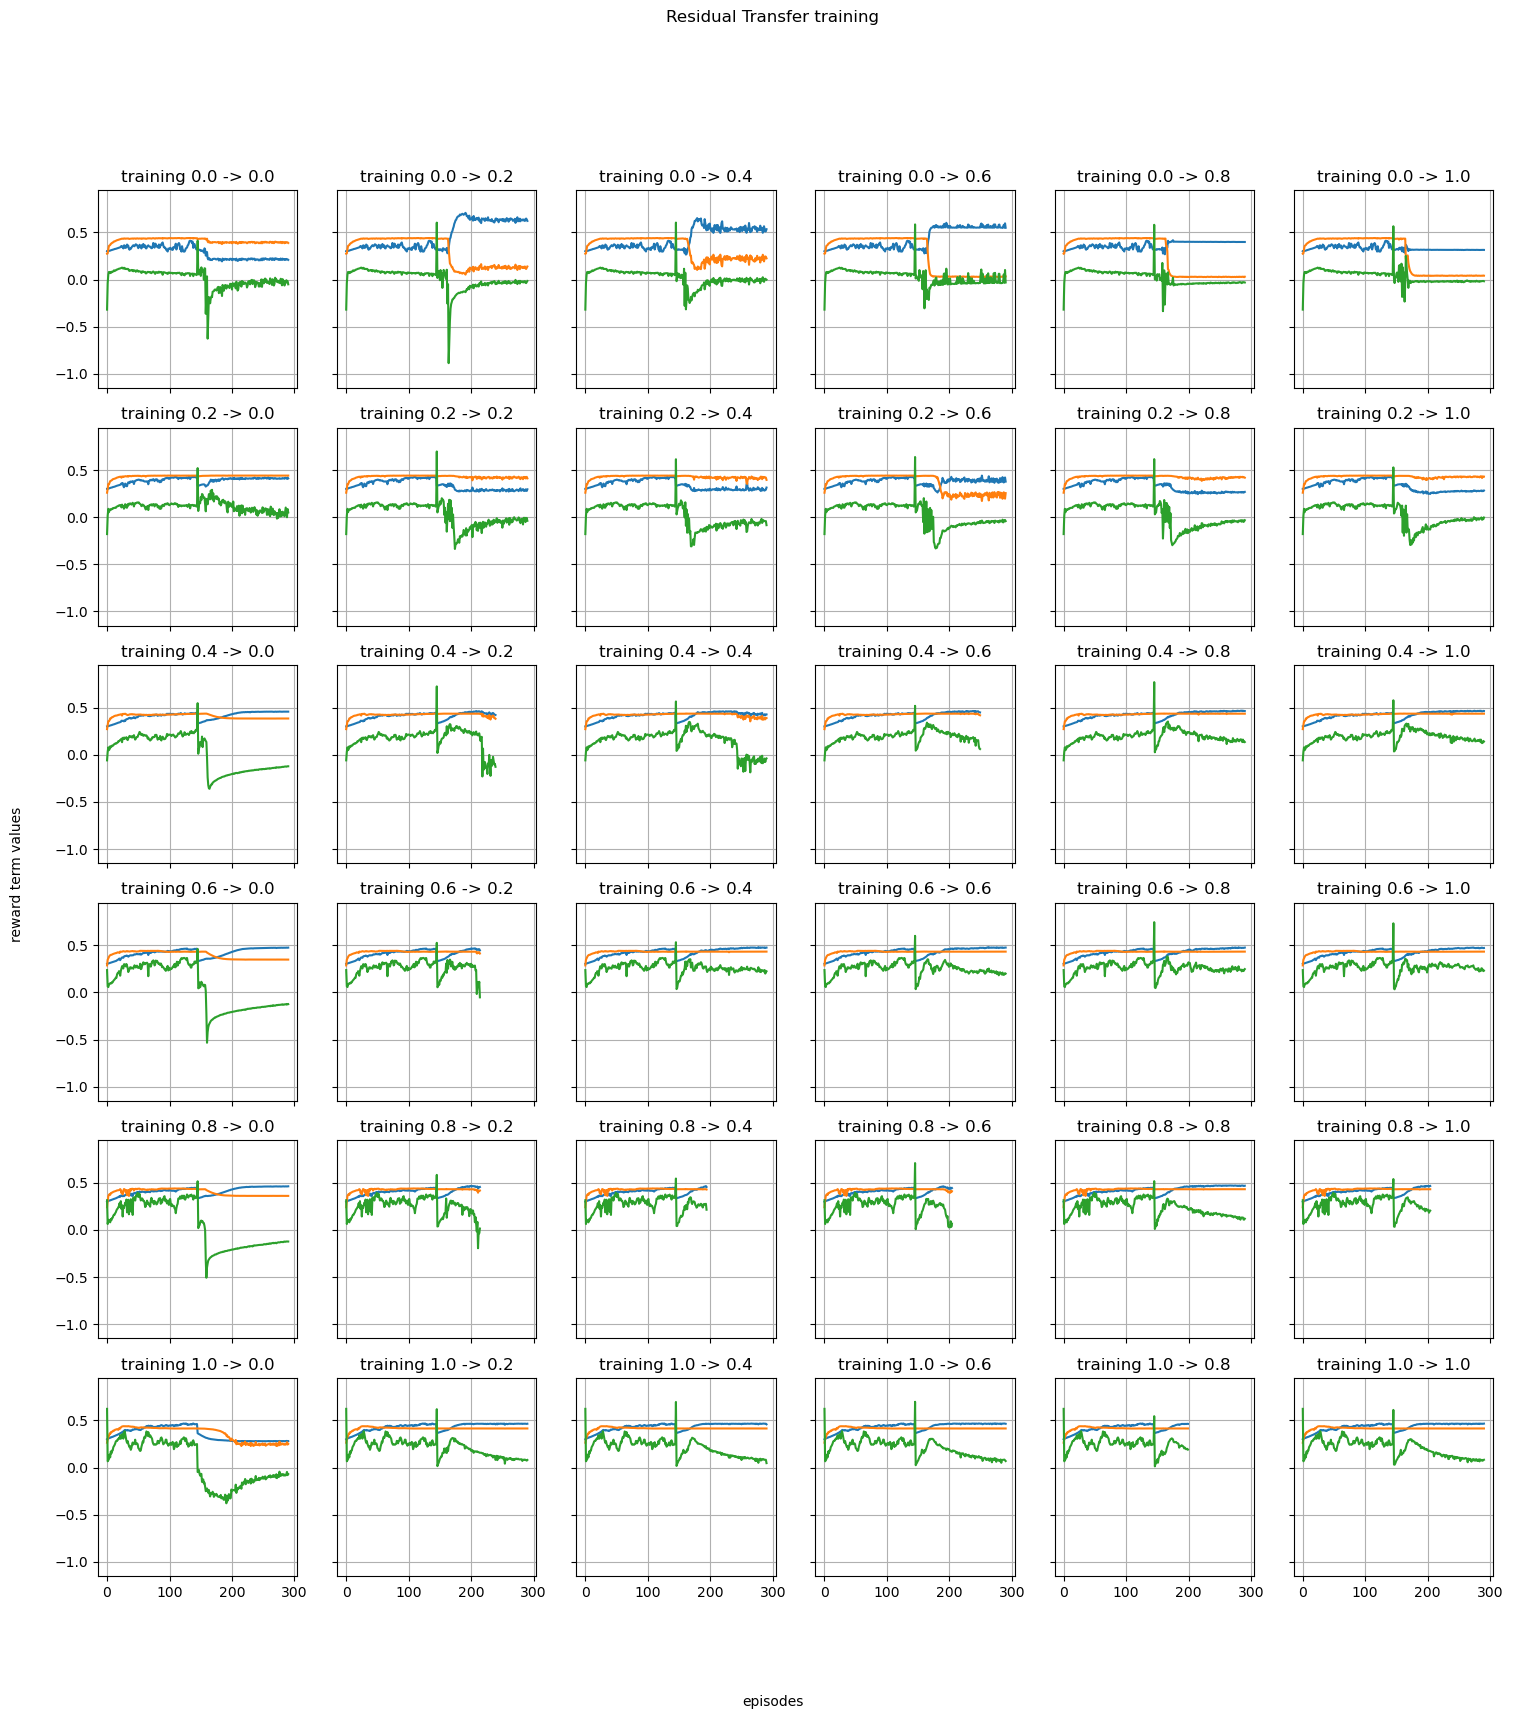

In [11]:
fig, axs = plt.subplots(6, 6, figsize=(18, 18),  sharex=True, sharey=True)
axs_flat = axs.flatten()

for ind, (i, s, t) in enumerate(product([0], [0.0, 0.2, 0.4, 0.6, 0.8, 1.0], [0.0, 0.2, 0.4, 0.6, 0.8, 1.0])):
    target_train_csv = f'{single_restransfer_exp_dir}/{s}_{source_best_runs_per_beta[s]}_e{source_e}_to_{t}_{i}/train_results.csv'
    if os.path.exists(target_train_csv):
        try:
            train_df = pd.read_csv(target_train_csv)
            ssms, speeds, rewards = train_df['ssm_mean'], train_df['speed_reward_mean'], train_df['reward_mean']

            ax = axs_flat[ind]
            ax.set_title(f'training {s} -> {t}')

            ax.plot(np.arange(len(ssms)), ssms, label='ssms')
            ax.plot(np.arange(len(speeds)), speeds, label='speeds')
            ax.plot(np.arange(len(rewards)), 200*rewards, label='rewards')
            ax.set_ylim(-1.15, 0.95)
            ax.grid(True)

        except Exception as exc:
            print(i, s, t)
            print(exc)
        
fig.text(0.5, 0.04, 'episodes', ha='center', va='center') # xlabel
fig.text(0.08, 0.5, 'reward term values', ha='center', va='center', rotation='vertical') # ylabel
plt.suptitle('Residual Transfer training')
# plt.tight_layout()
plt.show()

In [16]:
def eval_single_restransfer(i_source_target_triples, e):
    output_logs = []
    for i, s, t in i_source_target_triples:
        try:
            source_dir = f'{single_scratch_exp_dir}/{s}_{source_best_runs_per_beta[s]}'
            target_dir = f'{single_restransfer_exp_dir}/{s}_{source_best_runs_per_beta[s]}_e{source_e}_to_{t}_{i}'

            output_log_name = f'{target_dir}/eval.log'
            eval_script_text = single_ring_eval_script_text(e=e, beta=t, output_log=output_log_name, run_dir=target_dir, result_save=f'{target_dir}/eval_e{e}.csv', vehicle_info_save=f'{target_dir}/trajectory.npz', residual_transfer=True, scale_ttc=scale, scale_drac=scale)

            eval_script_path = f'{target_dir}/RTeval{s}to{t}_{i}.sh'
            create_file_with_contents(eval_script_path, eval_script_text)
            out, err = submit_job(eval_script_path)
            output_logs += [output_log_name]
        except Exception as exc:
            print(i, s, t)
            print(exc)
    return output_logs

In [7]:
eval_single_restransfer(product([0, 1], [0.0, 0.2, 0.4, 0.6, 0.8, 1.0], [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]), 290)

['pareto/single_ring/residual_transfer/0.0_0_e145_to_0.0_0/eval.log',
 'pareto/single_ring/residual_transfer/0.0_0_e145_to_0.2_0/eval.log',
 'pareto/single_ring/residual_transfer/0.0_0_e145_to_0.4_0/eval.log',
 'pareto/single_ring/residual_transfer/0.0_0_e145_to_0.6_0/eval.log',
 'pareto/single_ring/residual_transfer/0.0_0_e145_to_0.8_0/eval.log',
 'pareto/single_ring/residual_transfer/0.0_0_e145_to_1.0_0/eval.log',
 'pareto/single_ring/residual_transfer/0.2_0_e145_to_0.0_0/eval.log',
 'pareto/single_ring/residual_transfer/0.2_0_e145_to_0.2_0/eval.log',
 'pareto/single_ring/residual_transfer/0.2_0_e145_to_0.4_0/eval.log',
 'pareto/single_ring/residual_transfer/0.2_0_e145_to_0.6_0/eval.log',
 'pareto/single_ring/residual_transfer/0.2_0_e145_to_0.8_0/eval.log',
 'pareto/single_ring/residual_transfer/0.2_0_e145_to_1.0_0/eval.log',
 'pareto/single_ring/residual_transfer/0.4_0_e145_to_0.0_0/eval.log',
 'pareto/single_ring/residual_transfer/0.4_0_e145_to_0.2_0/eval.log',
 'pareto/single_ring

In [17]:
# eval_single_restransfer(product([0], [0.0, 0.2], [0.4, 0.6, 0.8]), 290)
# eval_single_restransfer(product([0], [0.0], [1.0]), 290)
# eval_single_restransfer(product([0], [0.6], [0.8, 1.0]), 290)

# eval_single_restransfer(product([0], [0.8], [1.0]), 290)
# eval_single_restransfer(product([0], [0.4], [0.6]), 290)
# eval_single_restransfer(product([0], [0.4], [1.0]), 290)
# eval_single_restransfer(zip([0]*6, [0.0, 0.2, 0.4, 0.6, 0.8, 1.0], [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]), 290)

# evals to do:
eval_single_restransfer(product([0], [0.2], [0.0]), 290)
eval_single_restransfer(product([0], [0.4], [0.0, 0.2, 0.4, 0.6, 1.0]), 290)
eval_single_restransfer(product([0], [0.6], [0.0, 0.2, 0.4]), 290)
eval_single_restransfer(product([0], [0.8], [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]), 290)
eval_single_restransfer(product([0], [1.0], [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]), 290)

# will also need to rename, retrain, and reeval any failed training runs

['pareto/single_ring/residual_transfer/1.0_2_e145_to_0.0_0/eval.log',
 'pareto/single_ring/residual_transfer/1.0_2_e145_to_0.2_0/eval.log',
 'pareto/single_ring/residual_transfer/1.0_2_e145_to_0.4_0/eval.log',
 'pareto/single_ring/residual_transfer/1.0_2_e145_to_0.6_0/eval.log',
 'pareto/single_ring/residual_transfer/1.0_2_e145_to_0.8_0/eval.log',
 'pareto/single_ring/residual_transfer/1.0_2_e145_to_1.0_0/eval.log']

In [39]:

# pick best 

single_restransfer_best_source_per_target = single_get_best_source_per_target([0, 1], [0.0, 0.2, 0.4, 0.6, 0.8, 1.0], [0.0, 0.2, 0.4, 0.6, 0.8, 1.0], single_restransfer_exp_dir)

##### restransfer with lower learning rate

In [62]:
single_restransfer_lr_exp_dir = f'{single_folder}/residual_transfer_lr'
Path(f'{single_restransfer_lr_exp_dir}').mkdir(parents=True, exist_ok=True)

source_values=[b/10.0 for b in range(11)]
target_values=[b/10.0 for b in range(11)]
run_nums=np.arange(single_num_runs)

seed_np=1228644375
seed_torch=106619
scale=0.8
# n_steps=150

source_e=145
additional_e=145
lr=0.5e-4
source_best_runs_per_beta = get_best_run(single_scratch_exp_dir, source_e, beta_values, run_nums)

In [117]:
def train_single_restransfer_lr(i_source_target_triples):
    output_logs = []
    for i, s, t in i_source_target_triples:
        source_dir = f'{single_scratch_exp_dir}/{s}_{source_best_runs_per_beta[s]}'
        target_dir = f'{single_restransfer_lr_exp_dir}/{s}_{source_best_runs_per_beta[s]}_e{source_e}_to_{t}_{i}'
        prep_additional_training(source_dir, target_dir, source_e)
        
        output_log_name = f'{target_dir}/train.log'
        train_script_text = single_ring_train_script_text(output_log=output_log_name, run_dir=target_dir, beta=t, scale_ttc=scale, scale_drac=scale, n_steps=source_e+additional_e, seed_np=seed_np, seed_torch=seed_torch, lr=lr, residual_transfer=True)
        train_script_path = f'{target_dir}/RTlr_train{s}to{t}_{i}.sh'
        create_file_with_contents(train_script_path, train_script_text)
        out, err = submit_job(train_script_path)
        output_logs += [output_log_name]
    return output_logs

In [120]:
train_single_restransfer_lr(product([0], [0.0, 0.2, 0.4, 0.6, 0.8, 1.0], [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]))

['pareto/single_ring/residual_transfer_lr/0.0_0_e145_to_0.0_0/train.log',
 'pareto/single_ring/residual_transfer_lr/0.0_0_e145_to_0.2_0/train.log',
 'pareto/single_ring/residual_transfer_lr/0.0_0_e145_to_0.4_0/train.log',
 'pareto/single_ring/residual_transfer_lr/0.0_0_e145_to_0.6_0/train.log',
 'pareto/single_ring/residual_transfer_lr/0.0_0_e145_to_0.8_0/train.log',
 'pareto/single_ring/residual_transfer_lr/0.0_0_e145_to_1.0_0/train.log',
 'pareto/single_ring/residual_transfer_lr/0.2_0_e145_to_0.0_0/train.log',
 'pareto/single_ring/residual_transfer_lr/0.2_0_e145_to_0.2_0/train.log',
 'pareto/single_ring/residual_transfer_lr/0.2_0_e145_to_0.4_0/train.log',
 'pareto/single_ring/residual_transfer_lr/0.2_0_e145_to_0.6_0/train.log',
 'pareto/single_ring/residual_transfer_lr/0.2_0_e145_to_0.8_0/train.log',
 'pareto/single_ring/residual_transfer_lr/0.2_0_e145_to_1.0_0/train.log',
 'pareto/single_ring/residual_transfer_lr/0.4_0_e145_to_0.0_0/train.log',
 'pareto/single_ring/residual_transfer

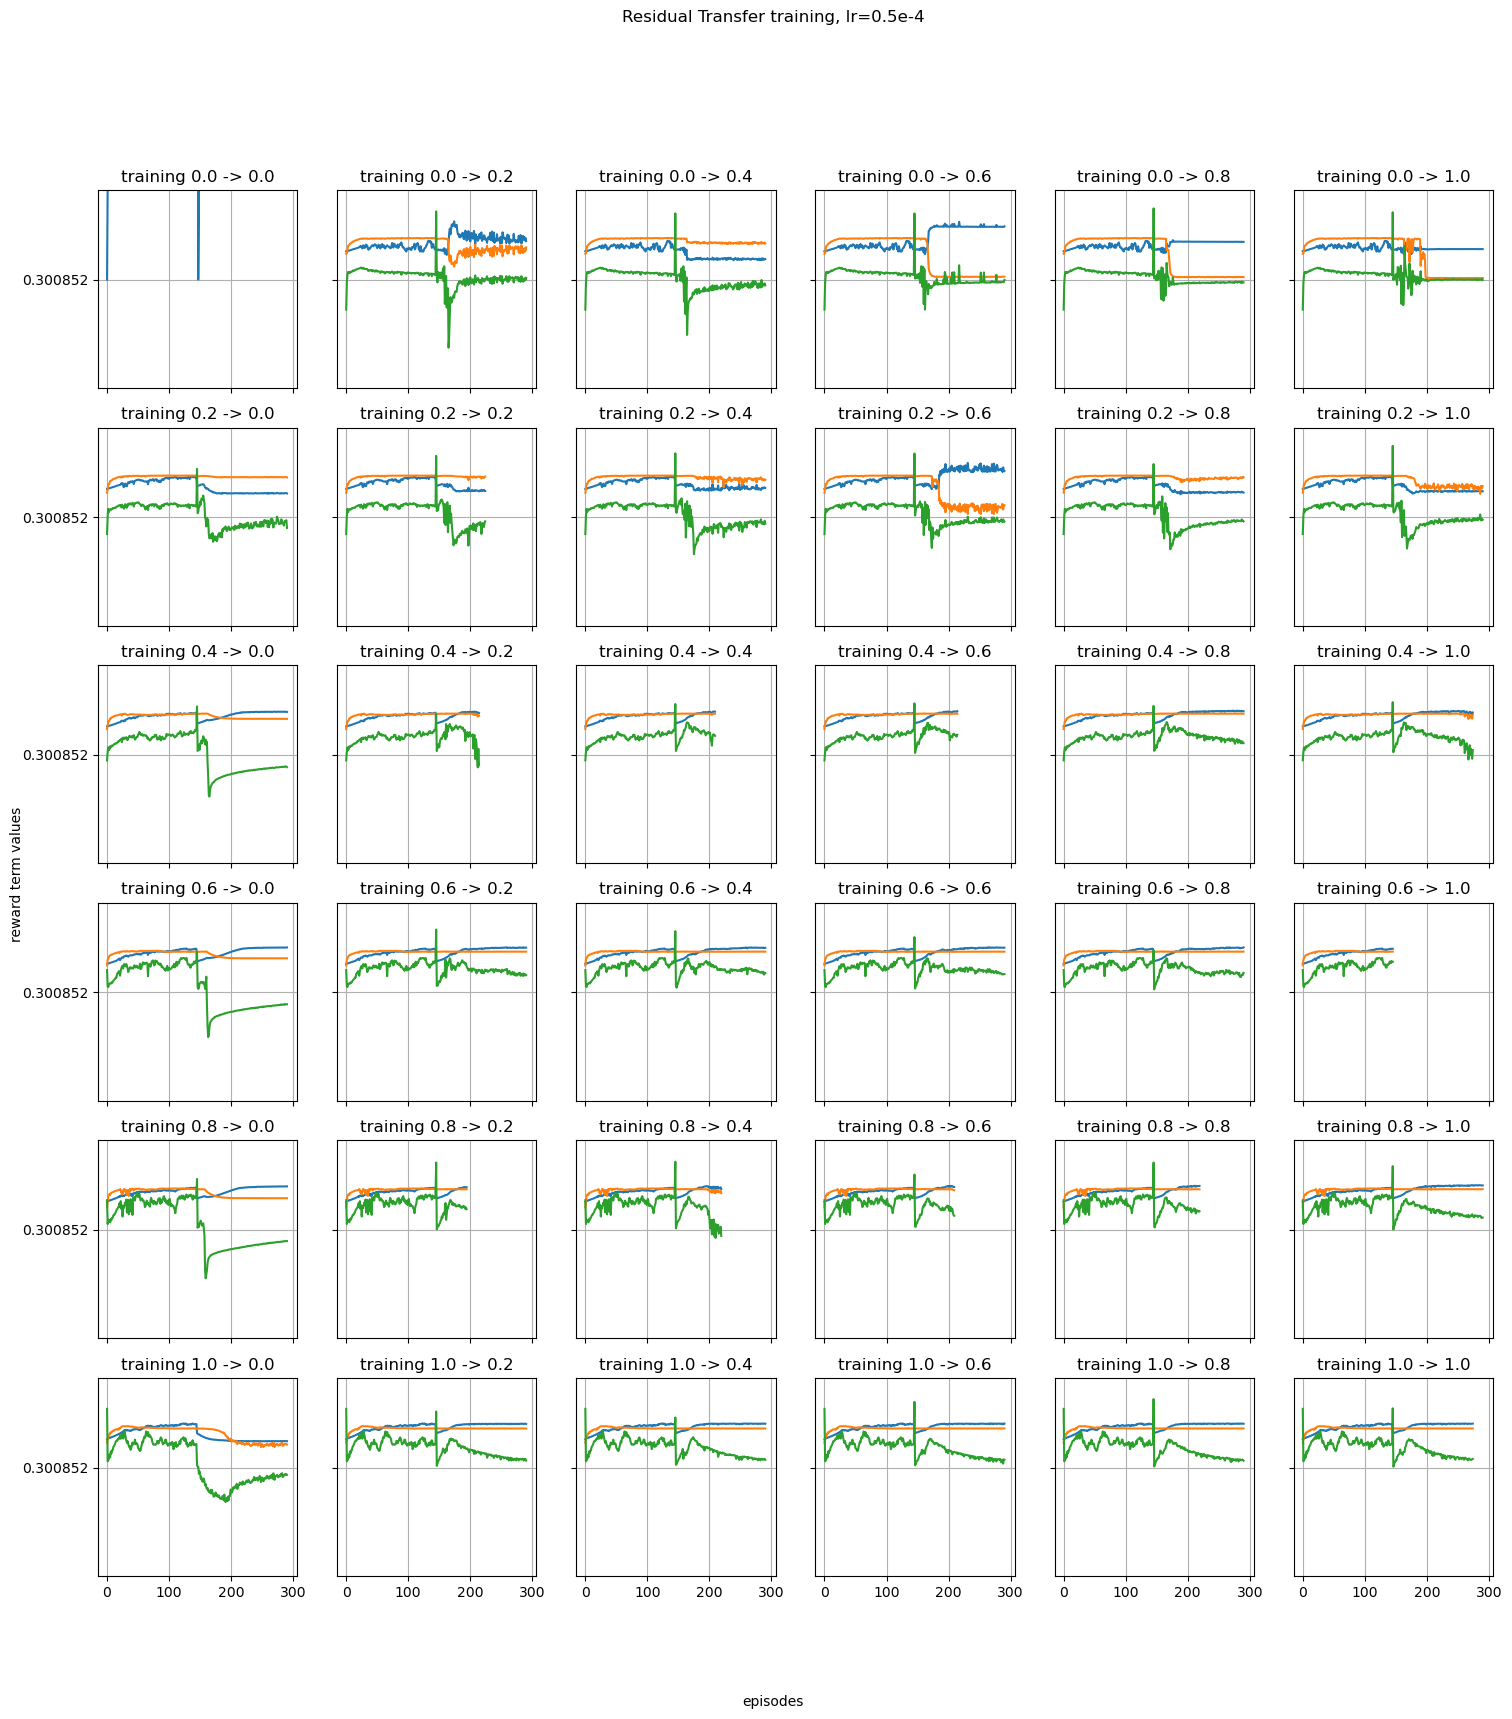

In [26]:
fig, axs = plt.subplots(6, 6, figsize=(18, 18),  sharex=True, sharey=True)
axs_flat = axs.flatten()

for ind, (i, s, t) in enumerate(product([0], [0.0, 0.2, 0.4, 0.6, 0.8, 1.0], [0.0, 0.2, 0.4, 0.6, 0.8, 1.0])):
    target_train_csv = f'{single_restransfer_lr_exp_dir}/{s}_{source_best_runs_per_beta[s]}_e{source_e}_to_{t}_{i}/train_results.csv'
    if os.path.exists(target_train_csv):
        try:
            train_df = pd.read_csv(target_train_csv)
            ssms, speeds, rewards = train_df['ssm_mean'], train_df['speed_reward_mean'], train_df['reward_mean']

            ax = axs_flat[ind]
            ax.set_title(f'training {s} -> {t}')

            ax.plot(np.arange(len(ssms)), ssms, label='ssms')
            ax.plot(np.arange(len(speeds)), speeds, label='speeds')
            ax.plot(np.arange(len(rewards)), 200*rewards, label='rewards')
            ax.set_ylim(-1.15, 0.95)
            ax.grid(True)

        except Exception as exc:
            print(i, s, t)
            print(exc)
        
fig.text(0.5, 0.04, 'episodes', ha='center', va='center') # xlabel
fig.text(0.08, 0.5, 'reward term values', ha='center', va='center', rotation='vertical') # ylabel
plt.suptitle('Residual Transfer training, lr=0.5e-4')
# plt.tight_layout()
plt.show()

In [19]:
def eval_single_restransfer_lr(i_source_target_triples, e):
    output_logs = []
    for i, s, t in i_source_target_triples:
        try:
            source_dir = f'{single_scratch_exp_dir}/{s}_{source_best_runs_per_beta[s]}'
            target_dir = f'{single_restransfer_lr_exp_dir}/{s}_{source_best_runs_per_beta[s]}_e{source_e}_to_{t}_{i}'

            output_log_name = f'{target_dir}/eval.log'
            eval_script_text = single_ring_eval_script_text(e=e, beta=t, output_log=output_log_name, run_dir=target_dir, result_save=f'{target_dir}/eval_e{e}.csv', vehicle_info_save=f'{target_dir}/trajectory.npz', residual_transfer=True, scale_ttc=scale, scale_drac=scale)

            eval_script_path = f'{target_dir}/RTlr_eval{s}to{t}_{i}.sh'
            create_file_with_contents(eval_script_path, eval_script_text)
            out, err = submit_job(eval_script_path)
            output_logs += [output_log_name]
        except Exception as exc:
            print(i, s, t)
            print(exc)
    return output_logs

In [ ]:
eval_single_restransfer_lr(product([0], [0.0, 0.2, 0.4, 0.6, 0.8, 1.0], [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]), 290)

['pareto/single_ring/residual_transfer_lr/0.0_0_e145_to_0.0_0/eval.log',
 'pareto/single_ring/residual_transfer_lr/0.0_0_e145_to_0.2_0/eval.log',
 'pareto/single_ring/residual_transfer_lr/0.0_0_e145_to_0.4_0/eval.log',
 'pareto/single_ring/residual_transfer_lr/0.0_0_e145_to_0.6_0/eval.log',
 'pareto/single_ring/residual_transfer_lr/0.0_0_e145_to_0.8_0/eval.log',
 'pareto/single_ring/residual_transfer_lr/0.0_0_e145_to_1.0_0/eval.log',
 'pareto/single_ring/residual_transfer_lr/0.2_0_e145_to_0.0_0/eval.log',
 'pareto/single_ring/residual_transfer_lr/0.2_0_e145_to_0.2_0/eval.log',
 'pareto/single_ring/residual_transfer_lr/0.2_0_e145_to_0.4_0/eval.log',
 'pareto/single_ring/residual_transfer_lr/0.2_0_e145_to_0.6_0/eval.log',
 'pareto/single_ring/residual_transfer_lr/0.2_0_e145_to_0.8_0/eval.log',
 'pareto/single_ring/residual_transfer_lr/0.2_0_e145_to_1.0_0/eval.log',
 'pareto/single_ring/residual_transfer_lr/0.4_0_e145_to_0.0_0/eval.log',
 'pareto/single_ring/residual_transfer_lr/0.4_0_e14

##### MRTL

In [59]:
single_mrtl_exp_dir = f'{single_folder}/MRTL'
Path(f'{single_mrtl_exp_dir}').mkdir(parents=True, exist_ok=True)

beta_values=[b/10.0 for b in range(11)]
run_nums=np.arange(single_num_runs)

seed_np=1228644375
seed_torch=106619
scale=0.8
n_steps=150


In [37]:
def train_single_mrtl_nominal(runs, n_steps=n_steps):
    output_logs = []
    for i in runs:
        nominal_dir = f'{single_mrtl_exp_dir}/nominal_{i}'
        Path(f'{nominal_dir}').mkdir(parents=True, exist_ok=True)
        
        output_log_name = f'{nominal_dir}/train.log'
        worker_kwargs = [{'beta':x} for x in beta_values]
        n_workers=33
        n_rollouts_per_step=33
        
        train_script_text = single_ring_train_script_text(
            output_log=output_log_name, 
            run_dir=nominal_dir, 
            worker_kwargs=worker_kwargs,
            n_workers=n_workers,
            n_rollouts_per_step=n_rollouts_per_step,
            beta=False,
            scale_ttc=scale, 
            scale_drac=scale, 
            n_steps=n_steps,
            seed_np=seed_np, 
            seed_torch=seed_torch,
            mrtl=True,
        )
        
        print(train_script_text)
        
        train_script_path = f'{nominal_dir}/MRTL_train_{i}.sh'
        create_file_with_contents(train_script_path, train_script_text)
        out, err = submit_job(train_script_path)
        output_logs += [output_log_name]
    return output_logs

# train residual: just pass in one beta, or train beta contextually too

def train_single_mrtl_residual_indiv(nom_runs, nom_e, beta_values, res_runs, extra_steps):
    output_logs = []
    for i in nom_runs:
        for j in res_runs:
            for b in beta_values:
                residual_dir = f'{single_mrtl_exp_dir}/residual_nom{i}_beta{b}_{j}'
                Path(f'{residual_dir}').mkdir(parents=True, exist_ok=True)
                
                nominal_dir = f'{single_mrtl_exp_dir}/nominal_{i}'

                #prep additional training!!!
                prep_additional_training(nominal_dir, residual_dir, nom_e)


                output_log_name = f'{residual_dir}/train.log'
                # worker_kwargs = [{'beta':x} for x in beta_values]
                # n_workers=33
                # n_rollouts_per_step=33

                train_script_text = single_ring_train_script_text(
                    output_log=output_log_name, 
                    run_dir=residual_dir, 
                    # worker_kwargs=worker_kwargs,
                    # n_workers=n_workers,
                    # n_rollouts_per_step=n_rollouts_per_step,
                    beta=b,
                    scale_ttc=scale, 
                    scale_drac=scale, 
                    n_steps=nom_e+extra_steps,
                    seed_np=seed_np, 
                    seed_torch=seed_torch,
                    residual_transfer=True,
                    mrtl=True,
                )

                # print(train_script_text)

                train_script_path = f'{residual_dir}/MRTL_train_beta{b}_res{i}.sh'
                create_file_with_contents(train_script_path, train_script_text)
                out, err = submit_job(train_script_path)
                output_logs += [output_log_name]
    return output_logs


def train_single_mrtl_residual_all_context(nom_runs, nom_e, res_runs, extra_steps):
    output_logs = []
    for i in nom_runs:
        for j in res_runs:
            residual_dir = f'{single_mrtl_exp_dir}/residual_nom{i}_{j}'
            Path(f'{residual_dir}').mkdir(parents=True, exist_ok=True)

            nominal_dir = f'{single_mrtl_exp_dir}/nominal_{i}'

            #prep additional training!!!
            prep_additional_training(nominal_dir, residual_dir, nom_e)


            output_log_name = f'{residual_dir}/train.log'
            worker_kwargs = [{'beta':x} for x in beta_values]
            n_workers=33
            n_rollouts_per_step=33

            train_script_text = single_ring_train_script_text(
                output_log=output_log_name, 
                run_dir=residual_dir, 
                worker_kwargs=worker_kwargs,
                n_workers=n_workers,
                n_rollouts_per_step=n_rollouts_per_step,
                # beta=b,
                scale_ttc=scale, 
                scale_drac=scale, 
                n_steps=nom_e+extra_steps,
                seed_np=seed_np, 
                seed_torch=seed_torch,
                residual_transfer=True,
                mrtl=True,
            )

            print(train_script_text)

            train_script_path = f'{residual_dir}/MRTL_train_res{i}.sh'
            create_file_with_contents(train_script_path, train_script_text)
            out, err = submit_job(train_script_path)
            output_logs += [output_log_name]
    return output_logs



In [27]:
nominals = train_single_mrtl_nominal([4], 1000)
# residuals = train_single_mrtl_residual_indiv([2])

#!/bin/sh

#SBATCH -o pareto/single_ring/MRTL/nominal_4/train.log
#SBATCH --time=72:00:00          # total run time limit (HH:MM:SS)
#SBATCH -c 33

python $F/ring.py pareto/single_ring/MRTL/nominal_4 "worker_kwargs=[{'beta': 0.0}, {'beta': 0.1}, {'beta': 0.2}, {'beta': 0.3}, {'beta': 0.4}, {'beta': 0.5}, {'beta': 0.6}, {'beta': 0.7}, {'beta': 0.8}, {'beta': 0.9}, {'beta': 1.0}]" "n_workers=33" "n_rollouts_per_step=33" "warmup_steps=2000" "skip_stat_steps=5000" "horizon=5000" "global_reward=True" "n_steps=1000" "alg='TRPO'" "use_critic=False" "gamma=0.9995" "beta=False" "scale_ttc=0.8" "scale_drac=0.8" "seed_np=1228644375" "seed_torch=106619" "residual_transfer=False" "lr=0.0001" "wb=False" "tb=False" 


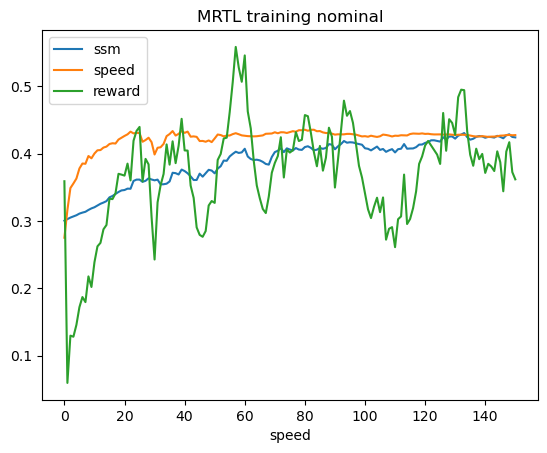

In [9]:
def plot_train_mrtl(runs=[2], dir_func=lambda i: f'{single_mrtl_exp_dir}/nominal_{i}', title='MRTL training nominal'):
    for i in runs:
        # nominal_dir = f'{single_mrtl_exp_dir}/nominal_{i}'
        try:
            df = pd.read_csv(f'{dir_func(i)}/train_results.csv')
            plt.plot(df['ssm_mean'], label='ssm')
            plt.plot(df['speed_reward_mean'], label='speed')
            plt.plot(400*df['reward_mean'], label='reward')
            plt.title(title)
            plt.xlabel('ssm')
            plt.xlabel('speed')
            plt.legend()
            plt.show()
        except Exception as exc:
            print(i, exc)

plot_train_mrtl()

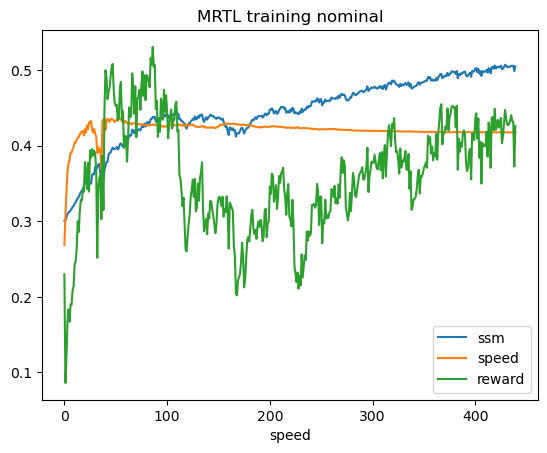

In [9]:
plot_train_mrtl([3])

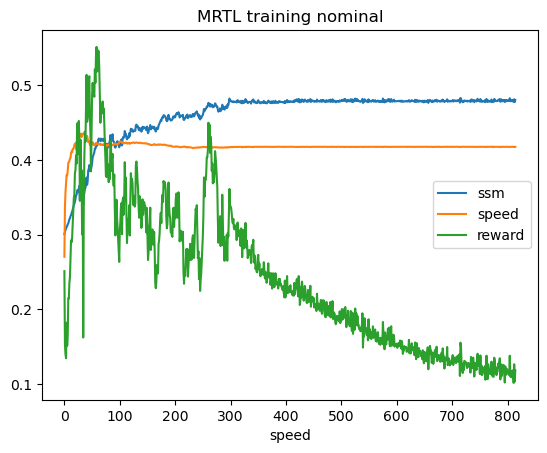

In [10]:
plot_train_mrtl([4])

In [36]:
def eval_single_mrtl_nominal(runs, beta_values, e):
    output_logs = []
    for i in runs:
        nominal_dir = f'{single_mrtl_exp_dir}/nominal_{i}'
        try:
            for b in beta_values:
                output_log_name = f'{nominal_dir}/eval_beta{b}.log'
                eval_script_text = single_ring_eval_script_text(e=e, beta=b, output_log=output_log_name, run_dir=nominal_dir, result_save=f'{nominal_dir}/eval_beta{b}_e{e}.csv', vehicle_info_save=f'{nominal_dir}/trajectory.npz', scale_ttc=scale, scale_drac=scale, mrtl=True)
                eval_script_path = f'{nominal_dir}/RTeval_beta{b}_i.sh'
                create_file_with_contents(eval_script_path, eval_script_text)
                out, err = submit_job(eval_script_path)
                output_logs += [output_log_name]
        except Exception as exc:
            print(i, b)
            print(exc)
    return output_logs


def eval_single_mrtl_residual_indiv(nom_runs, resid_runs, beta_values, e):
    output_logs = []
    for i in nom_runs:
        for j in resid_runs:
            for b in beta_values:
                residual_dir = f'{single_mrtl_exp_dir}/residual_nom{i}_beta{b}_{j}'
                try:
                    output_log_name = f'{residual_dir}/eval.log'
                    eval_script_text = single_ring_eval_script_text(e=e, beta=b, output_log=output_log_name, run_dir=residual_dir, result_save=f'{residual_dir}/eval_e{e}.csv', vehicle_info_save=f'{residual_dir}/trajectory.npz', scale_ttc=scale, scale_drac=scale, mrtl=True, residual_transfer=True)
                    eval_script_path = f'{residual_dir}/MTSReval_{b}beta_nom{i}_{j}.sh'
                    create_file_with_contents(eval_script_path, eval_script_text)
                    out, err = submit_job(eval_script_path)
                    output_logs += [output_log_name]
                except Exception as exc:
                    print(i, j, b)
                    print(exc)
    return output_logs


def eval_single_mrtl_residual_all_context(nom_runs, resid_runs, beta_values, e):
    output_logs = []
    for i in nom_runs:
        for j in resid_runs:
            residual_dir = f'{single_mrtl_exp_dir}/residual_nom{i}_{j}'
            try:
                for b in beta_values:
                    output_log_name = f'{residual_dir}/eval_beta{b}.log'
                    eval_script_text = single_ring_eval_script_text(e=e, beta=b, output_log=output_log_name, run_dir=residual_dir, result_save=f'{residual_dir}/eval_beta{b}_e{e}.csv', vehicle_info_save=f'{residual_dir}/trajectory_beta{b}.npz', scale_ttc=scale, scale_drac=scale, mrtl=True, residual_transfer=True)
                    eval_script_path = f'{residual_dir}/MRTLeval_{b}beta_{i}.sh'
                    create_file_with_contents(eval_script_path, eval_script_text)
                    out, err = submit_job(eval_script_path)
                    output_logs += [output_log_name]
            except Exception as exc:
                print(i, j)
                print(exc)
    return output_logs


In [12]:
nom_evals = eval_single_mrtl_nominal([3], [b/10.0 for b in range(11)], 435)

In [64]:
def get_mrtl_evals(runs, beta_values, e, res_runs=[], csv_dir=lambda i, b, e, j=0: f'{single_mrtl_exp_dir}/nominal_{i}/eval_beta{b}_e{e}.csv'):
    xs, ys, labels = [], [], []
    for i in runs:
        for b in beta_values:
            if res_runs:
                for j in res_runs:
                    try:
                        df = pd.read_csv(csv_dir(i, b, e, j))
                        xs += [np.mean(df['ssm_mean'])]
                        ys += [np.mean(df['speed_reward_mean'])]
                        labels += [f'{b}']
                    except Exception as exc:
                        print(i, b, exc)
            else:      
                try:
                    df = pd.read_csv(csv_dir(i, b, e))
                    xs += [np.mean(df['ssm_mean'])]
                    ys += [np.mean(df['speed_reward_mean'])]
                    labels += [f'{b}']
                except Exception as exc:
                    print(i, b, exc)
    return xs, ys, labels
            
                

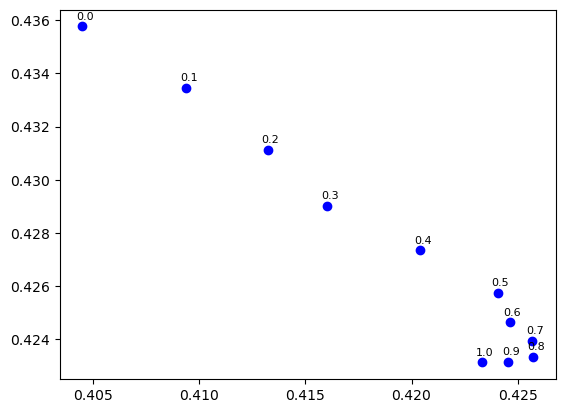

In [16]:
xs, ys, labels = get_mrtl_evals([2], [b/10.0 for b in range(11)], 150)
plt.scatter(xs, ys, color='blue', label='mrtl nominal') 
for (xi, yi, li) in zip(xs, ys, labels):
    plt.annotate(f'{li}', (xi, yi), textcoords="offset points", xytext=(2,5), ha='center', fontsize=8)
            
                

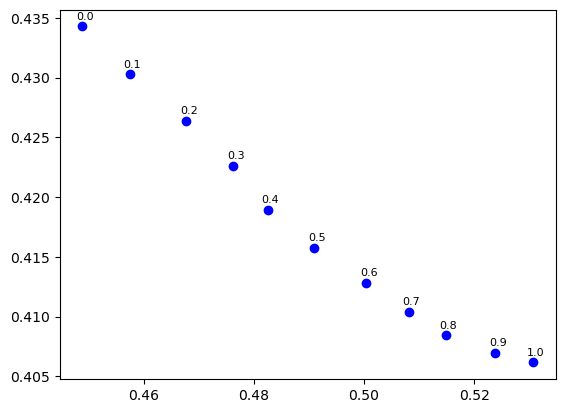

In [14]:
xs, ys, labels = get_mrtl_evals([3], [b/10.0 for b in range(11)], 435)
plt.scatter(xs, ys, color='blue', label='mrtl nominal') 
for (xi, yi, li) in zip(xs, ys, labels):
    plt.annotate(f'{li}', (xi, yi), textcoords="offset points", xytext=(2,5), ha='center', fontsize=8)

In [37]:
# train residuals

train_single_mrtl_residual_all_context([3], 435, [0], 565)

#!/bin/sh

#SBATCH -o pareto/single_ring/MRTL/residual_nom3_0/train.log
#SBATCH --time=72:00:00          # total run time limit (HH:MM:SS)
#SBATCH -c 33

python $F/ring.py pareto/single_ring/MRTL/residual_nom3_0 "worker_kwargs=[{'beta': 0.0}, {'beta': 0.1}, {'beta': 0.2}, {'beta': 0.3}, {'beta': 0.4}, {'beta': 0.5}, {'beta': 0.6}, {'beta': 0.7}, {'beta': 0.8}, {'beta': 0.9}, {'beta': 1.0}]" "n_workers=33" "n_rollouts_per_step=33" "warmup_steps=2000" "skip_stat_steps=5000" "horizon=5000" "global_reward=True" "n_steps=1000" "alg='TRPO'" "use_critic=False" "gamma=0.9995" "beta=0" "scale_ttc=0.8" "scale_drac=0.8" "seed_np=1228644375" "seed_torch=106619" "residual_transfer=True" "lr=0.0001" "wb=False" "tb=False" 


['pareto/single_ring/MRTL/residual_nom3_0/train.log']

In [38]:
train_single_mrtl_residual_indiv([3], 435, beta_values, [0], 565)

['pareto/single_ring/MRTL/residual_nom3_beta0.0_0/train.log',
 'pareto/single_ring/MRTL/residual_nom3_beta0.1_0/train.log',
 'pareto/single_ring/MRTL/residual_nom3_beta0.2_0/train.log',
 'pareto/single_ring/MRTL/residual_nom3_beta0.3_0/train.log',
 'pareto/single_ring/MRTL/residual_nom3_beta0.4_0/train.log',
 'pareto/single_ring/MRTL/residual_nom3_beta0.5_0/train.log',
 'pareto/single_ring/MRTL/residual_nom3_beta0.6_0/train.log',
 'pareto/single_ring/MRTL/residual_nom3_beta0.7_0/train.log',
 'pareto/single_ring/MRTL/residual_nom3_beta0.8_0/train.log',
 'pareto/single_ring/MRTL/residual_nom3_beta0.9_0/train.log',
 'pareto/single_ring/MRTL/residual_nom3_beta1.0_0/train.log']

In [ ]:
# def plot_train_mrtl_residual(nom_runs=[3], beta_values=beta_values, dir_func=lambda i, j: f'{single_mrtl_exp_dir}/residual_nom{i}_{j}', title='MRTL training residual indiv'):
#     for i in nom_runs:
#         for j in beta_values:
#             try:
#                 df = pd.read_csv(f'{dir_func(i, j)}/train_results.csv')
#                 plt.plot(df['ssm_mean'], label='ssm')
#                 plt.plot(df['speed_reward_mean'], label='speed')
#                 plt.plot(400*df['reward_mean'], label='reward')
#                 plt.title(title)
#                 plt.xlabel('ssm')
#                 plt.xlabel('speed')
#                 plt.legend()
#                 plt.show()
#             except Exception as exc:
#                 print(i, exc)




# plot_train_mrtl_residual(runs=[3], dir_func=lambda i: f'{single_mrtl_exp_dir}/residual_nom{i}_{j}', title='MRTL training residual indiv')


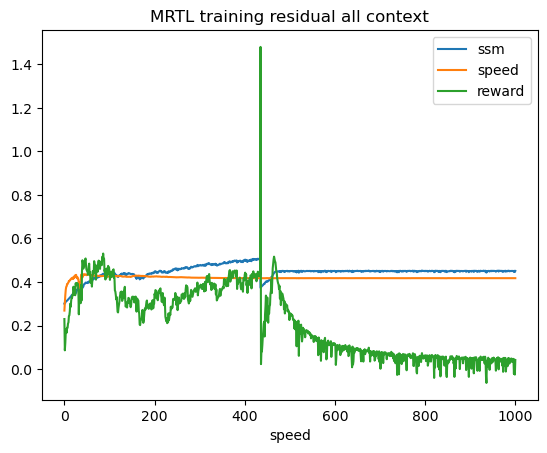

In [11]:
plot_train_mrtl(runs=[3], dir_func=lambda i: f'{single_mrtl_exp_dir}/residual_nom{i}_0', title='MRTL training residual all context')

In [40]:
eval_single_mrtl_residual_all_context([3], [0], [b/10.0 for b in range(11)], 1000)


In [39]:
# [0.0, 0.1, 0.3, 0.8, 1.0]

eval_single_mrtl_residual_indiv([3], [0], [0.0, 0.1, 0.3, 0.8, 1.0], 1000)
# train_single_mrtl_residual_indiv([3], 435, [0.2, 0.4, 0.5, 0.6, 0.7, 0.9], [0], 565)
# [0.2, 0.4, 0.5, 0.6, 0.7, 0.9]

['pareto/single_ring/MRTL/residual_nom3_beta0.0_0/eval.log',
 'pareto/single_ring/MRTL/residual_nom3_beta0.1_0/eval.log',
 'pareto/single_ring/MRTL/residual_nom3_beta0.3_0/eval.log',
 'pareto/single_ring/MRTL/residual_nom3_beta0.8_0/eval.log',
 'pareto/single_ring/MRTL/residual_nom3_beta1.0_0/eval.log']

##### static speed policies

In [75]:
single_static_speed_exp_dir = f'{single_folder}/static_speed'
Path(f'{single_static_speed_exp_dir}').mkdir(parents=True, exist_ok=True)

run_nums=np.arange(single_num_runs)

seed_np=1228644375
seed_torch=106619
scale=0.8
n_steps=10


In [81]:
def train_single_static_speed(speeds):
    output_logs = []
    for speed in speeds:
        cur_dir = f'{single_static_speed_exp_dir}/speed_{speed}'
        Path(f'{cur_dir}').mkdir(parents=True, exist_ok=True)
        output_log_name = f'{cur_dir}/train_speed{speed}.log'
        train_script_text = single_ring_train_script_text(output_log=output_log_name, run_dir=cur_dir, scale_ttc=scale, scale_drac=scale, n_steps=5, handcraft=speed, step_save=1)
        train_script_path = f'{cur_dir}/train_speed{speed}.sh'
        create_file_with_contents(train_script_path, train_script_text)
        out, err = submit_job(train_script_path)
        output_logs += [output_log_name]
    return output_logs

In [ ]:
# train_single_static_speed([x for x in range(11)])
train_single_static_speed([7, 8, 9, 10])

In [78]:
def eval_single_static_speed(speeds):
    for speed in speeds:
        cur_dir = f'{single_static_speed_exp_dir}/speed_{speed}'
        try:
            output_log_name = f'{cur_dir}/eval_speed{speed}.log'
            e=5
            eval_script_text = single_ring_eval_script_text(e=e, output_log=output_log_name, run_dir=cur_dir, result_save=f'{cur_dir}/eval_speed{speed}_e{e}.csv', vehicle_info_save=f'{cur_dir}/trajectory_e{e}.npz', scale_ttc=scale, scale_drac=scale)
            eval_script_path = f'{cur_dir}/eval_speed{speed}.sh'
            create_file_with_contents(eval_script_path, eval_script_text)
            out, err = submit_job(eval_script_path)
            output_logs += [output_log_name]
        except Exception as exc:
            print(speed)
            print(exc)
    # return output_logs
        

In [71]:
eval_single_static_speed([x for x in range(11)])

0
local variable 'output_logs' referenced before assignment
1
local variable 'output_logs' referenced before assignment
2
local variable 'output_logs' referenced before assignment
3
local variable 'output_logs' referenced before assignment
4
local variable 'output_logs' referenced before assignment
5
local variable 'output_logs' referenced before assignment
6
local variable 'output_logs' referenced before assignment
7
local variable 'output_logs' referenced before assignment
8
local variable 'output_logs' referenced before assignment
9
local variable 'output_logs' referenced before assignment
10
local variable 'output_logs' referenced before assignment


In [72]:
def get_static_eval(e, speed_vals): 
    ssms, speeds, labels = [], [], []
    for speed in speed_vals:
        cur_dir = f'{single_static_speed_exp_dir}/speed_{speed}'
        eval_csv = f'{cur_dir}/eval_speed{speed}_e{e}.csv'
        if os.path.exists(eval_csv):
            try:
                eval_df = pd.read_csv(eval_csv)
                ssms += [np.mean(eval_df['ssm_mean'])]
                speeds += [np.mean(eval_df['speed_reward_mean'])]
                labels += [f'{speed} static']
            except Exception as exc:
                print(speed)
                print(exc)
    return ssms, speeds, labels

##### plot all Pareto frontiers for scratch, finetune, residual transfer

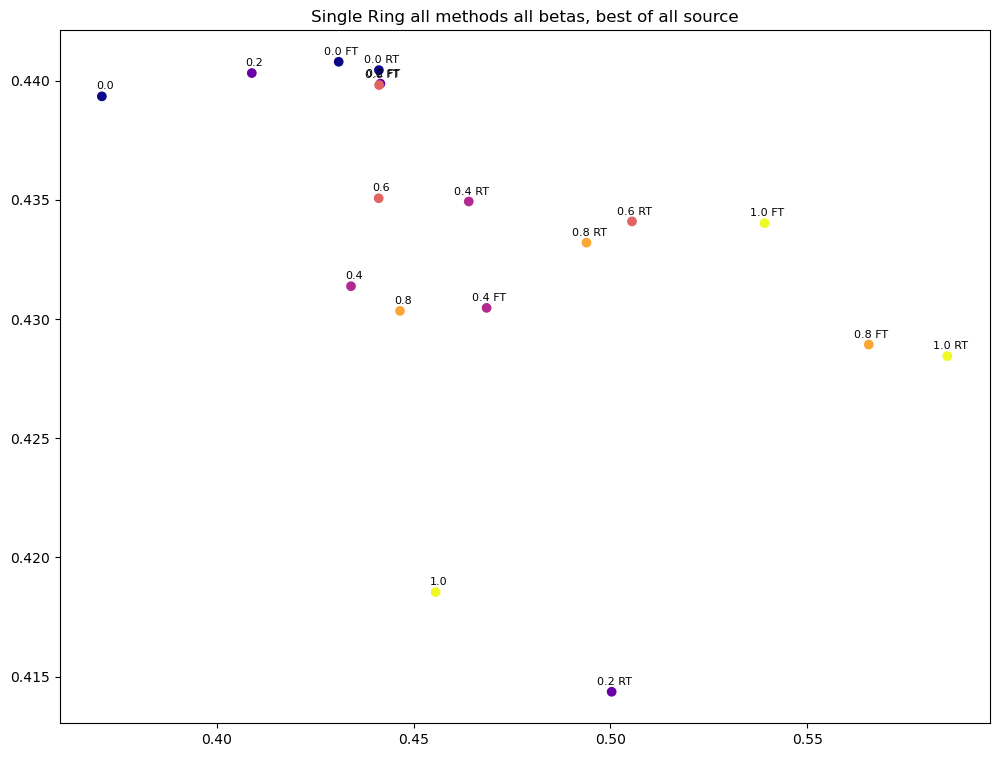

In [172]:
# ft_ssms, ft_speeds, ft_labels = plot_best_eval_additional_training_methods(single_finetune_exp_dir, [0.0, 0.2, 0.4, 0.6, 0.8, 1.0], 'Finetune Pareto', single_finetune_best_source_per_target, 'FT')    
# rt_ssms, rt_speeds, rt_labels = plot_best_eval_additional_training_methods(single_restransfer_exp_dir, [0.0, 0.2, 0.4, 0.6, 0.8, 1.0], 'Residual Transfer Pareto', single_restransfer_best_source_per_target, 'RT')
# scratch_ssms, scratch_speeds, scratch_labels = plot_avg_eval(single_scratch_exp_dir, 145, [0.0, 0.2, 0.4, 0.6, 0.8, 1.0], run_nums, 'avg Single Ring from scratch: SSM-Speed Eval 145')  # avg!
# best_at_145 = get_best_run(single_scratch_exp_dir, 145, beta_values, run_nums)
# scratch_ssms_best, scratch_speeds_best, scratch_labels_best = plot_best_eval(single_scratch_exp_dir, 145, [0.0, 0.2, 0.4, 0.6, 0.8, 1.0], run_nums, 'best Single Ring from scratch: SSM-Speed Eval 145', best_at_145) 


plt.figure(figsize=(12, 9))
        
plt.scatter(rt_ssms, rt_speeds, c=np.arange(len(rt_ssms)), cmap='plasma')
for (li, xi, yi) in zip(rt_labels, rt_ssms, rt_speeds):
    plt.annotate(f'{li}', (xi, yi), textcoords="offset points", xytext=(2,5),
                 ha='center', fontsize=8)
    
plt.scatter(ft_ssms, ft_speeds, c=np.arange(len(ft_ssms)), cmap='plasma')
for (li, xi, yi) in zip(ft_labels, ft_ssms, ft_speeds):
    plt.annotate(f'{li}', (xi, yi), textcoords="offset points", xytext=(2,5),
                 ha='center', fontsize=8)
        
scratch_labels = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
plt.scatter(scratch_ssms, scratch_speeds, c=np.arange(len(scratch_ssms)), cmap='plasma')
for (li, xi, yi) in zip(scratch_labels, scratch_ssms, scratch_speeds):
    plt.annotate(f'{li}', (xi, yi), textcoords="offset points", xytext=(2,5),
                 ha='center', fontsize=8)
    
plt.title('Single Ring all methods all betas, best of all source')
plt.show()



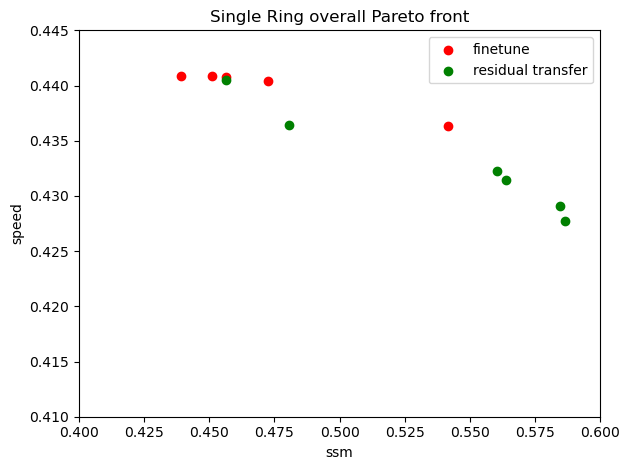

In [194]:
ft_ssms_all, ft_speeds_all, ft_labels_all = get_all_eval_additional_training_methods(single_finetune_exp_dir, [0.0, 0.2, 0.4, 0.6, 0.8, 1.0], [0.0, 0.2, 0.4, 0.6, 0.8, 1.0], 'FT')    
rt_ssms_all, rt_speeds_all, rt_labels_all = get_all_eval_additional_training_methods(single_restransfer_exp_dir, [0.0, 0.2, 0.4, 0.6, 0.8, 1.0], [0.0, 0.2, 0.4, 0.6, 0.8, 1.0], 'RT')

# get_all_eval_additional_training_methods(exp_dir, target_values, source_values, label_method, i_range=[0,1], e=290, source_e=145)

ft_all_x, ft_all_y = pareto_frontier(ft_ssms_all, ft_speeds_all)
rt_all_x, rt_all_y = pareto_frontier(rt_ssms_all, rt_speeds_all)


# plt.scatter(rt_all_x, rt_all_y, color='green', label='residual transfer')
# # plt.plot(rt_all_x, rt_all_y, color='green', label='residual transfer')
# plt.scatter(ft_all_x, ft_all_y, color='red', label='finetune')
# # plt.plot(ft_all_x, ft_all_y, color='red', label='finetune')

scratch_p_x, scratch_p_y = pareto_frontier(scratch_ssms, scratch_speeds)
# plt.scatter(scratch_p_x, scratch_p_y, color='blue', label='from scratch')
# # plt.plot(scratch_p_x, scratch_p_y, color='blue', label='from scratch')

all_ssms, all_speeds = scratch_p_x+ft_all_x+rt_all_x, scratch_p_y+ft_all_y+rt_all_y
all_x, all_y = pareto_frontier(all_ssms, all_speeds)
scratch_part = []
ft_part = []
rt_part = []



for p in zip(all_x, all_y):
    if p in zip(scratch_p_x, scratch_p_y):
        scratch_part += [p]
    if p in zip(ft_all_x, ft_all_y):
        ft_part += [p]
    if p in zip(rt_all_x, rt_all_y):
        rt_part += [p]
    
if scratch_part:
    plt.scatter(*zip(*scratch_part), color='blue', label='scratch')    
if ft_part:
    plt.scatter(*zip(*ft_part), color='red', label='finetune')
if rt_part:
    plt.scatter(*zip(*rt_part), color='green', label='residual transfer')

plt.title('Single Ring overall Pareto front')
plt.xlabel('ssm')
plt.ylabel('speed')
plt.xlim(0.4, 0.6) # careful! set only after plotting without lims
plt.ylim(0.410, 0.445) # careful! set only after plotting without lims
plt.legend()
plt.tight_layout()
plt.show()


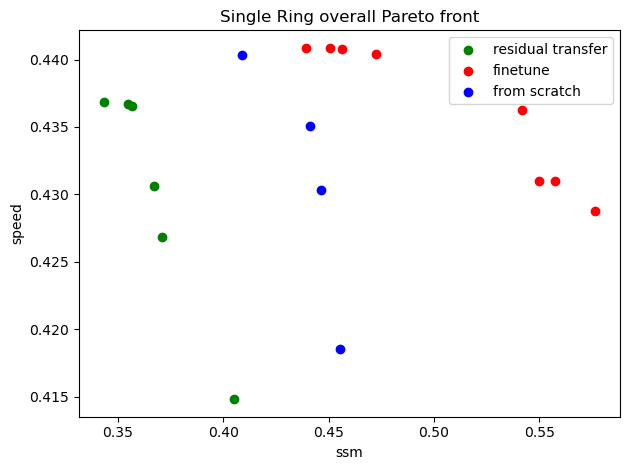

In [17]:
# TRAINED ON RT=FALSE :///// evaluated on RT=TRUE!

# scratch_ssms, scratch_speeds, scratch_labels = plot_avg_eval(single_scratch_exp_dir, 145, [0.0, 0.2, 0.4, 0.6, 0.8, 1.0], run_nums, 'avg Single Ring from scratch: SSM-Speed Eval 145')  # avg!

ft_ssms_all, ft_speeds_all, ft_labels_all = get_all_eval_additional_training_methods(single_finetune_exp_dir, [0.0, 0.2, 0.4, 0.6, 0.8, 1.0], [0.0, 0.2, 0.4, 0.6, 0.8, 1.0], 'FT')    
rt_ssms_all, rt_speeds_all, rt_labels_all = get_all_eval_additional_training_methods(single_restransfer_exp_dir, [0.0, 0.2, 0.4, 0.6, 0.8, 1.0], [0.0, 0.2, 0.4, 0.6, 0.8, 1.0], 'RT')

# get_all_eval_additional_training_methods(exp_dir, target_values, source_values, label_method, i_range=[0,1], e=290, source_e=145)

ft_all_x, ft_all_y = pareto_frontier(ft_ssms_all, ft_speeds_all)
rt_all_x, rt_all_y = pareto_frontier(rt_ssms_all, rt_speeds_all)


plt.scatter(rt_all_x, rt_all_y, color='green', label='residual transfer')
# plt.plot(rt_all_x, rt_all_y, color='green', label='residual transfer')
plt.scatter(ft_all_x, ft_all_y, color='red', label='finetune')
# plt.plot(ft_all_x, ft_all_y, color='red', label='finetune')

scratch_p_x, scratch_p_y = pareto_frontier(scratch_ssms, scratch_speeds)
plt.scatter(scratch_p_x, scratch_p_y, color='blue', label='from scratch')
# # plt.plot(scratch_p_x, scratch_p_y, color='blue', label='from scratch')

all_ssms, all_speeds = scratch_p_x+ft_all_x+rt_all_x, scratch_p_y+ft_all_y+rt_all_y
all_x, all_y = pareto_frontier(all_ssms, all_speeds)
scratch_part = []
ft_part = []
rt_part = []



for p in zip(all_x, all_y):
    if p in zip(scratch_p_x, scratch_p_y):
        scratch_part += [p]
    if p in zip(ft_all_x, ft_all_y):
        ft_part += [p]
    if p in zip(rt_all_x, rt_all_y):
        rt_part += [p]
    
# if scratch_part:
#     plt.scatter(*zip(*scratch_part), color='blue', label='scratch')    
# if ft_part:
#     plt.scatter(*zip(*ft_part), color='red', label='finetune')
# if rt_part:
#     plt.scatter(*zip(*rt_part), color='green', label='residual transfer')

plt.title('Single Ring overall Pareto front')
plt.xlabel('ssm')
plt.ylabel('speed')
# plt.xlim(0.4, 0.6) # careful! set only after plotting without lims
# plt.ylim(0.410, 0.445) # careful! set only after plotting without lims
plt.legend()
plt.tight_layout()
plt.show()


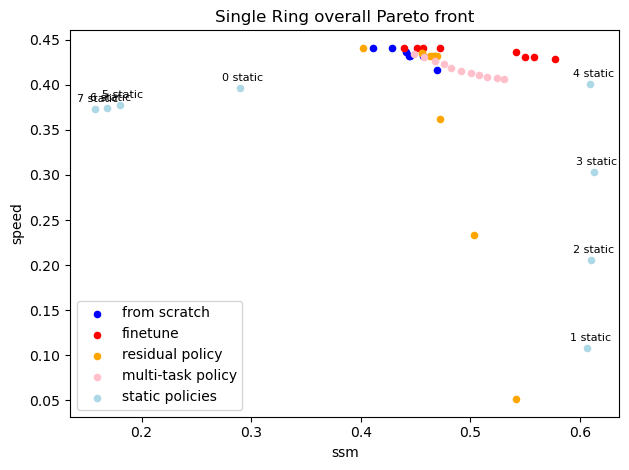

In [73]:
#for training with RT=TRUE, evaluating on RT=TRUE!

#graph all methods' individual pareto

# scratch_ssms, scratch_speeds, scratch_labels = plot_avg_eval(single_scratch_exp_dir, 145, [0.0, 0.2, 0.4, 0.6, 0.8, 1.0], run_nums, 'avg Single Ring from scratch: SSM-Speed Eval 145')  # avg!
scratch_ssms, scratch_speeds, scratch_labels = plot_all_eval(single_scratch_exp_dir, 145, [0.0, 0.2, 0.4, 0.6, 0.8, 1.0], run_nums, 'avg Single Ring from scratch: SSM-Speed Eval 145')  # all!

static_ssms, static_speeds, static_labels = get_static_eval(10, [x for x in range(11)]) # all static speed policies!

ft_ssms_all, ft_speeds_all, ft_labels_all = get_all_eval_additional_training_methods(single_finetune_exp_dir, [0.0, 0.2, 0.4, 0.6, 0.8, 1.0], [0.0, 0.2, 0.4, 0.6, 0.8, 1.0], 'FT')    
rt_ssms_all, rt_speeds_all, rt_labels_all = get_all_eval_additional_training_methods(single_restransfer_exp_dir, [0.0, 0.2, 0.4, 0.6, 0.8, 1.0], [0.0, 0.2, 0.4, 0.6, 0.8, 1.0], 'RT')
a, b, c = get_all_eval_additional_training_methods(single_restransfer_lr_exp_dir, [0.0, 0.2, 0.4, 0.6, 0.8, 1.0], [0.0, 0.2, 0.4, 0.6, 0.8, 1.0], 'RT')
rt_ssms_all += a
rt_speeds_all += b 
rt_labels_all += c
    
nom_x, nom_y, nom_l = get_mrtl_evals([3], [b/10.0 for b in range(11)], 435)  # multi task base nominal
nom_res_x, nom_res_y, nom_res_l = get_mrtl_evals([3], beta_values, 635, res_runs=[0], csv_dir=lambda i,b,e,j: f'{single_mrtl_exp_dir}/residual_nom{i}_{j}/eval_beta{b}_e{e}.csv') # multi task nominal, multi task residual
mtnstr_x, mtnstr_y, mtnstr_l = get_mrtl_evals([3], [0.0, 0.1, 0.3, 0.8, 1.0], 1000, res_runs=[0], csv_dir=lambda i, b, e, j: f'{single_mrtl_exp_dir}/residual_nom{i}_beta{b}_{j}/eval_e{e}.csv') # multi task nominal, single task residual

# get_all_eval_additional_training_methods(exp_dir, target_values, source_values, label_method, i_range=[0,1], e=290, source_e=145)

scratch_p_x, scratch_p_y, scratch_p_l = pareto_frontier(scratch_ssms, scratch_speeds, scratch_labels)
ft_all_x, ft_all_y, ft_all_l = pareto_frontier(ft_ssms_all, ft_speeds_all, ft_labels_all)
rt_all_x, rt_all_y, rt_all_l = pareto_frontier(rt_ssms_all, rt_speeds_all, rt_labels_all)

nom_all_x, nom_all_y, nom_all_l = pareto_frontier(nom_x, nom_y, nom_l)
nom_res_all_x, nom_res_all_y, nom_res_all_l = pareto_frontier(nom_res_x, nom_res_y, nom_res_l)
mtnstr_all_x, mtnstr_all_y, mtnstr_all_l = pareto_frontier(mtnstr_x, mtnstr_y, mtnstr_l)



plt.scatter(scratch_p_x, scratch_p_y, color='blue', label='from scratch', s=20)
plt.scatter(ft_all_x, ft_all_y, color='red', label='finetune', s=20)
plt.scatter(rt_all_x, rt_all_y, color='orange', label='residual policy', s=20)

plt.scatter(nom_all_x, nom_all_y, color='pink', label='multi-task policy', s=20)
# plt.scatter(nom_res_all_x, nom_res_all_y, color='purple', label='MRTL', s=20)
# plt.scatter(mtnstr_all_x, mtnstr_all_y, color='lightgreen', label='MT nom + ST resid', s=20)


plt.scatter(static_ssms, static_speeds, color='lightblue', label='static policies', s=20)
for (li, xi, yi) in zip(static_labels, static_ssms, static_speeds):
    plt.annotate(f'{li}', (xi, yi), textcoords="offset points", xytext=(2,5), ha='center', fontsize=8)


# plt.plot(scratch_p_x, scratch_p_y, color='blue', label='from scratch')
# plt.plot(ft_all_x, ft_all_y, color='red', label='finetune')
# plt.plot(rt_all_x, rt_all_y, color='green', label='residual transfer')

# for (li, xi, yi) in zip( scratch_p_l, scratch_p_x, scratch_p_y):
#     plt.annotate(f'{li}', (xi, yi), textcoords="offset points", xytext=(2,5), ha='center', fontsize=8)
# for (li, xi, yi) in zip(ft_all_l, ft_all_x, ft_all_y):
#     plt.annotate(f'{li}', (xi, yi), textcoords="offset points", xytext=(2,5), ha='center', fontsize=8)
# for (li, xi, yi) in zip(rt_all_l, rt_all_x, rt_all_y):
#     plt.annotate(f'{li}', (xi, yi), textcoords="offset points", xytext=(2,5), ha='center', fontsize=8)

# graph overall pareto segments

# all_ssms, all_speeds, all_labels = scratch_p_x+ft_all_x+rt_all_x, scratch_p_y+ft_all_y+rt_all_y, scratch_p_l+ft_all_l+rt_all_l
# all_x, all_y, all_l = pareto_frontier(all_ssms, all_speeds, all_labels)
# scratch_part = []
# ft_part = []
# rt_part = []

# for p in zip(all_x, all_y, all_l):
#     if p in zip(scratch_p_x, scratch_p_y, scratch_p_l):
#         scratch_part += [p]
#     if p in zip(ft_all_x, ft_all_y, ft_all_l):
#         ft_part += [p]
#     if p in zip(rt_all_x, rt_all_y, rt_all_l):
#         rt_part += [p]

    
# if scratch_part:
#     scratch_part_x, scratch_part_y, scratch_part_l = zip(*scratch_part)
#     plt.scatter(scratch_part_x, scratch_part_y, color='blue', label='scratch') 
#     for (xi, yi, li) in scratch_part:
#         plt.annotate(f'{li}', (xi, yi), textcoords="offset points", xytext=(2,5), ha='center', fontsize=8)
# if ft_part:
#     ft_part_x, ft_part_y, ft_part_l = zip(*ft_part)
#     plt.scatter(ft_part_x, ft_part_y, color='red', label='finetune')   
#     for (xi, yi, li) in ft_part:
#         plt.annotate(f'{li}', (xi, yi), textcoords="offset points", xytext=(2,5), ha='center', fontsize=8)
# if rt_part:
#     rt_part_x, rt_part_y, rt_part_l = zip(*rt_part)
#     plt.scatter(rt_part_x, rt_part_y, color='red', label='residual transfer')   
#     for (xi, yi, li) in rt_part:
#         plt.annotate(f'{li}', (xi, yi), textcoords="offset points", xytext=(2,5), ha='center', fontsize=8)

plt.title('Single Ring overall Pareto front')
plt.xlabel('ssm')
plt.ylabel('speed')
# plt.xlim(0.4, 0.6) # careful! set only after plotting without lims
# plt.ylim(0.40, 0.445) # careful! set only after plotting without lims
plt.legend()
plt.tight_layout()
plt.show()


##### testing

In [16]:
# looking at new residual training curves after modifying residual action

source = f'{single_folder}/from_scratch/0.4_0'
target = f'{single_folder}/testing/test_residualtransfer'

# prep_additional_training(source, target, 145)

beta=1.0
i=0
e=145
output_log_name = f'{target}/trainres0.4to{beta}_{i}.log'
train_script_text = single_ring_train_script_text(output_log=output_log_name, run_dir=target, beta=beta, scale_ttc=0.8, scale_drac=0.8, n_steps=290, seed_np=seed_np, seed_torch=seed_torch, residual_transfer=True)
train_script_path = f'{target}/trainres0.4to{beta}_{i}.sh'
create_file_with_contents(train_script_path, train_script_text)
out, err = submit_job(train_script_path)

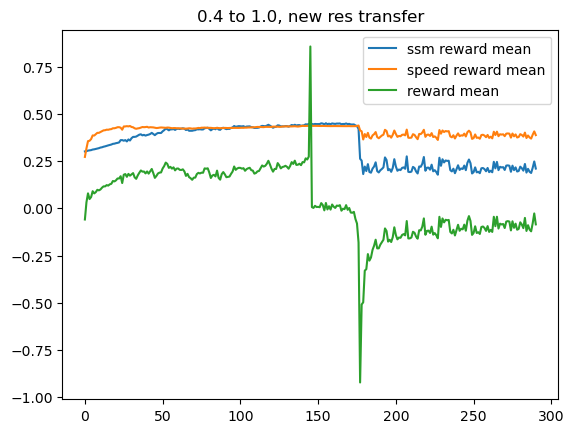

In [25]:
plot_df = pd.read_csv(f'{single_folder}/testing/test_residualtransfer/train_results.csv')
plt.plot(plot_df['ssm_mean'], label='ssm reward mean')
plt.plot(plot_df['speed_reward_mean'], label='speed reward mean')
plt.plot(200*plot_df['reward_mean'], label='reward mean')
plt.title('0.4 to 1.0, new res transfer')
plt.legend()
plt.show()

In [55]:
# looking at new residual training curves after modifying residual action

source = f'{single_folder}/from_scratch/0.8_2'
target = f'{single_folder}/testing/test_residualtransfer_0.8_0.2'

# prep_additional_training(source, target, 145)

beta=0.2
i=0
e=145
output_log_name = f'{target}/trainres0.8to{beta}_{i}.log'
train_script_text = single_ring_train_script_text(output_log=output_log_name, run_dir=target, beta=beta, scale_ttc=0.8, scale_drac=0.8, n_steps=290, seed_np=seed_np, seed_torch=seed_torch, residual_transfer=True)
train_script_path = f'{target}/trainres0.8to{beta}_{i}.sh'
create_file_with_contents(train_script_path, train_script_text)
out, err = submit_job(train_script_path)

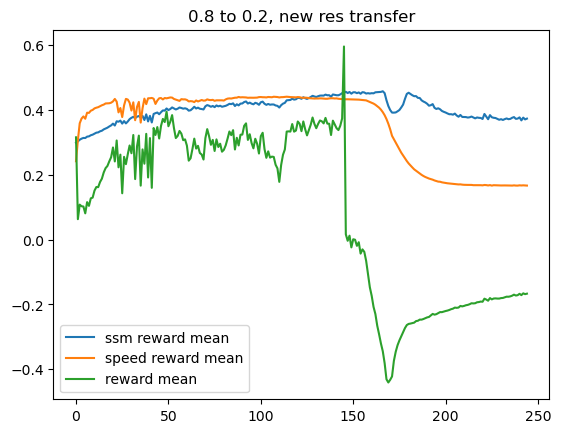

In [22]:
plot_df = pd.read_csv(f'{single_folder}/testing/test_residualtransfer_0.8_0.2/train_results.csv')
plt.plot(plot_df['ssm_mean'], label='ssm reward mean')
plt.plot(plot_df['speed_reward_mean'], label='speed reward mean')
plt.plot(200*plot_df['reward_mean'], label='reward mean')
plt.title('0.8 to 0.2, new res transfer')
plt.legend()
plt.show()

In [29]:
# looking at training residual on top of finetune

source = f'{single_folder}/finetune/0.4_0_e145_to_1.0_0'
target = f'{single_folder}/testing/test_residualonft'

# prep_additional_training(source, target, 200)

beta=0.4
i=0
target_beta=1.0
output_log_name = f'{target}/trainResFT0.4to{target_beta}_{i}.log'
train_script_text = single_ring_train_script_text(output_log=output_log_name, run_dir=target, beta=target_beta, scale_ttc=0.8, scale_drac=0.8, n_steps=290, seed_np=seed_np, seed_torch=seed_torch, residual_transfer=True)
train_script_path = f'{target}/trainResFT0.4to{target_beta}_{i}.sh'
create_file_with_contents(train_script_path, train_script_text)
out, err = submit_job(train_script_path)

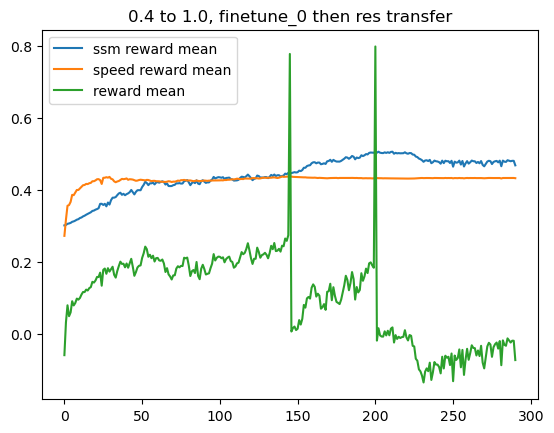

In [52]:
plot_df = pd.read_csv(f'{single_folder}/testing/test_residualonft/train_results.csv')
plt.plot(plot_df['ssm_mean'], label='ssm reward mean')
plt.plot(plot_df['speed_reward_mean'], label='speed reward mean')
plt.plot(200*plot_df['reward_mean'], label='reward mean')
plt.title('0.4 to 1.0, finetune_0 then res transfer')
plt.legend()
plt.show()

In [28]:
# plot nom, res, FT eval actions

# modify code to log nom, res pred actions
# eval 1.0 from scratch, ft, res

plot_dir = f'{single_folder}/testing/plot_actions'

i = 0
beta=1.0
# e=145

# # eval scratch, save eval csv and trajectory and log and script into plot_dir
# output_log_name = f'{plot_dir}/eval_scratch{beta}_{i}_{e}.log'
# cur_dir = f'{single_scratch_exp_dir}/{beta}_{i}'
# eval_script_text = single_ring_eval_script_text(e=e, beta=beta, output_log=output_log_name, run_dir=cur_dir, result_save=f'{plot_dir}/eval_scratch_e{e}.csv', vehicle_info_save=f'{plot_dir}/scratch_trajectory.npz', scale_ttc=scale, scale_drac=scale)
# eval_script_path = f'{plot_dir}/eval_scratch_{beta}_{i}_{e}.sh'
# create_file_with_contents(eval_script_path, eval_script_text)
# out, err = submit_job(eval_script_path)

# e=290
# # eval ft, save eval csv and trajectory and log and script into plot_dir
# output_log_name = f'{plot_dir}/eval_ft{beta}_{i}_{e}.log'
# cur_dir = f'{single_finetune_exp_dir}/0.4_0_e145_to_1.0_0'
# eval_script_text = single_ring_eval_script_text(e=e, beta=beta, output_log=output_log_name, run_dir=cur_dir, result_save=f'{plot_dir}/eval_ft_e{e}.csv', vehicle_info_save=f'{plot_dir}/ft_trajectory.npz', scale_ttc=scale, scale_drac=scale)
# eval_script_path = f'{plot_dir}/eval_ft_{beta}_{i}_{e}.sh'
# create_file_with_contents(eval_script_path, eval_script_text)
# out, err = submit_job(eval_script_path)

# eval res, save eval csv and trajectory and log and script into plot_dir
# e=290
# output_log_name = f'{plot_dir}/eval_res{beta}_{i}_{e}.log'
# cur_dir = f'{single_folder}/testing/test_residualtransfer'
# eval_script_text = single_ring_eval_script_text(e=e, beta=beta, output_log=output_log_name, run_dir=cur_dir, result_save=f'{plot_dir}/eval_res_e{e}.csv', vehicle_info_save=f'{plot_dir}/res_trajectory.npz', scale_ttc=scale, scale_drac=scale, residual_transfer=True)
# eval_script_path = f'{plot_dir}/eval_res_{beta}_{i}_{e}.sh'
# create_file_with_contents(eval_script_path, eval_script_text)
# out, err = submit_job(eval_script_path)

e=160
# eval res, save eval csv and trajectory and log and script into plot_dir
output_log_name = f'{plot_dir}/eval_res{beta}_{i}_{e}.log'
cur_dir = f'{single_folder}/testing/test_residualtransfer'
eval_script_text = single_ring_eval_script_text(e=e, beta=beta, output_log=output_log_name, run_dir=cur_dir, result_save=f'{plot_dir}/eval_res_e{e}.csv', vehicle_info_save=f'{plot_dir}/res_trajectory.npz', scale_ttc=scale, scale_drac=scale, residual_transfer=True)
eval_script_path = f'{plot_dir}/eval_res_{beta}_{i}_{e}.sh'
create_file_with_contents(eval_script_path, eval_script_text)
out, err = submit_job(eval_script_path)



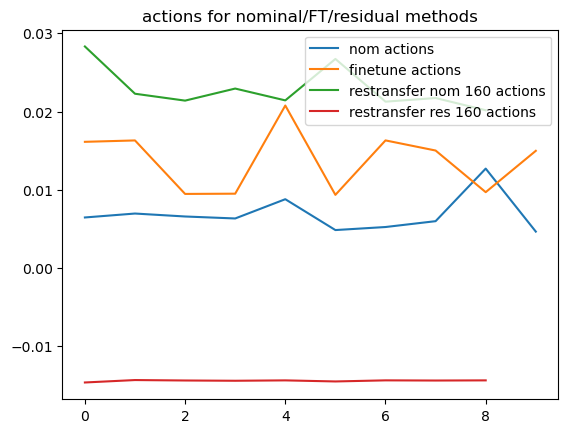

In [35]:
# plot corresponding columns from each eval df

nom_df = pd.read_csv(f'{plot_dir}/eval_scratch_e145.csv')
plt.plot(nom_df['nom_action'], label='nom actions')

ft_df = pd.read_csv(f'{plot_dir}/eval_ft_e290.csv')
plt.plot(ft_df['nom_action'], label='finetune actions')

# res_df = pd.read_csv(f'{plot_dir}/eval_res_e290.csv')
# plt.plot(res_df['nom_action'], label='restransfer nom 290 actions')
# plt.plot(res_df['res_action'], label='restransfer res 290 actions')

res_df = pd.read_csv(f'{plot_dir}/eval_res_e160.csv')
plt.plot(res_df['nom_action'], label='restransfer nom 160 actions')
plt.plot(res_df['res_action'], label='restransfer res 160 actions')

plt.title('actions for nominal/FT/residual methods')
plt.legend()
plt.show()

In [49]:
target = f'{single_folder}/testing/resid_init'
Path(f'{target}').mkdir(parents=True, exist_ok=True)
output_log_name = f'{target}/train_RTinit{beta}_{i}.log'
train_script_text = single_ring_train_script_text(output_log=output_log_name, run_dir=target, beta=beta, scale_ttc=0.8, scale_drac=0.8, n_steps=20, seed_np=seed_np, seed_torch=seed_torch)
train_script_path = f'{target}/train_RTinit_{beta}_{i}.sh'
create_file_with_contents(train_script_path, train_script_text)
out, err = submit_job(train_script_path)

##### archive

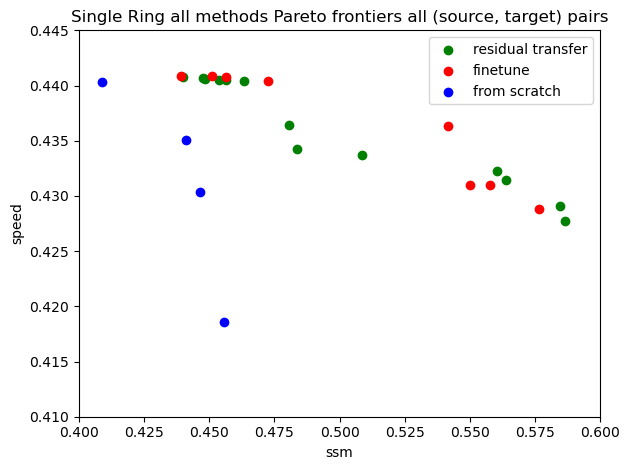

In [196]:
ft_ssms_all, ft_speeds_all, ft_labels_all = get_all_eval_additional_training_methods(single_finetune_exp_dir, [0.0, 0.2, 0.4, 0.6, 0.8, 1.0], [0.0, 0.2, 0.4, 0.6, 0.8, 1.0], 'FT')    
rt_ssms_all, rt_speeds_all, rt_labels_all = get_all_eval_additional_training_methods(single_restransfer_exp_dir, [0.0, 0.2, 0.4, 0.6, 0.8, 1.0], [0.0, 0.2, 0.4, 0.6, 0.8, 1.0], 'RT')

# get_all_eval_additional_training_methods(exp_dir, target_values, source_values, label_method, i_range=[0,1], e=290, source_e=145)

ft_all_x, ft_all_y = pareto_frontier(ft_ssms_all, ft_speeds_all)
rt_all_x, rt_all_y = pareto_frontier(rt_ssms_all, rt_speeds_all)

# print(len(ft_ssms_all), len(rt_ssms_all))

plt.scatter(rt_all_x, rt_all_y, color='green', label='residual transfer')
# plt.plot(rt_all_x, rt_all_y, color='green', label='residual transfer')
plt.scatter(ft_all_x, ft_all_y, color='red', label='finetune')
# plt.plot(ft_all_x, ft_all_y, color='red', label='finetune')

scratch_p_x, scratch_p_y = pareto_frontier(scratch_ssms, scratch_speeds)
plt.scatter(scratch_p_x, scratch_p_y, color='blue', label='from scratch')
# plt.plot(scratch_p_x, scratch_p_y, color='blue', label='from scratch')

plt.title('Single Ring all methods Pareto frontiers all (source, target) pairs')
plt.xlabel('ssm')
plt.ylabel('speed')
plt.xlim(0.4, 0.6) # careful! set only after plotting without lims
plt.ylim(0.410, 0.445) # careful! set only after plotting without lims
plt.legend()
plt.tight_layout()
plt.show()


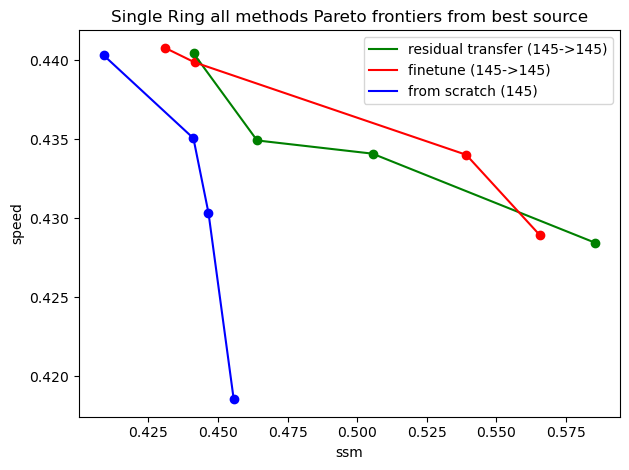

In [174]:
rt_p_x, rt_p_y = pareto_frontier(rt_ssms, rt_speeds)
ft_p_x, ft_p_y = pareto_frontier(ft_ssms, ft_speeds)
scratch_p_x, scratch_p_y = pareto_frontier(scratch_ssms, scratch_speeds)

plt.scatter(rt_p_x, rt_p_y, color='green')
plt.plot(rt_p_x, rt_p_y, color='green', label='residual transfer (145->145)')
plt.scatter(ft_p_x, ft_p_y, color='red')
plt.plot(ft_p_x, ft_p_y, color='red', label='finetune (145->145)')
plt.scatter(scratch_p_x, scratch_p_y, color='blue')
plt.plot(scratch_p_x, scratch_p_y, color='blue', label='from scratch (145)')
# plt.scatter(scratch_best_hull_x, scratch_best_hull_y, color='green')


plt.title('Single Ring all methods Pareto frontiers from best source')
plt.xlabel('ssm')
plt.ylabel('speed')
plt.legend()
plt.tight_layout()
plt.show()

In [169]:
print('finetune', single_finetune_best_source_per_target) # t : s 
print('restransfer', single_restransfer_best_source_per_target)

finetune {0.0: 0.0, 0.2: 0.2, 0.4: 0.8, 0.6: 0.2, 0.8: 0.6, 1.0: 0.4}
restransfer {0.0: 0.0, 0.2: 1.0, 0.4: 0.4, 0.6: 0.4, 0.8: 0.4, 1.0: 0.6}


In [79]:
# experiments/plots:
# training ttc vs speed plots of different beta vals
# naive pareto curve of different beta vals
# finetuning pareto curve of best target for each source beta val



other methods ("best" means highest average eval reward):
- finetuning (for each target, take the best policy from {Source scratch} x {Target finetune}. Pareto frontier is frontier of these points)
- best-of finetuning (for each target, take the best policy from {Best Source methods} x {Target finetune})
- sidetuning
- 

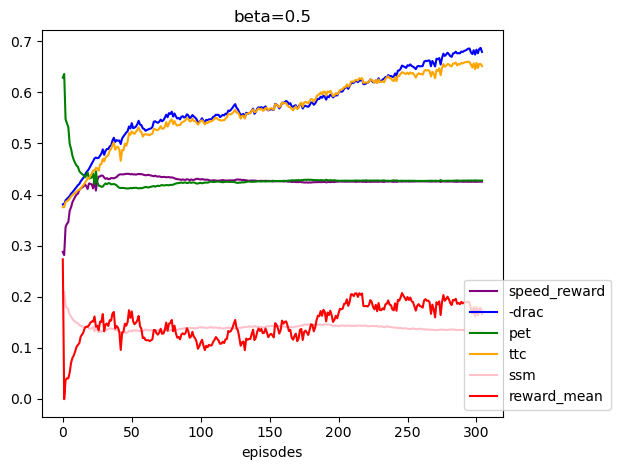

In [13]:
# plot training ttc vs speed for 0.5, see if ttc will converge

# x = np.arange(51)

b=5
beta = b/10
cur_dir = f'{testing_all_ssms_exp_dir}/{beta}'
train_df = pd.read_csv(f'{cur_dir}/train_results.csv')

ttc_y, ttc_std = train_df['ttc_mean'], train_df['ttc_std']
speed_reward_y, speed_reward_std = train_df['speed_reward_mean'], train_df['speed_reward_std']
drac_y, drac_std = -train_df['drac_mean'], train_df['drac_std']
pet_y, pet_std = train_df['pet_mean'], train_df['pet_std']

reward_y = 100*train_df['reward_mean']

# ssm_y, ssm_std = train_df['ssm_mean'], train_df['ssm_std']

# speed_y, speed_std = train_df['speed_rl'], train_df['speed_rl_std']
ssm_y = (ttc_y+pet_y-drac_y)/3
# ssm_y, ssm_std = train_df['ssm_mean'], train_df['ssm_std']
# reward_y = train_df['reward_mean']

x = np.arange(len(speed_reward_y))


plt.title(f'beta={beta}')
# plt.plot(x, ttc_y, color='red', label='ttc')
# plt.fill_between(x, ttc_y-ttc_std, ttc_y+ttc_std, color='red', alpha=0.2, label='ttc ± 1 std')
plt.plot(x, speed_reward_y, color='purple', label='speed_reward')
# plt.fill_between(x, speed_reward_y-speed_reward_std, speed_reward_y+speed_reward_std, color='purple', alpha=0.2, label='spd_rwd ± 1 std')

plt.plot(x, drac_y, color='blue', label='-drac')
# plt.fill_between(x, drac_y-drac_std, drac_y+drac_std, color='blue', alpha=0.2, label='drac ± 1 std')
plt.plot(x, pet_y, color='green', label='pet')
# plt.fill_between(x, pet_y-pet_std, pet_y+pet_std, color='green', alpha=0.2, label='pet ± 1 std')

plt.plot(x, ttc_y, color='orange', label='ttc')
# plt.fill_between(x, ssm_y-ssm_std, ssm_y+ssm_std, color='orange', alpha=0.2, label='ssm ± 1 std')

plt.plot(x, ssm_y, color='pink', label='ssm')
# plt.plot(x, reward_y, color='blue', label='reward')

plt.plot(x, reward_y, color='red', label='reward_mean')

plt.xlabel('episodes')

plt.legend(loc='lower right', bbox_to_anchor=(1.25, 0))
plt.tight_layout()
plt.show()

In [48]:
exp_dir = f'{folder}/testing'
Path(f'{exp_dir}').mkdir(parents=True, exist_ok=True)

In [4]:

b=5
beta = b/10
cur_dir = f'{exp_dir}/{beta}'
Path(f'{cur_dir}').mkdir(parents=True, exist_ok=True)
output_log_name = f'{cur_dir}/train{beta}.log'
train_script_text = single_ring_train_script_text(output_log=output_log_name, run_dir=cur_dir, beta=beta, n_steps=1000)
train_script_path = f'{cur_dir}/train{beta}.sh'
create_file_with_contents(train_script_path, train_script_text)
out, err = submit_job(train_script_path)
print(out, err)

File 'pareto/single_ring/testing/0.5/train0.5.sh' created successfully with contents.
Submitted batch job 25483459
LLGrid: TXE1 (running slurm-wlm 23.02.7)
 


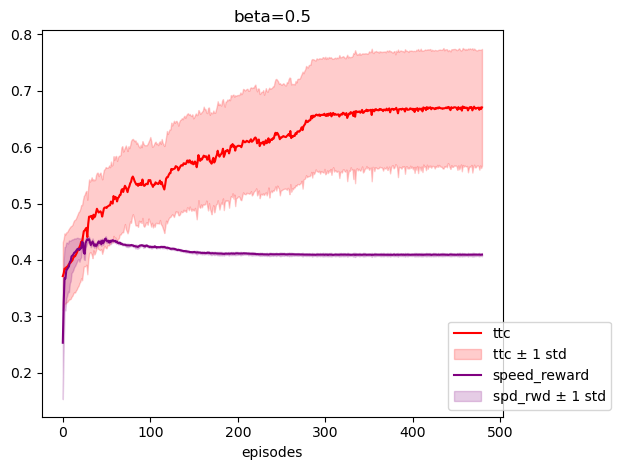

In [51]:
# plot training ttc vs speed for 0.5, see if ttc will converge

# x = np.arange(51)

b=5
beta = b/10
cur_dir = f'{exp_dir}/{beta}'
train_df = pd.read_csv(f'{cur_dir}/train_results.csv')

ttc_y, ttc_std = train_df['ttc_mean'], train_df['ttc_std']
speed_reward_y, speed_reward_std = train_df['speed_reward_mean'], train_df['speed_reward_std']

# speed_y, speed_std = train_df['speed_rl'], train_df['speed_rl_std']
# drac_y, drac_std = train_df['drac_mean'], train_df['drac_std']
# ssm_y = ttc_y-drac_y
# ssm_y, ssm_std = train_df['ssm_mean'], train_df['ssm_std']
# reward_y = train_df['reward_mean']

x = np.arange(len(speed_reward_y))


plt.title(f'beta={beta}')
plt.plot(x, ttc_y, color='red', label='ttc')
plt.fill_between(x, ttc_y-ttc_std, ttc_y+ttc_std, color='red', alpha=0.2, label='ttc ± 1 std')
plt.plot(x, speed_reward_y, color='purple', label='speed_reward')
plt.fill_between(x, speed_reward_y-speed_reward_std, speed_reward_y+speed_reward_std, color='purple', alpha=0.2, label='spd_rwd ± 1 std')

# plt.plot(x, ssm_y, color='pink', label='ssm')
# plt.plot(x, drac_y, color='green', label='drac')
# plt.fill_between(x, drac_y-drac_std, drac_y+drac_std, color='green', alpha=0.2, label='drac ± 1 std')
# plt.plot(x, reward_y, color='blue', label='reward')

plt.xlabel('episodes')

plt.legend(loc='lower right', bbox_to_anchor=(1.25, 0))
plt.tight_layout()
plt.show()

In [30]:
three_ssms_exp_dir = f'{folder}/testing_three_ssms'
Path(f'{three_ssms_exp_dir}').mkdir(parents=True, exist_ok=True)

output_logs = []

for b in range(11):
    beta = b/10
    cur_dir = f'{three_ssms_exp_dir}/{beta}'
    Path(f'{cur_dir}').mkdir(parents=True, exist_ok=True)
    output_log_name = f'{cur_dir}/train{beta}.log'
    train_script_text = single_ring_train_script_text(output_log=output_log_name, run_dir=cur_dir, beta=beta)
    train_script_path = f'{cur_dir}/train{beta}.sh'
    create_file_with_contents(train_script_path, train_script_text)
    out, err = submit_job(train_script_path)
    print(out, err)
    output_logs += [output_log_name]

File 'pareto/single_ring/testing_three_ssms/0.0/train0.0.sh' created successfully with contents.
Submitted batch job 25485006
LLGrid: TXE1 (running slurm-wlm 23.02.7)
 
File 'pareto/single_ring/testing_three_ssms/0.1/train0.1.sh' created successfully with contents.
Submitted batch job 25485007
LLGrid: TXE1 (running slurm-wlm 23.02.7)
 
File 'pareto/single_ring/testing_three_ssms/0.2/train0.2.sh' created successfully with contents.
Submitted batch job 25485008
LLGrid: TXE1 (running slurm-wlm 23.02.7)
 
File 'pareto/single_ring/testing_three_ssms/0.3/train0.3.sh' created successfully with contents.
Submitted batch job 25485009
LLGrid: TXE1 (running slurm-wlm 23.02.7)
 
File 'pareto/single_ring/testing_three_ssms/0.4/train0.4.sh' created successfully with contents.
Submitted batch job 25485010
LLGrid: TXE1 (running slurm-wlm 23.02.7)
 
File 'pareto/single_ring/testing_three_ssms/0.5/train0.5.sh' created successfully with contents.
Submitted batch job 25485011
LLGrid: TXE1 (running slurm-w

In [ ]:
# verify successful train
verify_multiple_execution(output_logs) 

NameError: name 'three_ssms_exp_dir' is not defined

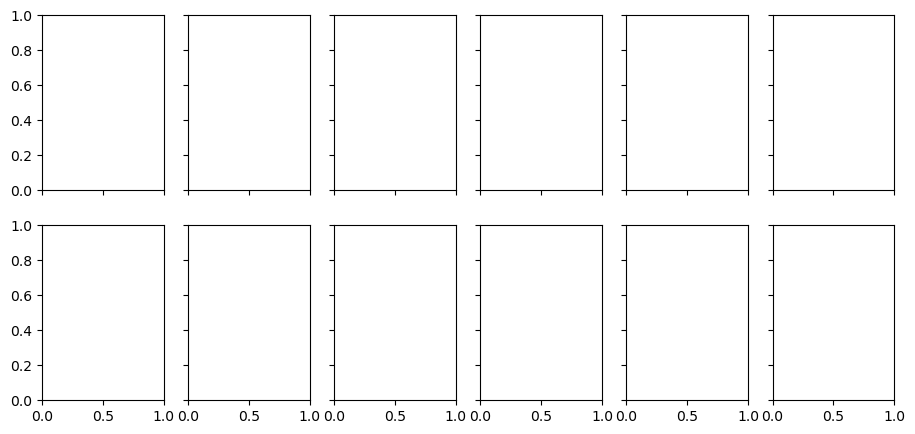

In [17]:
# plot training ttc vs speed for each beta

fig, axs = plt.subplots(2, 6, figsize=(11, 5), sharex=True, sharey=True)
axs_flat = axs.flatten()


for b in range(1,11):
    beta = b/10
    cur_dir = f'{three_ssms_exp_dir}/{beta}'
    train_df = pd.read_csv(f'{cur_dir}/train_results.csv')
    
    ttc_y, ttc_std = train_df['ttc_mean'], train_df['ttc_std']
    speed_y, speed_std = train_df['speed_reward_mean'], train_df['speed_reward_std']
    drac_y, drac_std = 900*train_df['drac_mean'], train_df['drac_std']
    pet_y, pet_std = -np.log10(train_df['pet_mean'])/16, train_df['pet_std']
    
    # print(train_df['pet_mean'], train_df['pet_std'])
    
    x = np.arange(len(speed_y))
    
    ax = axs_flat[b]
    ax.set_title(f'beta={beta}')
    ax.plot(x, ttc_y, color='red', label='ttc')
    ax.fill_between(x, ttc_y-ttc_std, ttc_y+ttc_std, color='red', alpha=0.2, label='ttc ± 1 std')
    ax.plot(x, speed_y, color='blue', label='speed_reward')
    ax.fill_between(x, speed_y-speed_std, speed_y+speed_std, color='blue', alpha=0.2, label='speed_reward ± 1 std')
    
    ax.plot(x, drac_y, color='pink', label='drac')
    ax.fill_between(x, drac_y-drac_std, drac_y+drac_std, color='pink', alpha=0.2, label='drac ± 1 std')
    ax.plot(x, pet_y, color='green', label='pet')
    ax.fill_between(x, pet_y-pet_std, pet_y+pet_std, color='green', alpha=0.2, label='pet ± 1 std')
    
    ax.set_xlabel('episodes')

plt.suptitle('Single Ring TTC and speed_RL during training from scratch')
axs[-1, -1].axis('off')
legend_handles, legend_labels = axs_flat[0].get_legend_handles_labels()
plt.legend(handles=legend_handles, labels=legend_labels, loc='lower right', bbox_to_anchor=(1.25, 0))
plt.tight_layout()
plt.show()

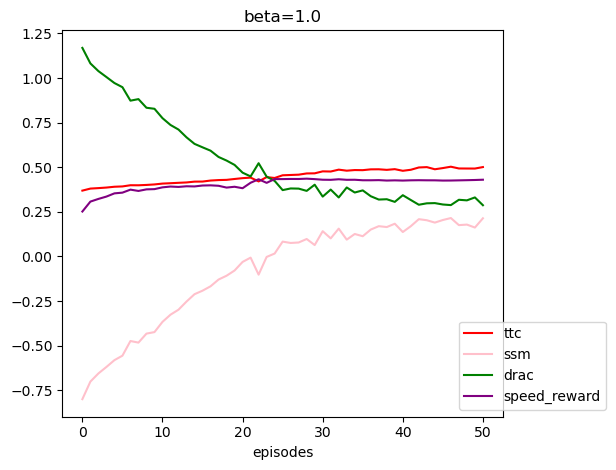

In [75]:
# plot training ttc/drac vs speed for each beta

# x = np.arange(51)

b=10
beta = b/10
cur_dir = f'{exp_dir}/{beta}'
train_df = pd.read_csv(f'{cur_dir}/train_results.csv')

ttc_y, ttc_std = train_df['ttc_mean'], train_df['ttc_std']
speed_y, speed_std = train_df['speed_rl'], train_df['speed_rl_std']

drac_y, drac_std = 3*train_df['drac_mean'], train_df['drac_std']
speed_reward_y, speed_reward_std = train_df['speed_reward_mean'], train_df['speed_reward_std']
ssm_y = ttc_y-drac_y
# ssm_y, ssm_std = train_df['ssm_mean'], train_df['ssm_std']
reward_y = 100*train_df['reward_mean']

x = np.arange(len(speed_y))


plt.title(f'beta={beta}')
plt.plot(x, ttc_y, color='red', label='ttc')
# plt.fill_between(x, ttc_y-ttc_std, ttc_y+ttc_std, color='red', alpha=0.2, label='ttc ± 1 std')
# plt.plot(x, speed_y, color='blue', label='speed_rl')
# plt.fill_between(x, speed_y-speed_std, speed_y+speed_std, color='blue', alpha=0.2, label='speed_rl ± 1 std')
plt.plot(x, ssm_y, color='pink', label='ssm')
# plt.fill_between(x, ssm_y-ssm_std, ssm_y+ssm_std, color='pink', alpha=0.2, label='ssm ± 1 std')

plt.plot(x, drac_y, color='green', label='drac')
# plt.fill_between(x, drac_y-drac_std, drac_y+drac_std, color='green', alpha=0.2, label='drac ± 1 std')
plt.plot(x, speed_reward_y, color='purple', label='speed_reward')
# plt.fill_between(x, speed_reward_y-speed_reward_std, speed_reward_y+speed_reward_std, color='purple', alpha=0.2, label='spd_rwd ± 1 std')
# plt.plot(x, reward_y, color='blue', label='reward')

plt.xlabel('episodes')

plt.legend(loc='lower right', bbox_to_anchor=(1.25, 0))
plt.tight_layout()
plt.show()

In [13]:
# train

output_logs = []

b=5
beta = b/10
cur_dir = f'{exp_dir}/{beta}'
Path(f'{cur_dir}').mkdir(parents=True, exist_ok=True)
output_log_name = f'{cur_dir}/train{beta}.log'
train_script_text = single_ring_train_script_text(output_log=output_log_name, run_dir=cur_dir, beta=beta)
train_script_path = f'{cur_dir}/train{beta}.sh'
create_file_with_contents(train_script_path, train_script_text)
out, err = submit_job(train_script_path)
output_logs += [output_log_name]
print(output_logs)

File 'pareto/single_ring/from_scratch_ttc_drac/0.0/train0.0.sh' created successfully with contents.
Submitted batch job 25420822
LLGrid: TXE1 (running slurm-wlm 23.02.7)
 
File 'pareto/single_ring/from_scratch_ttc_drac/0.1/train0.1.sh' created successfully with contents.
Submitted batch job 25420823
LLGrid: TXE1 (running slurm-wlm 23.02.7)
 
File 'pareto/single_ring/from_scratch_ttc_drac/0.2/train0.2.sh' created successfully with contents.
Submitted batch job 25420824
LLGrid: TXE1 (running slurm-wlm 23.02.7)
 
File 'pareto/single_ring/from_scratch_ttc_drac/0.3/train0.3.sh' created successfully with contents.
Submitted batch job 25420825
LLGrid: TXE1 (running slurm-wlm 23.02.7)
 
File 'pareto/single_ring/from_scratch_ttc_drac/0.4/train0.4.sh' created successfully with contents.
Submitted batch job 25420826
LLGrid: TXE1 (running slurm-wlm 23.02.7)
 
File 'pareto/single_ring/from_scratch_ttc_drac/0.5/train0.5.sh' created successfully with contents.
Submitted batch job 25420827
LLGrid: TXE

In [48]:
# verify successful train
verify_multiple_execution(output_logs) 
    
# eval
output_logs = []

for b in range(11):
    beta = b/10
    cur_dir = f'{exp_dir}/{beta}'
    output_log_name = f'{cur_dir}/eval{beta}.log'
    eval_script_text = single_ring_eval_script_text(output_log=output_log_name, run_dir=cur_dir, result_save=f'{cur_dir}/eval.csv', vehicle_info_save=f'{cur_dir}/trajectory.npz')
    eval_script_path = f'{cur_dir}/eval{beta}.sh'
    create_file_with_contents(eval_script_path, eval_script_text)
    out, err = submit_job(eval_script_path)
    print(out, err)
    output_logs += [output_log_name]

all scripts success!
File 'pareto/single_ring/from_scratch_ttc_drac/0.0/eval0.0.sh' created successfully with contents.
Submitted batch job 25412657
LLGrid: TXE1 (running slurm-wlm 23.02.7)
 
File 'pareto/single_ring/from_scratch_ttc_drac/0.1/eval0.1.sh' created successfully with contents.
Submitted batch job 25412658
LLGrid: TXE1 (running slurm-wlm 23.02.7)
 
File 'pareto/single_ring/from_scratch_ttc_drac/0.2/eval0.2.sh' created successfully with contents.
Submitted batch job 25412659
LLGrid: TXE1 (running slurm-wlm 23.02.7)
 
File 'pareto/single_ring/from_scratch_ttc_drac/0.3/eval0.3.sh' created successfully with contents.
Submitted batch job 25412660
LLGrid: TXE1 (running slurm-wlm 23.02.7)
 
File 'pareto/single_ring/from_scratch_ttc_drac/0.4/eval0.4.sh' created successfully with contents.
Submitted batch job 25412661
LLGrid: TXE1 (running slurm-wlm 23.02.7)
 
File 'pareto/single_ring/from_scratch_ttc_drac/0.5/eval0.5.sh' created successfully with contents.
Submitted batch job 25412

In [ ]:
# verify successful eval
verify_multiple_execution(output_logs)

FileNotFoundError: [Errno 2] No such file or directory: 'pareto/single_ring/from_scratch_ttc_drac_ssm_scaling/0.1/train_results.csv'

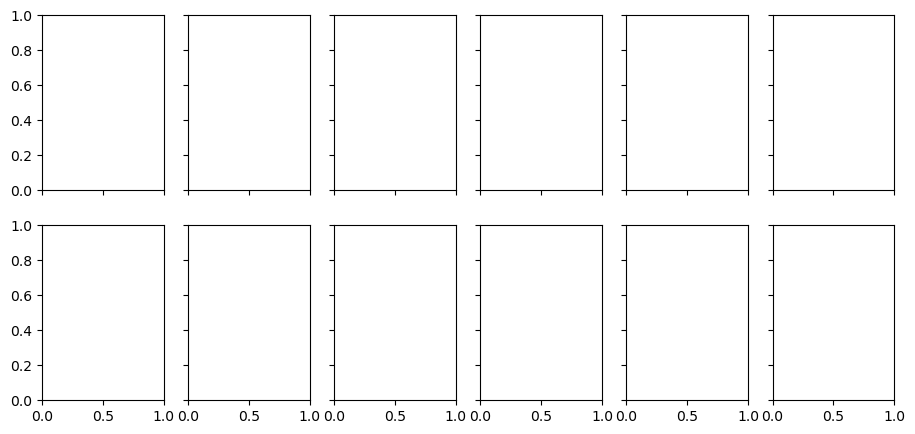

In [32]:
# plot training ttc vs speed for each beta

fig, axs = plt.subplots(2, 6, figsize=(11, 5), sharex=True, sharey=True)
axs_flat = axs.flatten()
x = np.arange(51)

for b in range(1, 11):
    beta = b/10
    cur_dir = f'{exp_dir}/{beta}'
    train_df = pd.read_csv(f'{cur_dir}/train_results.csv')
    
    ttc_y, ttc_std = train_df['ttc_mean']/7, train_df['ttc_std']/7
    speed_y, speed_std = train_df['speed_rl'], train_df['speed_rl_std']
    
    drac_y, drac_std = train_df['drac_mean']*1500, train_df['drac_std']*50
    speed_reward_y, speed_reward_std = train_df['speed_reward_mean']/10, train_df['speed_reward_std']/10
    
    ax = axs_flat[b]
    ax.set_title(f'beta={beta}')
    ax.plot(x, ttc_y, color='red', label='ttc')
    ax.fill_between(x, ttc_y-ttc_std, ttc_y+ttc_std, color='red', alpha=0.2, label='ttc ± 1 std')
    # ax.plot(x, speed_y, color='blue', label='speed_rl')
    # ax.fill_between(x, speed_y-speed_std, speed_y+speed_std, color='blue', alpha=0.2, label='speed_rl ± 1 std')
    
    # ax.plot(x, drac_y, color='green', label='drac')
    # ax.fill_between(x, drac_y-drac_std, drac_y+drac_std, color='green', alpha=0.2, label='drac ± 1 std')
    ax.plot(x, speed_reward_y, color='purple', label='speed_reward')
    ax.fill_between(x, speed_reward_y-speed_reward_std, speed_reward_y+speed_reward_std, color='purple', alpha=0.2, label='spd_rwd ± 1 std')
    
    
    ax.set_xlabel('episodes')

plt.suptitle('Single Ring TTC, DRAC, speed_RL during training from scratch')
axs[-1, -1].axis('off')
legend_handles, legend_labels = axs_flat[0].get_legend_handles_labels()
plt.legend(handles=legend_handles, labels=legend_labels, loc='lower right', bbox_to_anchor=(1.25, 0))
plt.tight_layout()
plt.show()

In [ ]:
# plot pareto curve

ttcs = []
speeds = []

for b in range(11):
    beta = b/10
    cur_dir = f'{exp_dir}/{beta}'
    eval_df = pd.read_csv(f'{cur_dir}/eval.csv')
    
    ttcs += [np.mean(eval_df['ttc_mean'])/7]
    speeds += [np.mean(eval_df['speed_rl'])/10]
    
plt.scatter(ttcs, speeds, c=np.arange(11), cmap='plasma')

for i, (xi, yi) in enumerate(zip(ttcs, speeds)):
    plt.annotate(f'{i/10}', (xi, yi), textcoords="offset points", xytext=(2,5),
                 ha='center', fontsize=8)

plt.title('Single Ring training from scratch: TTC-Speed Pareto')
plt.tight_layout()
plt.show()

## double ring

#### helper funcs

In [5]:
double_folder = f"{os.environ.get('F')}/pareto/double_ring"
double_num_runs = 3 #number of training runs for each experiment

def double_ring_train_script_text(
        output_log='output-%j.log',
        run_dir='.', 
        n_lanes=2,
        n_steps=100,
        worker_kwargs=[{'circumference':250}], 
        n_workers=40,
        n_rollouts_per_step=40, 
        warmup_steps=2000,
        skip_stat_steps=5000,
        horizon=5000,
        global_reward=True,
        # n_steps=100, # default 100
        alg='TRPO',
        use_critic=False,
        gamma=0.999,
        beta=0,
        scale_ttc=1,
        scale_pet=1,
        scale_drac=1,
        seed_np=False,
        seed_torch=False,
    ): # format into script runnable on supercloud
    script_text = (f'''#!/bin/sh

#SBATCH -o {output_log}
#SBATCH --time=72:00:00          # total run time limit (HH:MM:SS)
#SBATCH -c {n_workers}

'''
f'''python $F/ring.py {run_dir} "n_lanes={n_lanes}" "worker_kwargs={worker_kwargs}" "n_workers={n_workers}" "n_rollouts_per_step={n_rollouts_per_step}" "warmup_steps={warmup_steps}"'''
f''' "skip_stat_steps={skip_stat_steps}" "horizon={horizon}" "global_reward={global_reward}" "alg='{alg}'" "use_critic={use_critic}" "gamma={gamma}" "beta={beta}"'''
f''' "n_steps={n_steps}" "scale_ttc={scale_ttc}" "scale_pet={scale_pet}" "scale_drac={scale_drac}" "seed_np={seed_np}" "seed_torch={seed_torch}"'''
                  )
    return script_text

def double_ring_eval_script_text(
        output_log='output-%j.log',
        run_dir='.', 
        n_lanes=2,
        e='100',
        warmup_steps=2000,
        skip_stat_steps=5000,
        horizon=1000,
        circumference=250,
        n_steps=10,
        n_rollouts_per_step=1, 
        skip_vehicle_info_stat_steps=False,
        full_rollout_only=True,
        result_save='evaluations/eval.csv',
        vehicle_info_save='trajectories/trajectory.npz',
        save_agent=True,
        beta=0,
        scale_ttc=1,
        scale_drac=1,
    ): # format into script runnable on supercloud
    script_text = (f'''#!/bin/sh

#SBATCH -o {output_log}
#SBATCH --time=72:00:00          # total run time limit (HH:MM:SS)
#SBATCH -c 40

'''
f'''python $F/ring.py {run_dir} "e={e}" "circumference={circumference}" "warmup_steps={warmup_steps}" "skip_stat_steps={skip_stat_steps}" "horizon={horizon}" "n_steps={n_steps}"'''
f''' "n_rollouts_per_step={n_rollouts_per_step}" "skip_vehicle_info_stat_steps={skip_vehicle_info_stat_steps}" "full_rollout_only={full_rollout_only}"'''
f''' "beta={beta}" "result_save={result_save}" "vehicle_info_save={vehicle_info_save}" "save_agent={save_agent}" "scale_ttc={scale_ttc}" "scale_drac={scale_drac}" '''
                  )
    return script_text


##### find seed


In [14]:
import random
double_ring_seed_dir = f'{double_folder}/seeding'
Path(f'{double_ring_seed_dir}').mkdir(parents=True, exist_ok=True)

def seed_double(torch_seeds, np_seeds, num_runs=1):
    output_logs = []
    for i in range(8):
        for r in range(num_runs):
            torch_seed, np_seed = torch_seeds[i], np_seeds[i]
            cur_dir = f'{single_ring_seed_dir}/beta0.5_SSM1_torch{torch_seed}_np{np_seed}_{r}'
            Path(f'{cur_dir}').mkdir(parents=True, exist_ok=True)
            output_log_name = f'{cur_dir}/train.log'
            train_script_text = single_ring_train_script_text(output_log=output_log_name, run_dir=cur_dir, beta=0.5, n_steps=175, seed_torch=torch_seed, seed_np=np_seed)
            train_script_path = f'{cur_dir}/traintorch{torch_seed}_np{np_seed}_{r}_beta0.5_SSM1.sh'
            create_file_with_contents(train_script_path, train_script_text)
            out, err = submit_job(train_script_path)
            output_logs += [output_log_name]
    return output_logs

In [15]:
random_torch_seeds = [random.randint(0, 1000000) for _ in range(8)]

seed_seq = np.random.SeedSequence()
random_np_seeds = seed_seq.generate_state(8)

print(random_torch_seeds)
print(random_np_seeds)

outputs = seed_double(random_torch_seeds, random_np_seeds, 2)
print(outputs)

[294334, 789334, 2230, 719900, 163294, 472352, 768924, 78194]
[3695343398 3809329783 1406418984  932307645 1823195711 3440784316
  410281240 4140499927]
['pareto/single_ring/seeding/beta0.5_SSM1_torch294334_np3695343398_0/train.log', 'pareto/single_ring/seeding/beta0.5_SSM1_torch294334_np3695343398_1/train.log', 'pareto/single_ring/seeding/beta0.5_SSM1_torch789334_np3809329783_0/train.log', 'pareto/single_ring/seeding/beta0.5_SSM1_torch789334_np3809329783_1/train.log', 'pareto/single_ring/seeding/beta0.5_SSM1_torch2230_np1406418984_0/train.log', 'pareto/single_ring/seeding/beta0.5_SSM1_torch2230_np1406418984_1/train.log', 'pareto/single_ring/seeding/beta0.5_SSM1_torch719900_np932307645_0/train.log', 'pareto/single_ring/seeding/beta0.5_SSM1_torch719900_np932307645_1/train.log', 'pareto/single_ring/seeding/beta0.5_SSM1_torch163294_np1823195711_0/train.log', 'pareto/single_ring/seeding/beta0.5_SSM1_torch163294_np1823195711_1/train.log', 'pareto/single_ring/seeding/beta0.5_SSM1_torch472352

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


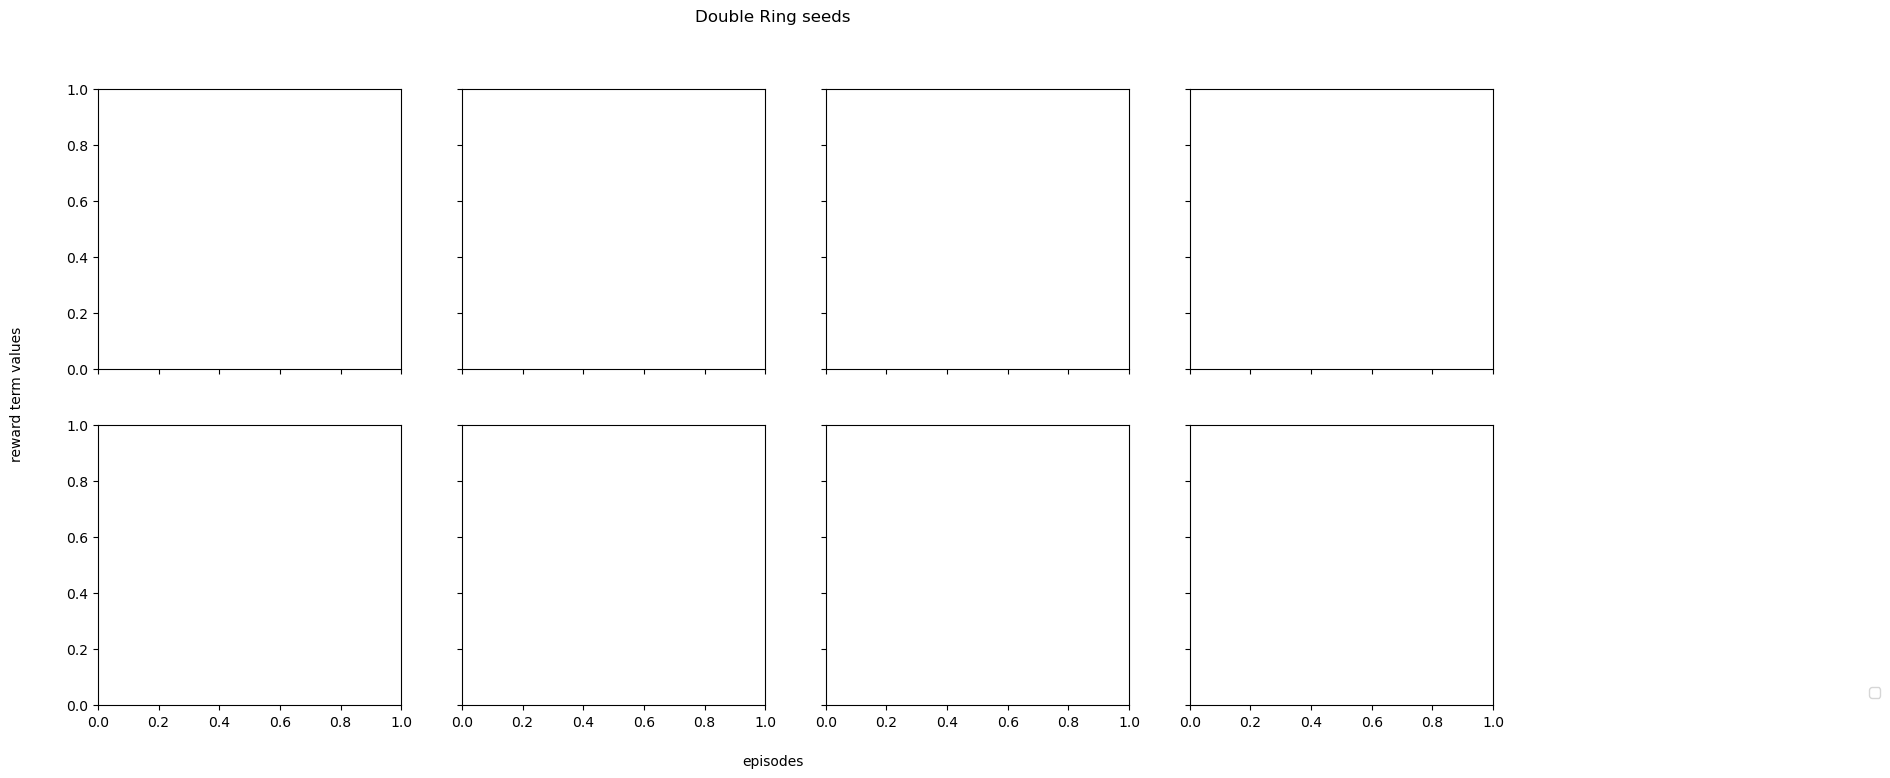

In [16]:
# train progress: plot rewards for each seed

fig, axs = plt.subplots(2, 4, figsize=(18, 8),  sharex=True, sharey=True)
axs_flat = axs.flatten()

cmap_plasma = plt.cm.get_cmap('plasma')
colors = [cmap_plasma(i / (5 - 1)) for i in range(5)] # split plasma into 12 colors

random_torch_seeds = [294334, 789334, 2230, 719900, 163294, 472352, 768924, 78194]
random_np_seeds = [3695343398, 3809329783, 1406418984,  932307645, 1823195711, 3440784316, 410281240, 4140499927]


for i in range(8):
    for r in range(2):
        torch_seed, np_seed = random_torch_seeds[i], random_np_seeds[i]
        cur_dir = f'{double_ring_seed_dir}/beta0.5_SSM1_torch{torch_seed}_np{np_seed}_{r}'
        train_csv = f'{cur_dir}/train_results.csv'
        if os.path.exists(train_csv):
            try:
                train_df = pd.read_csv(train_csv)
                ttc_y, ttc_std = train_df['ttc_mean'], train_df['ttc_std']
                speed_y, speed_std = train_df['speed_reward_mean'], train_df['speed_reward_std']
                drac_y, drac_std = -train_df['drac_mean'], train_df['drac_std']
                ssm_y, ssm_std = train_df['ssm_mean'], train_df['ssm_std']

                x = np.arange(len(speed_y))

                # pet_y = train_df['pet_mean']
                # ax.plot(x, pet_y, color='orange', label='pet')

                ax = axs_flat[i]
                ax.set_title(f'torch seed {torch_seed}, np seed {np_seed}')
                # ax.plot(x, ttc_y, color=colors[0], label=f'TTC run{i}')
                # ax.fill_between(x, ttc_y-ttc_std, ttc_y+ttc_std, color='red', alpha=0.2)
                # ax.plot(x, drac_y, color=colors[1], label=f'-1 * DRAC run{i}')
                # ax.fill_between(x, drac_y-drac_std, drac_y+drac_std, color='purple', alpha=0.2)
                ax.plot(x, ssm_y, color=colors[2], label=f'SSM reward +/- 1 STD')
                # ax.fill_between(x, ssm_y-ssm_std, ssm_y+ssm_std, color='red', alpha=0.2)
                ax.plot(x, speed_y, color=colors[3], label=f'Speed reward +/- 1 STD')
                # ax.fill_between(x, speed_y-speed_std, speed_y+speed_std, color='blue', alpha=0.2)
            except:
                 print(torch_seed, np_seed, r, 'failed')

fig.text(0.5, 0.04, 'episodes', ha='center', va='center') # xlabel
fig.text(0.08, 0.5, 'reward term values', ha='center', va='center', rotation='vertical') # ylabel

plt.suptitle('Double Ring seeds')
legend_handles, legend_labels = axs_flat[0].get_legend_handles_labels()
plt.legend(handles=legend_handles, labels=legend_labels, loc='lower right', bbox_to_anchor=(2.3, 0))
# plt.tight_layout()
plt.show()

##### Scaling SSM reward term (from scratch, TTC & DRAC)

In [15]:
double_ring_scaling_SSM_dir = f'{double_folder}/ssm_scaling'
Path(f'{double_ring_scaling_SSM_dir}').mkdir(parents=True, exist_ok=True)

scale_values=[s/10.0 for s in range(1, 11)]
run_nums=np.arange(double_num_runs)

seed_np=1228644375
seed_torch=106619

In [28]:

def scale_SSM_double(i_scale_pairs):
    output_logs = []
    for i, scale in i_scale_pairs:
        cur_dir = f'{double_ring_scaling_SSM_dir}/beta0.5_SSM{scale}_run{i}'
        Path(f'{cur_dir}').mkdir(parents=True, exist_ok=True)
        output_log_name = f'{cur_dir}/train0.5_SSM{scale}_run{i}.log'
        train_script_text = double_ring_train_script_text(output_log=output_log_name, run_dir=cur_dir, beta=0.5, scale_ttc=scale, scale_drac=scale, n_steps=200, seed_np=seed_np, seed_torch=seed_torch)
        train_script_path = f'{cur_dir}/train0.5_SSM{scale}_run{i}.sh'
        create_file_with_contents(train_script_path, train_script_text)
        out, err = submit_job(train_script_path)
        output_logs += [output_log_name]
    return output_logs

In [31]:
scale_SSM_double(product([0, 1], [0.5, 0.3, 0.4, 0.6, 0.8, 0.9, 1.0]))
scale_SSM_double(product([1], [0.7]))

['pareto/double_ring/ssm_scaling/beta0.5_SSM0.7_run1/train0.5_SSM0.7_run1.log']

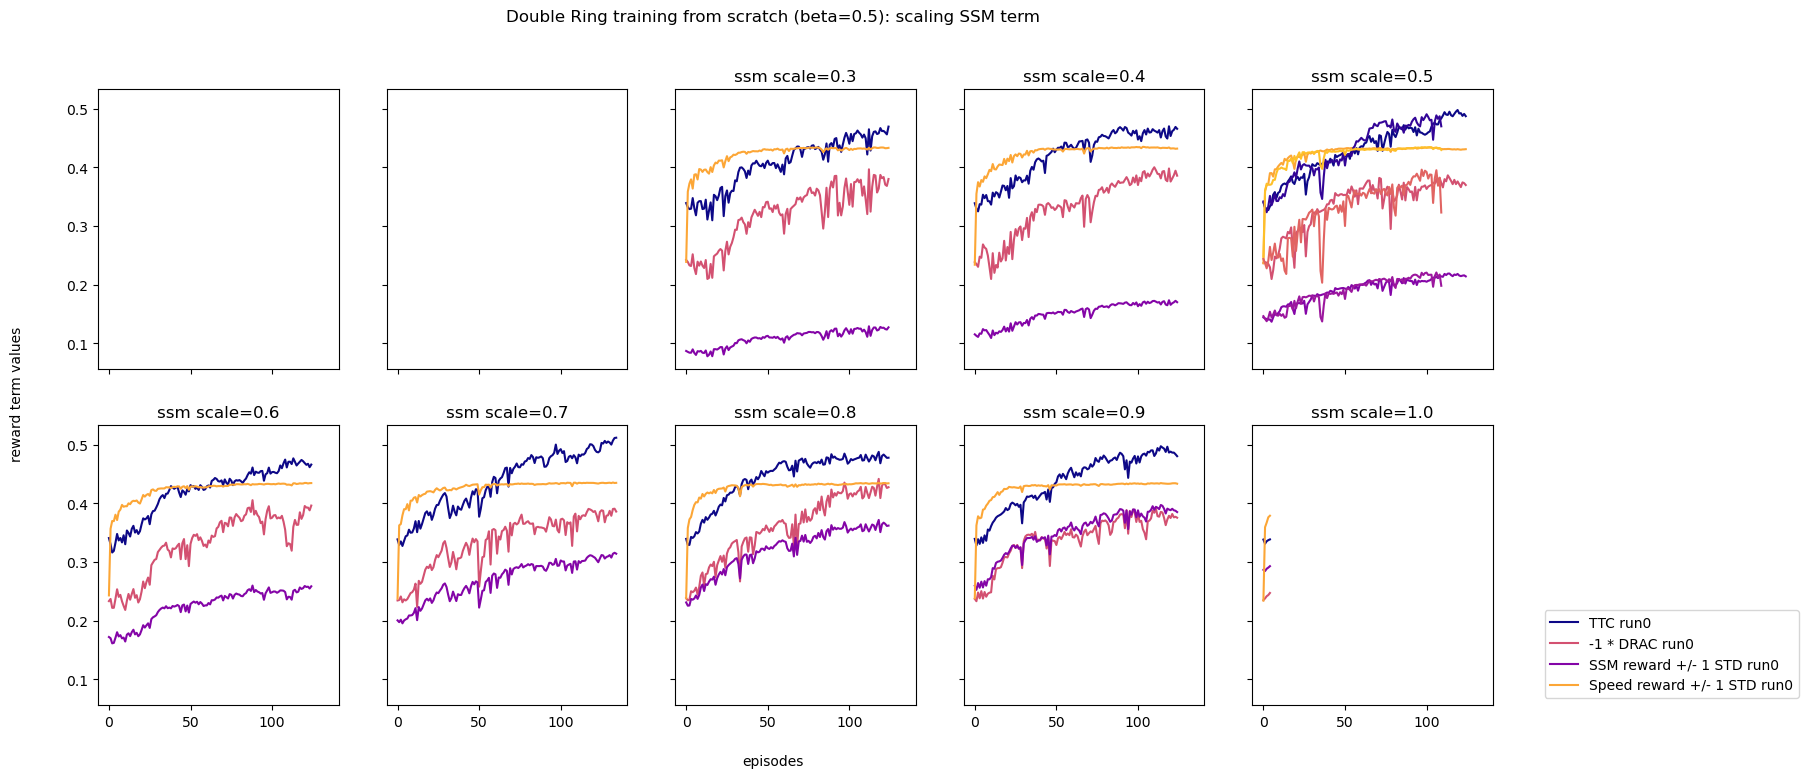

In [39]:
# train progress: plot reward terms for each run of each ssm term scale value

# ssm_term = scale*(ttc - drac)/2
# reward_func = (0.5)*speed_reward + (0.5)*ssm_term

fig, axs = plt.subplots(2, 5, figsize=(18, 8),  sharex=True, sharey=True)
axs_flat = axs.flatten()

cmap_plasma = plt.cm.get_cmap('plasma')
colors = [cmap_plasma(i / (16 - 1)) for i in range(16)] # split plasma into 12 colors

for i, scale in product([0, 1], [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]):
    cur_dir = f'{double_ring_scaling_SSM_dir}/beta0.5_SSM{scale}_run{i}'
    train_csv = f'{cur_dir}/train_results.csv'
    if os.path.exists(train_csv):
        try:
            # print(i,scale)
            train_df = pd.read_csv(train_csv)
            ttc_y, ttc_std = train_df['ttc_mean'], train_df['ttc_std']
            speed_y, speed_std = train_df['speed_reward_mean'], train_df['speed_reward_std']
            drac_y, drac_std = -train_df['drac_mean'], train_df['drac_std']
            ssm_y, ssm_std = train_df['ssm_mean'], train_df['ssm_std']

            x = np.arange(len(speed_y))

            # pet_y = train_df['pet_mean']
            # ax.plot(x, pet_y, color='orange', label='pet')

            ax = axs_flat[int(10*scale)-1]
            ax.set_title(f'ssm scale={scale}')
            
            ax.plot(x, ttc_y, color=colors[i], label=f'TTC run{i}')
            # ax.fill_between(x, ttc_y-ttc_std, ttc_y+ttc_std, color='red', alpha=0.2)
            ax.plot(x, drac_y, color=colors[i+8], label=f'-1 * DRAC run{i}')
            # ax.fill_between(x, drac_y-drac_std, drac_y+drac_std, color='purple', alpha=0.2)
            ax.plot(x, ssm_y, color=colors[i+4], label=f'SSM reward +/- 1 STD run{i}')
            # ax.fill_between(x, ssm_y-ssm_std, ssm_y+ssm_std, color='red', alpha=0.2)
            ax.plot(x, speed_y, color=colors[i+12], label=f'Speed reward +/- 1 STD run{i}')
            # ax.fill_between(x, speed_y-speed_std, speed_y+speed_std, color='blue', alpha=0.2)
        except:
            print(i,scale)

fig.text(0.5, 0.04, 'episodes', ha='center', va='center') # xlabel
fig.text(0.08, 0.5, 'reward term values', ha='center', va='center', rotation='vertical') # ylabel

plt.suptitle('Double Ring training from scratch (beta=0.5): scaling SSM term')
legend_handles, legend_labels = axs_flat[6].get_legend_handles_labels()
plt.legend(handles=legend_handles, labels=legend_labels, loc='lower right', bbox_to_anchor=(2.3, 0))
# plt.tight_layout()
plt.show()

##### From scratch

In [7]:
double_scratch_exp_dir = f'{double_folder}/from_scratch'
Path(f'{double_scratch_exp_dir}').mkdir(parents=True, exist_ok=True)

beta_values=[b/10.0 for b in range(11)]
run_nums=np.arange(double_num_runs)

seed_np=1228644375
seed_torch=106619

scale_ttc=0.6
scale_drac=1.0
n_steps=250

In [15]:
# train
def train_double_scratch(i_beta_pairs):
    output_logs = []
    for i, beta in i_beta_pairs:
        cur_dir = f'{double_scratch_exp_dir}/{beta}_{i}'
        Path(f'{cur_dir}').mkdir(parents=True, exist_ok=True)
        output_log_name = f'{cur_dir}/train{beta}_{i}.log'
        train_script_text = double_ring_train_script_text(output_log=output_log_name, run_dir=cur_dir, beta=beta, scale_ttc=scale_ttc, scale_drac=scale_drac, n_steps=250, seed_np=seed_np, seed_torch=seed_torch)
        train_script_path = f'{cur_dir}/train{beta}_{i}.sh'
        create_file_with_contents(train_script_path, train_script_text)
        out, err = submit_job(train_script_path)
        output_logs += [output_log_name]
    return output_logs


In [22]:
train_double_scratch(product([1], [0.0, 0.1]))

['pareto/double_ring/from_scratch/0.0_1/train0.0_1.log',
 'pareto/double_ring/from_scratch/0.1_1/train0.1_1.log']

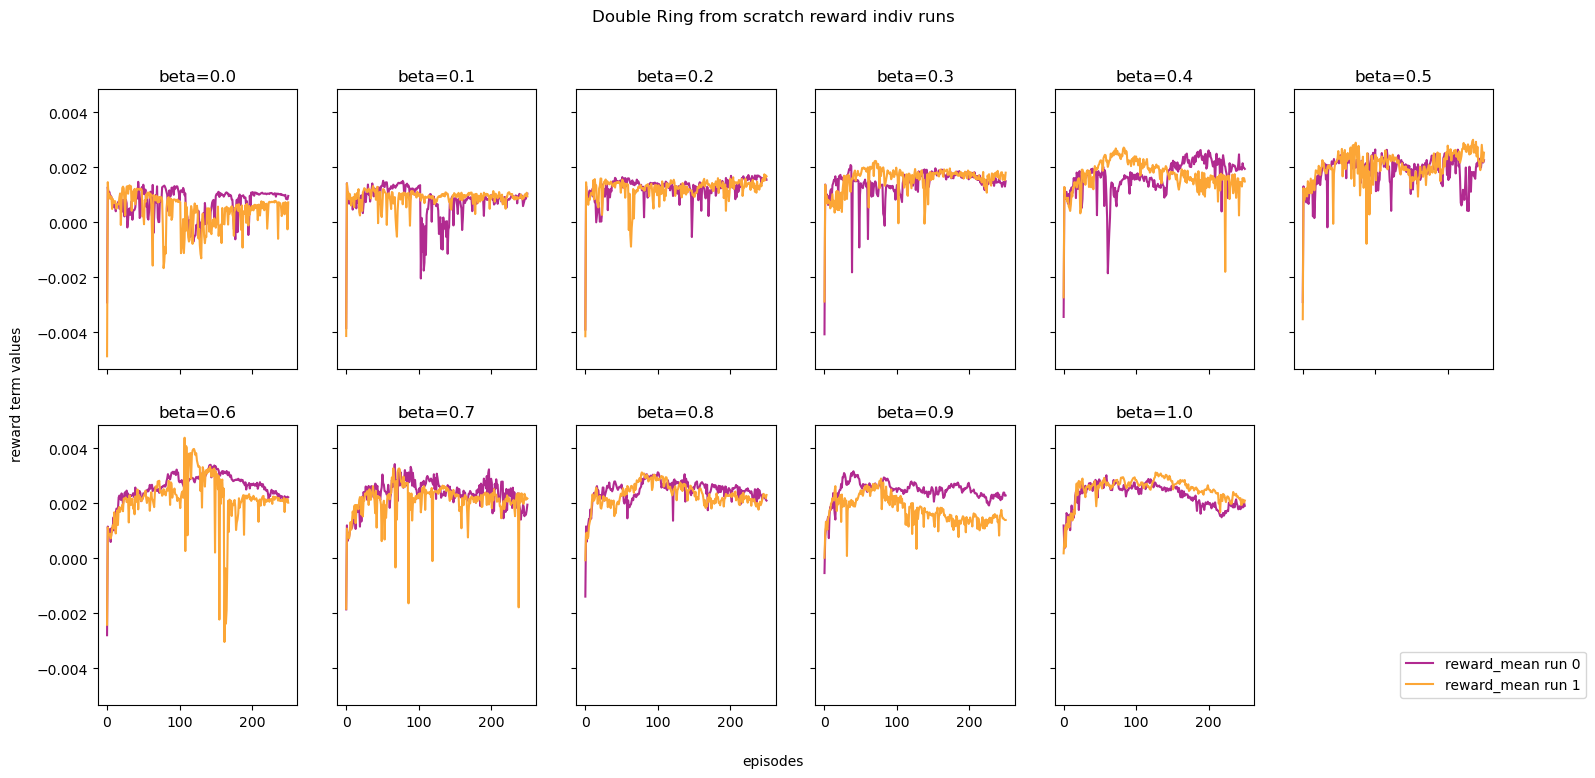

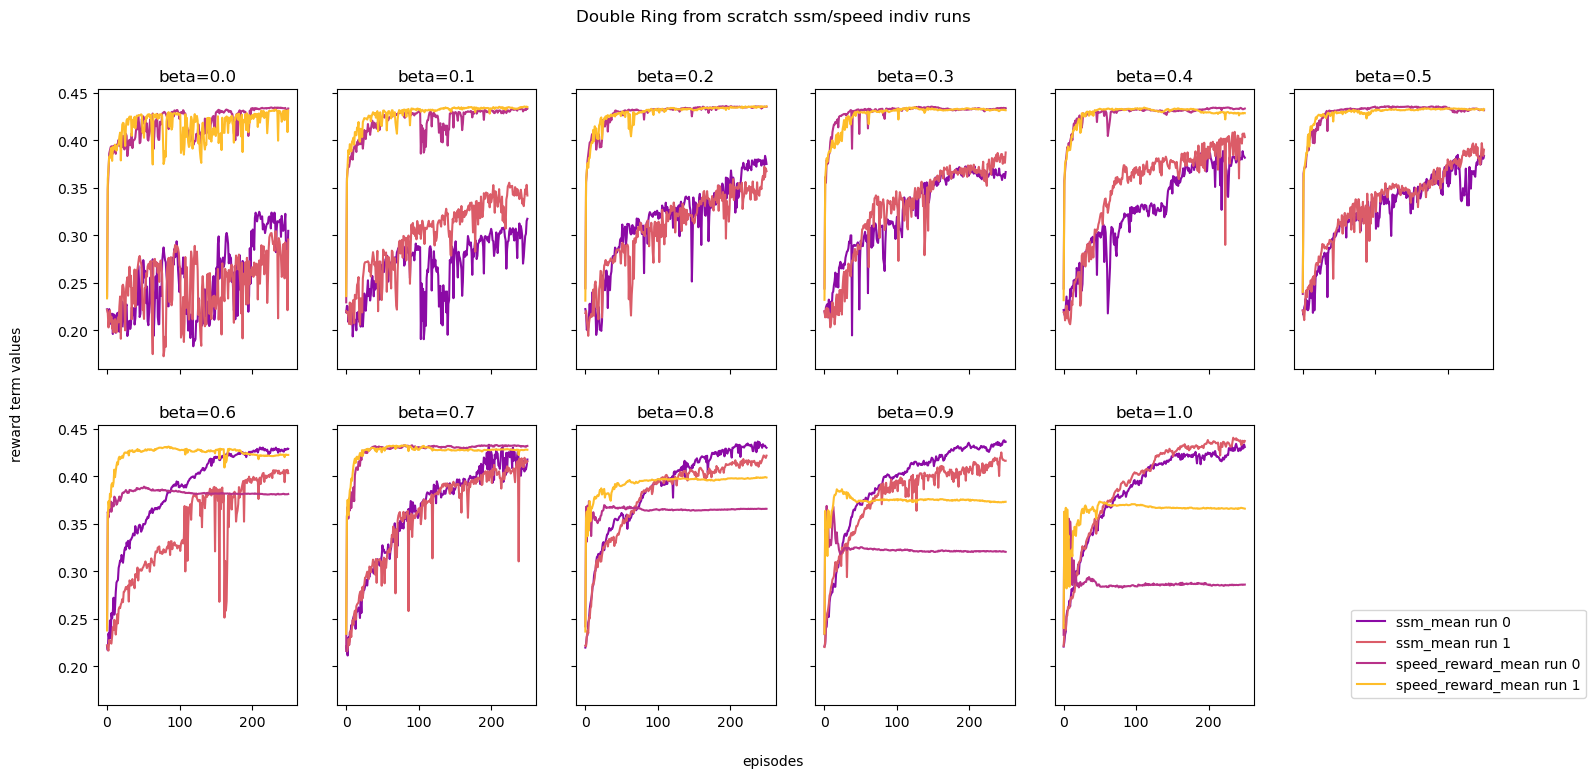

In [90]:
plot_training(double_scratch_exp_dir, ['reward_mean'], [ 0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 'beta', 'Double Ring from scratch reward indiv runs', [0, 1], mean=False, xlen=n_steps)
# plot_training(double_scratch_exp_dir, ['reward_mean'], beta_values, 'beta', 'Double Ring from scratch reward mean', [0], mean=True, xlen=n_steps)

# # plotting ssm and speed for interest
plot_training(double_scratch_exp_dir, ['ssm_mean', 'speed_reward_mean',], [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 'beta', 'Double Ring from scratch ssm/speed indiv runs', [0, 1], mean=False, xlen=n_steps) # 'ttc_mean', 'drac_mean'
# plot_training(double_scratch_exp_dir, ['ssm_mean', 'speed_reward_mean'], beta_values, 'beta', 'Double Ring beta from scratch mean', [0], mean=True, xlen=n_steps)

In [91]:
verify_multiple_execution([f'{double_scratch_exp_dir}/{beta}_{i}/train{beta}_{i}.log' for beta in beta_values for i in [0, 1]], print_success=True)

successful scripts: ['pareto/double_ring/from_scratch/0.0_0/train0.0_0.log', 'pareto/double_ring/from_scratch/0.0_1/train0.0_1.log', 'pareto/double_ring/from_scratch/0.1_0/train0.1_0.log', 'pareto/double_ring/from_scratch/0.1_1/train0.1_1.log', 'pareto/double_ring/from_scratch/0.2_0/train0.2_0.log', 'pareto/double_ring/from_scratch/0.2_1/train0.2_1.log', 'pareto/double_ring/from_scratch/0.3_0/train0.3_0.log', 'pareto/double_ring/from_scratch/0.3_1/train0.3_1.log', 'pareto/double_ring/from_scratch/0.4_0/train0.4_0.log', 'pareto/double_ring/from_scratch/0.4_1/train0.4_1.log', 'pareto/double_ring/from_scratch/0.5_0/train0.5_0.log', 'pareto/double_ring/from_scratch/0.5_1/train0.5_1.log', 'pareto/double_ring/from_scratch/0.6_0/train0.6_0.log', 'pareto/double_ring/from_scratch/0.6_1/train0.6_1.log', 'pareto/double_ring/from_scratch/0.7_0/train0.7_0.log', 'pareto/double_ring/from_scratch/0.7_1/train0.7_1.log', 'pareto/double_ring/from_scratch/0.8_0/train0.8_0.log', 'pareto/double_ring/from_sc

In [104]:
# eval
def eval_double_scratch(i_beta_pairs, e=250):
    output_logs = []
    for i, beta in i_beta_pairs:
        cur_dir = f'{double_scratch_exp_dir}/{beta}_{i}'
        Path(f'{cur_dir}').mkdir(parents=True, exist_ok=True)
        output_log_name = f'{cur_dir}/eval{beta}_{i}.log'
        train_script_text = double_ring_eval_script_text(output_log=output_log_name, run_dir=cur_dir, beta=beta, scale_ttc=scale_ttc, scale_drac=scale_drac, e=e, result_save=f'{cur_dir}/eval_e{e}.csv', vehicle_info_save=f'{cur_dir}/trajectory.npz')
        train_script_path = f'{cur_dir}/eval{beta}_{i}.sh'
        create_file_with_contents(train_script_path, train_script_text)
        out, err = submit_job(train_script_path)
        output_logs += [output_log_name]
    return output_logs


In [111]:
eval_double_scratch(product([0, 1], beta_values), e=245)

['pareto/double_ring/from_scratch/0.0_0/eval0.0_0.log',
 'pareto/double_ring/from_scratch/0.1_0/eval0.1_0.log',
 'pareto/double_ring/from_scratch/0.2_0/eval0.2_0.log',
 'pareto/double_ring/from_scratch/0.3_0/eval0.3_0.log',
 'pareto/double_ring/from_scratch/0.4_0/eval0.4_0.log',
 'pareto/double_ring/from_scratch/0.5_0/eval0.5_0.log',
 'pareto/double_ring/from_scratch/0.6_0/eval0.6_0.log',
 'pareto/double_ring/from_scratch/0.7_0/eval0.7_0.log',
 'pareto/double_ring/from_scratch/0.8_0/eval0.8_0.log',
 'pareto/double_ring/from_scratch/0.9_0/eval0.9_0.log',
 'pareto/double_ring/from_scratch/1.0_0/eval1.0_0.log',
 'pareto/double_ring/from_scratch/0.0_1/eval0.0_1.log',
 'pareto/double_ring/from_scratch/0.1_1/eval0.1_1.log',
 'pareto/double_ring/from_scratch/0.2_1/eval0.2_1.log',
 'pareto/double_ring/from_scratch/0.3_1/eval0.3_1.log',
 'pareto/double_ring/from_scratch/0.4_1/eval0.4_1.log',
 'pareto/double_ring/from_scratch/0.5_1/eval0.5_1.log',
 'pareto/double_ring/from_scratch/0.6_1/eval0.6_

##### finetune

In [8]:
double_finetune_exp_dir = f'{double_folder}/finetune'
Path(f'{double_finetune_exp_dir}').mkdir(parents=True, exist_ok=True)

source_values=[b/10.0 for b in range(11)]
target_values=[b/10.0 for b in range(11)]
run_nums=np.arange(double_num_runs)

seed_np=1228644375
seed_torch=106619
scale_ttc=0.6
scale_drac=1.0
# n_steps=150

source_e=245
additional_e=200
double_source_best_runs_per_beta = get_best_run(double_scratch_exp_dir, source_e, beta_values, [0,1])
print(double_source_best_runs_per_beta)

2 0.0
2 0.1
2 0.2
2 0.3
2 0.4
2 0.5
2 0.6
2 0.7
2 0.8
2 0.9
2 1.0
{0.0: 1, 0.1: 1, 0.2: 1, 0.3: 1, 0.4: 1, 0.5: 1, 0.6: 1, 0.7: 0, 0.8: 0, 0.9: 0, 1.0: 1}


In [12]:
def train_double_finetune(i_source_target_triples, prep=True):
    output_logs = []
    for i, s, t in i_source_target_triples:
        source_dir = f'{double_scratch_exp_dir}/{s}_{double_source_best_runs_per_beta[s]}'
        target_dir = f'{double_finetune_exp_dir}/{s}_{double_source_best_runs_per_beta[s]}_e{source_e}_to_{t}_{i}'
        if prep:
            prep_additional_training(source_dir, target_dir, source_e)
        
        output_log_name = f'{target_dir}/train.log'
        train_script_text = double_ring_train_script_text(output_log=output_log_name, run_dir=target_dir, beta=t, scale_ttc=scale_ttc, scale_drac=scale_drac, n_steps=source_e+additional_e, seed_np=seed_np, seed_torch=seed_torch)
        train_script_path = f'{target_dir}/FTtrain{s}to{t}_{i}.sh'
        create_file_with_contents(train_script_path, train_script_text)
        out, err = submit_job(train_script_path)
        output_logs += [output_log_name]
    return output_logs

In [24]:
train_double_finetune(product([1], [0.0], [0.8]), prep=False) 
train_double_finetune(product([1], [0.4], [1.0]), prep=False) 
train_double_finetune(product([1], [0.6], [0.0, 0.2, 0.4, 0.8, 1.0]), prep=False) 
train_double_finetune(product([1], [0.8], [0.0, 0.2, 0.4, 1.0]), prep=False) 

['/home/gridsan/jding/automatic_vehicular_control/automatic_vehicular_control/pareto/double_ring/finetune/0.8_0_e245_to_0.0_1/train.log',
 '/home/gridsan/jding/automatic_vehicular_control/automatic_vehicular_control/pareto/double_ring/finetune/0.8_0_e245_to_0.2_1/train.log',
 '/home/gridsan/jding/automatic_vehicular_control/automatic_vehicular_control/pareto/double_ring/finetune/0.8_0_e245_to_0.4_1/train.log',
 '/home/gridsan/jding/automatic_vehicular_control/automatic_vehicular_control/pareto/double_ring/finetune/0.8_0_e245_to_1.0_1/train.log']

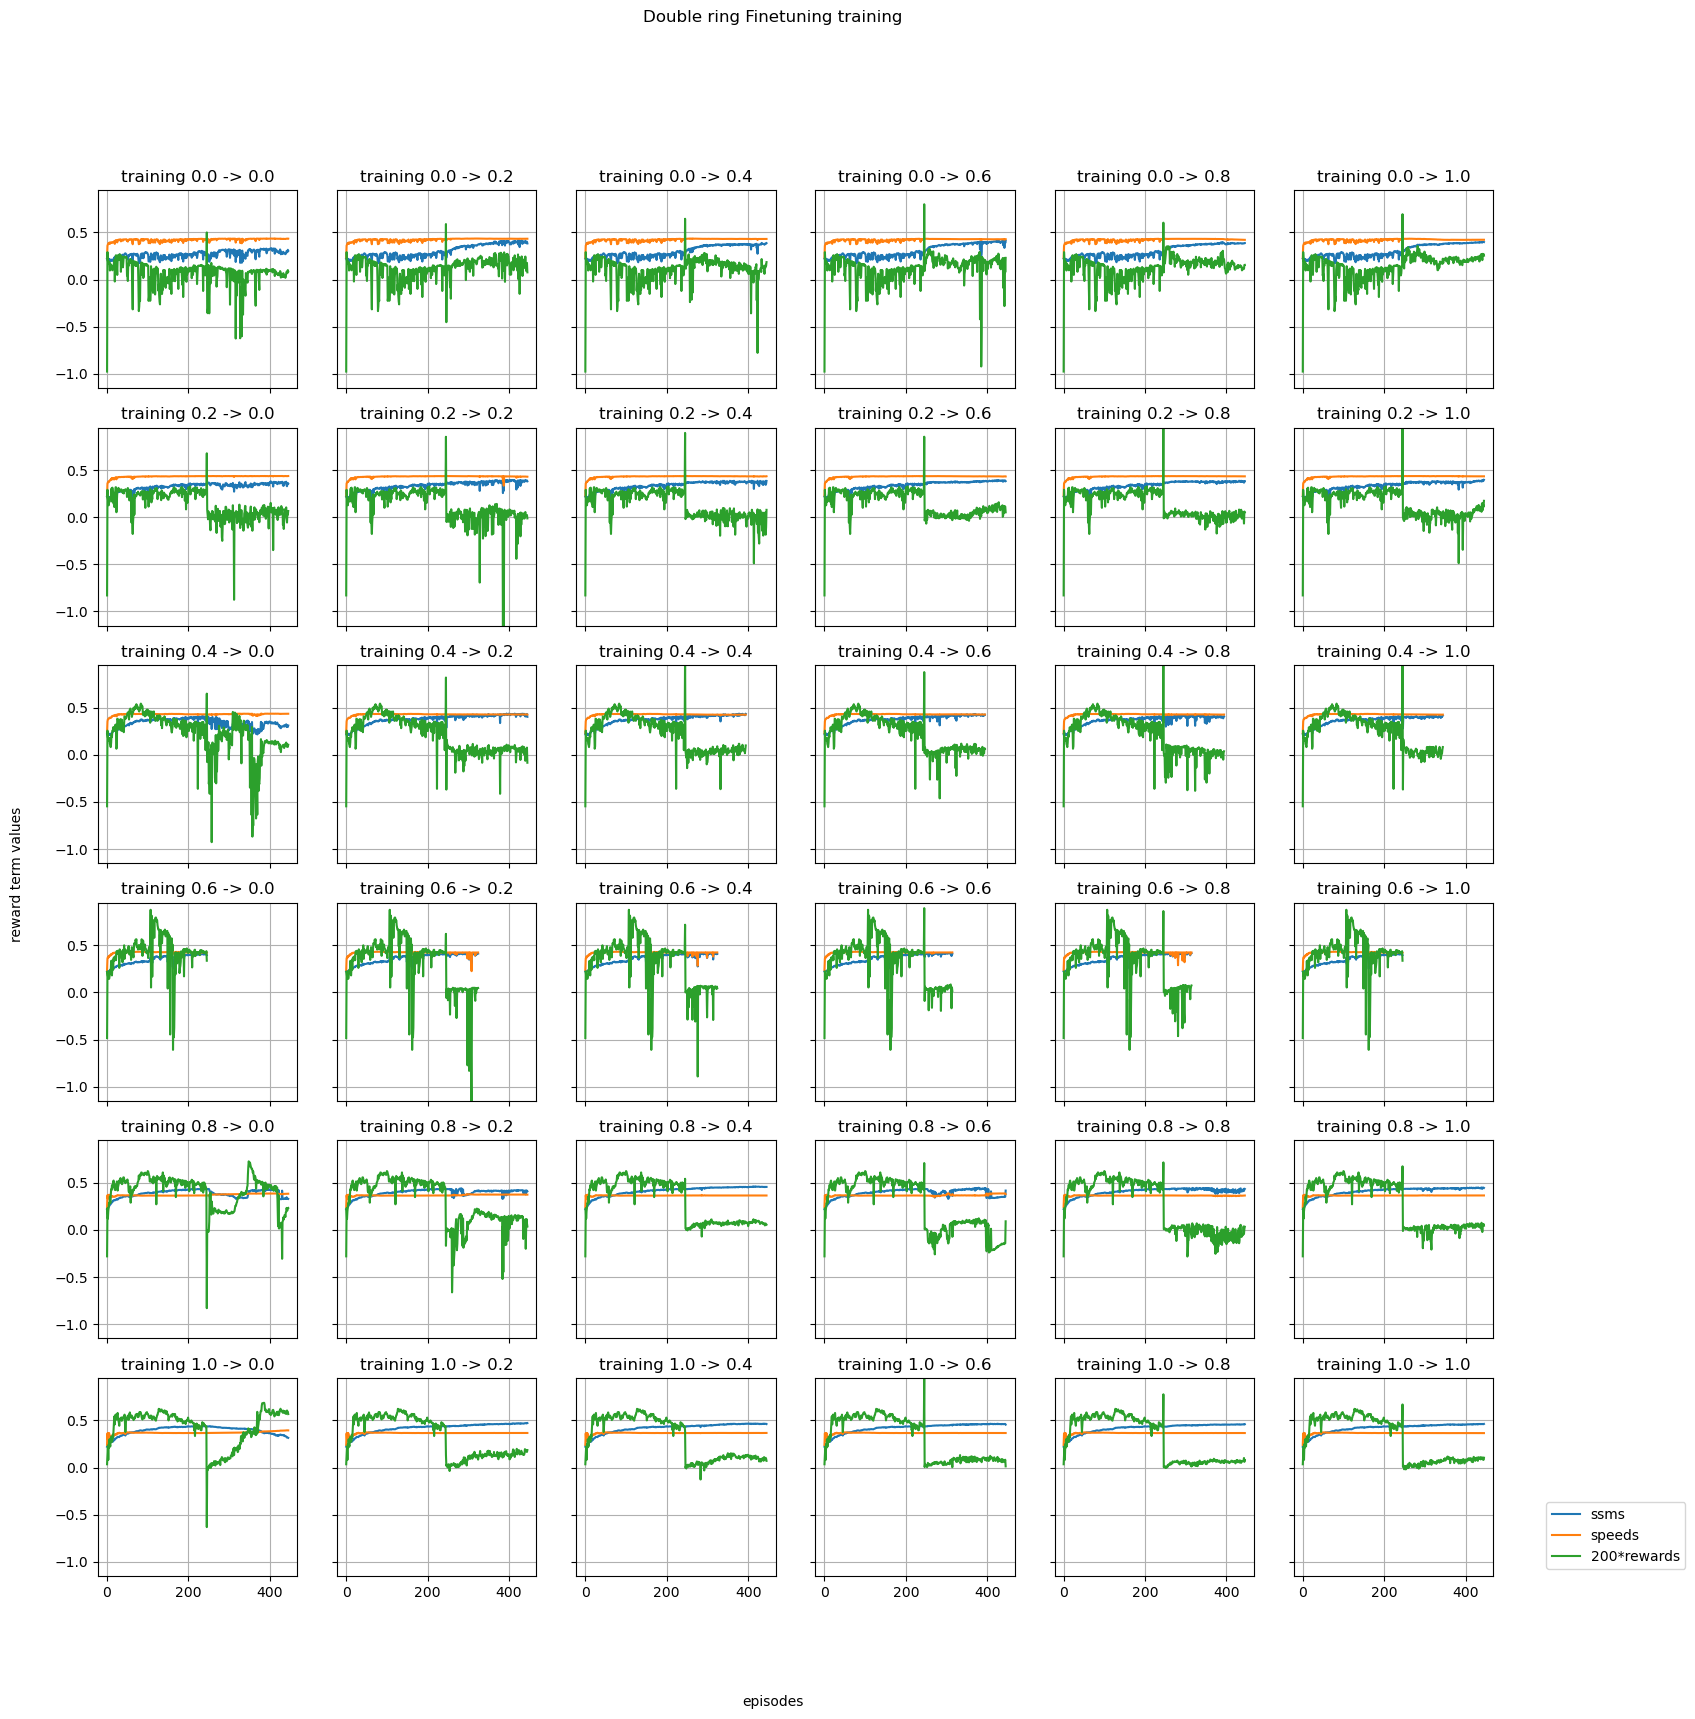

In [29]:
fig, axs = plt.subplots(6, 6, figsize=(18, 18),  sharex=True, sharey=True)
axs_flat = axs.flatten()

for ind, (i, s, t) in enumerate(product([0], [0.0, 0.2, 0.4, 0.6, 0.8, 1.0], [0.0, 0.2, 0.4, 0.6, 0.8, 1.0])):
    target_train_csv = f'{double_finetune_exp_dir}/{s}_{double_source_best_runs_per_beta[s]}_e{source_e}_to_{t}_{i}/train_results.csv'
    # print(target_train_csv)
    try:
        train_df = pd.read_csv(target_train_csv)
        ssms, speeds, rewards = train_df['ssm_mean'], train_df['speed_reward_mean'], train_df['reward_mean']
        
        ax = axs_flat[ind]
        ax.set_title(f'training {s} -> {t}')
        
        ax.plot(np.arange(len(ssms)), ssms, label='ssms')
        ax.plot(np.arange(len(speeds)), speeds, label='speeds')
        ax.plot(np.arange(len(rewards)), 200*rewards, label='200*rewards')
        ax.set_ylim(-1.15, 0.95)
        ax.grid(True)
        
    except Exception as e:
        print(i, s, t)
        print(e)
        
fig.text(0.5, 0.04, 'episodes', ha='center', va='center') # xlabel
fig.text(0.08, 0.5, 'reward term values', ha='center', va='center', rotation='vertical') # ylabel
plt.suptitle('Double ring Finetuning training')
plt.legend(loc='lower right', bbox_to_anchor=(2, 0))
# plt.tight_layout()
plt.show()

In [21]:
# eval finetuning

def eval_double_finetune(i_source_target_triples, e):
    output_logs = []
    for i, s, t in i_source_target_triples:
        try:
            source_dir = f'{double_scratch_exp_dir}/{s}_{double_source_best_runs_per_beta[s]}'
            target_dir = f'{double_finetune_exp_dir}/{s}_{double_source_best_runs_per_beta[s]}_e{source_e}_to_{t}_{i}'

            output_log_name = f'{target_dir}/eval.log'
            eval_script_text = double_ring_eval_script_text(e=e, beta=t, output_log=output_log_name, run_dir=target_dir, result_save=f'{target_dir}/eval_e{e}.csv', vehicle_info_save=f'{target_dir}/trajectory.npz', scale_ttc=scale_ttc, scale_drac=scale_drac)

            eval_script_path = f'{target_dir}/FTeval{s}to{t}_{i}.sh'
            create_file_with_contents(eval_script_path, eval_script_text)
            out, err = submit_job(eval_script_path)
            output_logs += [output_log_name]
        except Exception as exc:
            print(i, s, t)
            print(exc)
    return output_logs

In [ ]:
# eval_double_finetune(product([0,1], [0.0, 0.2, 0.4, 0.6, 0.8, 1.0], [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]))

##### plot all Pareto frontiers (from scratch)

[0.3004965570116181, 0.32415064450184605, 0.35677019217726236, 0.36270855171974953, 0.37398592130512776, 0.3745299178669277, 0.4073984523422334, 0.40488237391048587, 0.41901423445617036, 0.41702840069637703, 0.4257957727916126] [0.43231832743563436, 0.43371613158332967, 0.4349971418823043, 0.43259936195113147, 0.42998199525841285, 0.43158316116711737, 0.40207860004771934, 0.4296028348694081, 0.38271765780054534, 0.3473240044967633, 0.3272216271455298]


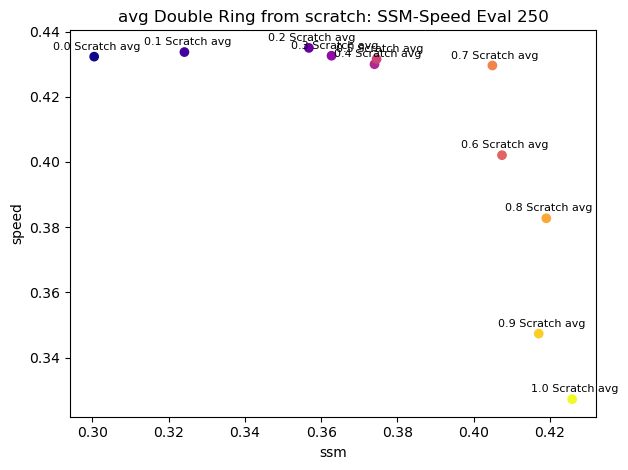

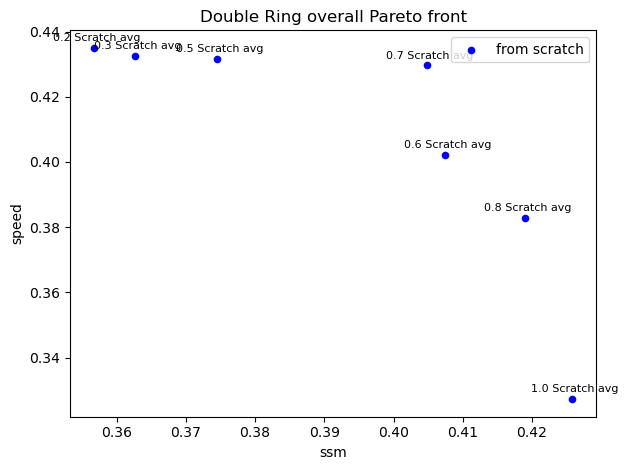

In [100]:
#for training with RT=TRUE, evaluating on RT=TRUE!

#graph all methods' individual pareto

scratch_ssms, scratch_speeds, scratch_labels = plot_avg_eval(double_scratch_exp_dir, 250, beta_values, [0,1], 'avg Double Ring from scratch: SSM-Speed Eval 250')  # avg!
# scratch_ssms, scratch_speeds, scratch_labels = plot_all_eval(double_scratch_exp_dir, 250, beta_values, [0, 1], 'all Double Ring from scratch: SSM-Speed Eval 250')  # all!
# print(scratch_ssms, scratch_speeds, scratch_labels)

# ft_ssms_all, ft_speeds_all, ft_labels_all = get_all_eval_additional_training_methods(single_finetune_exp_dir, [0.0, 0.2, 0.4, 0.6, 0.8, 1.0], [0.0, 0.2, 0.4, 0.6, 0.8, 1.0], 'FT')    
# rt_ssms_all, rt_speeds_all, rt_labels_all = get_all_eval_additional_training_methods(single_restransfer_exp_dir, [0.0, 0.2, 0.4, 0.6, 0.8, 1.0], [0.0, 0.2, 0.4, 0.6, 0.8, 1.0], 'RT')
# a, b, c = get_all_eval_additional_training_methods(single_restransfer_lr_exp_dir, [0.0, 0.2, 0.4, 0.6, 0.8, 1.0], [0.0, 0.2, 0.4, 0.6, 0.8, 1.0], 'RT')
# rt_ssms_all += a
# rt_speeds_all += b 
# rt_labels_all += c
    
# nom_x, nom_y, nom_l = get_mrtl_evals([3], [b/10.0 for b in range(11)], 435)  # multi task base nominal
# nom_res_x, nom_res_y, nom_res_l = get_mrtl_evals([3], beta_values, 635, res_runs=[0], csv_dir=lambda i,b,e,j: f'{single_mrtl_exp_dir}/residual_nom{i}_{j}/eval_beta{b}_e{e}.csv') # multi task nominal, multi task residual
# mtnstr_x, mtnstr_y, mtnstr_l = get_mrtl_evals([3], [0.0, 0.1, 0.3, 0.8, 1.0], 1000, res_runs=[0], csv_dir=lambda i, b, e, j: f'{single_mrtl_exp_dir}/residual_nom{i}_beta{b}_{j}/eval_e{e}.csv') # multi task nominal, single task residual

# get_all_eval_additional_training_methods(exp_dir, target_values, source_values, label_method, i_range=[0,1], e=290, source_e=145)

scratch_p_x, scratch_p_y, scratch_p_l = pareto_frontier(scratch_ssms, scratch_speeds, scratch_labels)
# ft_all_x, ft_all_y, ft_all_l = pareto_frontier(ft_ssms_all, ft_speeds_all, ft_labels_all)
# rt_all_x, rt_all_y, rt_all_l = pareto_frontier(rt_ssms_all, rt_speeds_all, rt_labels_all)

# nom_all_x, nom_all_y, nom_all_l = pareto_frontier(nom_x, nom_y, nom_l)
# nom_res_all_x, nom_res_all_y, nom_res_all_l = pareto_frontier(nom_res_x, nom_res_y, nom_res_l)
# mtnstr_all_x, mtnstr_all_y, mtnstr_all_l = pareto_frontier(mtnstr_x, mtnstr_y, mtnstr_l)



plt.scatter(scratch_p_x, scratch_p_y, color='blue', label='from scratch', s=20)
for (li, xi, yi) in zip( scratch_p_l, scratch_p_x, scratch_p_y):
    plt.annotate(f'{li}', (xi, yi), textcoords="offset points", xytext=(2,5), ha='center', fontsize=8)
    
# plt.scatter(scratch_ssms, scratch_speeds, color='blue', label='from scratch', s=20)
# for (li, xi, yi) in zip( scratch_labels, scratch_ssms, scratch_speeds):
#     plt.annotate(f'{li}', (xi, yi), textcoords="offset points", xytext=(2,5), ha='center', fontsize=8)
# plt.scatter(ft_all_x, ft_all_y, color='red', label='finetune', s=20)
# plt.scatter(rt_all_x, rt_all_y, color='orange', label='residual policy', s=20)

# plt.scatter(nom_all_x, nom_all_y, color='pink', label='multi-task policy', s=20)
# plt.scatter(nom_res_all_x, nom_res_all_y, color='purple', label='MRTL', s=20)
# plt.scatter(mtnstr_all_x, mtnstr_all_y, color='lightgreen', label='MT nom + ST resid', s=20)


# plt.plot(scratch_p_x, scratch_p_y, color='blue', label='from scratch')
# plt.plot(ft_all_x, ft_all_y, color='red', label='finetune')
# plt.plot(rt_all_x, rt_all_y, color='green', label='residual transfer')


# for (li, xi, yi) in zip(ft_all_l, ft_all_x, ft_all_y):
#     plt.annotate(f'{li}', (xi, yi), textcoords="offset points", xytext=(2,5), ha='center', fontsize=8)
# for (li, xi, yi) in zip(rt_all_l, rt_all_x, rt_all_y):
#     plt.annotate(f'{li}', (xi, yi), textcoords="offset points", xytext=(2,5), ha='center', fontsize=8)

# graph overall pareto segments

# all_ssms, all_speeds, all_labels = scratch_p_x+ft_all_x+rt_all_x, scratch_p_y+ft_all_y+rt_all_y, scratch_p_l+ft_all_l+rt_all_l
# all_x, all_y, all_l = pareto_frontier(all_ssms, all_speeds, all_labels)
# scratch_part = []
# ft_part = []
# rt_part = []

# for p in zip(all_x, all_y, all_l):
#     if p in zip(scratch_p_x, scratch_p_y, scratch_p_l):
#         scratch_part += [p]
#     if p in zip(ft_all_x, ft_all_y, ft_all_l):
#         ft_part += [p]
#     if p in zip(rt_all_x, rt_all_y, rt_all_l):
#         rt_part += [p]

    
# if scratch_part:
#     scratch_part_x, scratch_part_y, scratch_part_l = zip(*scratch_part)
#     plt.scatter(scratch_part_x, scratch_part_y, color='blue', label='scratch') 
#     for (xi, yi, li) in scratch_part:
#         plt.annotate(f'{li}', (xi, yi), textcoords="offset points", xytext=(2,5), ha='center', fontsize=8)
# if ft_part:
#     ft_part_x, ft_part_y, ft_part_l = zip(*ft_part)
#     plt.scatter(ft_part_x, ft_part_y, color='red', label='finetune')   
#     for (xi, yi, li) in ft_part:
#         plt.annotate(f'{li}', (xi, yi), textcoords="offset points", xytext=(2,5), ha='center', fontsize=8)
# if rt_part:
#     rt_part_x, rt_part_y, rt_part_l = zip(*rt_part)
#     plt.scatter(rt_part_x, rt_part_y, color='red', label='residual transfer')   
#     for (xi, yi, li) in rt_part:
#         plt.annotate(f'{li}', (xi, yi), textcoords="offset points", xytext=(2,5), ha='center', fontsize=8)

plt.title('Double Ring overall Pareto front')
plt.xlabel('ssm')
plt.ylabel('speed')
# plt.xlim(0.4, 0.6) # careful! set only after plotting without lims
# plt.ylim(0.40, 0.445) # careful! set only after plotting without lims
plt.legend()
plt.tight_layout()
plt.show()

##### ??? gobbledegook

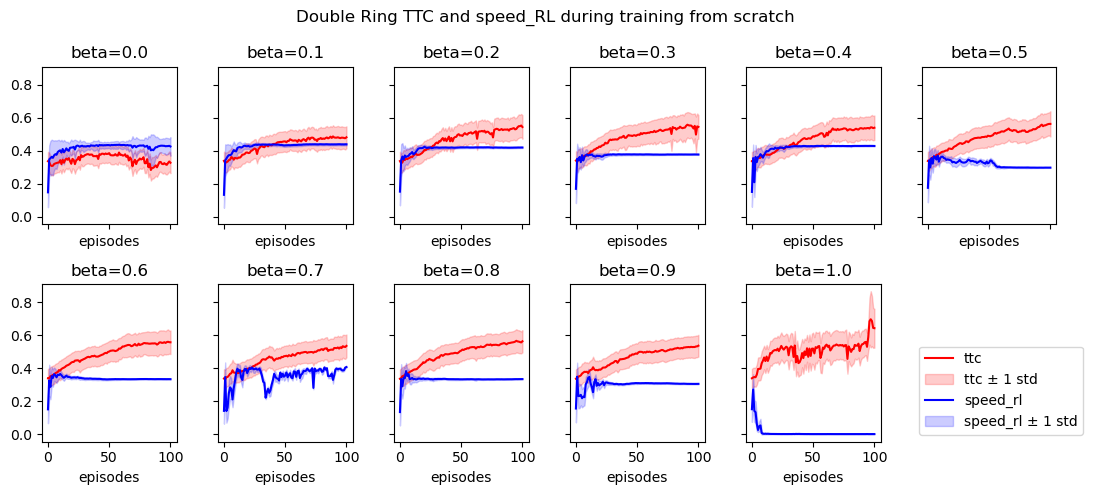

In [6]:
# plot training ttc vs speed for each beta

fig, axs = plt.subplots(2, 6, figsize=(11, 5), sharex=True, sharey=True)
axs_flat = axs.flatten()
x = np.arange(101)

for b in range(11):
    beta = b/10
    cur_dir = f'{exp_dir}/{beta}'
    train_df = pd.read_csv(f'{cur_dir}/train_results.csv')
    
    ttc_y, ttc_std = train_df['ttc_mean']/7, train_df['ttc_std']/7
    speed_y, speed_std = train_df['speed_rl']/10, train_df['speed_rl_std']/10
    
    ax = axs_flat[b]
    ax.set_title(f'beta={beta}')
    ax.plot(x, ttc_y, color='red', label='ttc')
    ax.fill_between(x, ttc_y-ttc_std, ttc_y+ttc_std, color='red', alpha=0.2, label='ttc ± 1 std')
    ax.plot(x, speed_y, color='blue', label='speed_rl')
    ax.fill_between(x, speed_y-speed_std, speed_y+speed_std, color='blue', alpha=0.2, label='speed_rl ± 1 std')
    
    ax.set_xlabel('episodes')

plt.suptitle('Double Ring TTC and speed_RL during training from scratch')
axs[-1, -1].axis('off')
legend_handles, legend_labels = axs_flat[0].get_legend_handles_labels()
plt.legend(handles=legend_handles, labels=legend_labels, loc='lower right', bbox_to_anchor=(1.25, 0))
plt.tight_layout()
plt.show()

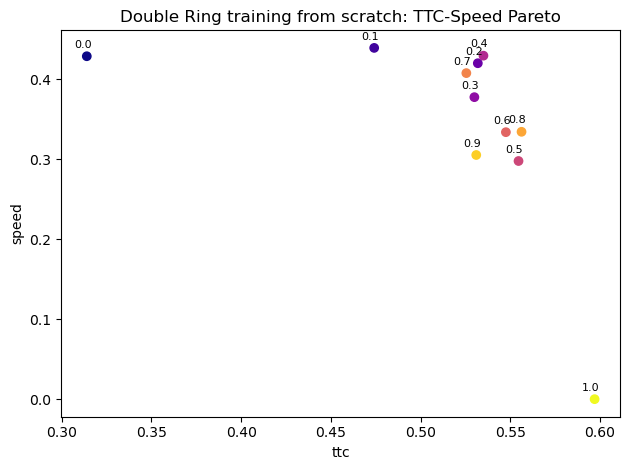

In [72]:
# plot pareto curve

ttcs = []
speeds = []

for b in range(11):
    beta = b/10
    cur_dir = f'{exp_dir}/{beta}'
    eval_df = pd.read_csv(f'{cur_dir}/eval.csv')
    
    ttcs += [np.mean(eval_df['ttc_mean'])/7]
    speeds += [np.mean(eval_df['speed_rl'])/10]
    
plt.scatter(ttcs, speeds, c=np.arange(11), cmap='plasma')

for i, (xi, yi) in enumerate(zip(ttcs, speeds)):
    plt.annotate(f'{i/10}', (xi, yi), textcoords="offset points", xytext=(-3,6),
                 ha='center', fontsize=8)

plt.title('Double Ring training from scratch: TTC-Speed Pareto')
plt.xlabel('ttc')
plt.ylabel('speed')
plt.tight_layout()
plt.show()

## figure eight

#### helper funcs

In [23]:
folder = 'pareto/figure_eight'

fe_testing_exp_dir = f'{folder}/testing'
Path(f'{fe_testing_exp_dir}').mkdir(parents=True, exist_ok=True)

def figure_eight_train_script_text(
        output_log='output-%j.log',
        run_dir='.', 
        worker_kwargs=[{'radius':30}], 
        n_workers=40,
        n_rollouts_per_step=40,
        horizon=20000,
        lr_schedule='cosine',
        alg='TRPO',
        use_critic=False,
        gamma=0.999,
        beta=0,
    ): # format into script runnable on supercloud
    script_text = (f'''#!/bin/sh

#SBATCH -o {output_log}
#SBATCH --time=72:00:00          # total run time limit (HH:MM:SS)
#SBATCH -c 40

'''
f'''python $F/figure_eight.py {run_dir} "n_workers={n_workers}" "n_rollouts_per_step={n_rollouts_per_step}" "worker_kwargs={worker_kwargs}"'''
f''' "horizon={horizon}" "lr_schedule={lr_schedule}" "alg='{alg}'" "use_critic={use_critic}" "gamma={gamma}" "beta={beta}"'''
                  )
    return script_text

def figure_eight_eval_script_text(
        output_log='output-%j.log',
        run_dir='.', 
        e=100,
        radius=30,
        warmup_steps=1000,
        skip_stat_steps=8000,
        horizon=1000,
        n_steps=10,
        n_rollouts_per_step=1, 
        skip_vehicle_info_stat_steps=False,
        full_rollout_only=True,
        result_save='evaluations/eval.csv',
        vehicle_info_save='trajectories/trajectory.npz',
        save_agent=True,
    ): # format into script runnable on supercloud
    script_text = (f'''#!/bin/sh

#SBATCH -o {output_log}
#SBATCH --time=72:00:00          # total run time limit (HH:MM:SS)
#SBATCH -c 40

'''
f'''python $F/figure_eight.py {run_dir} "e={e}" "radius={radius}" "warmup_steps={warmup_steps}" "skip_stat_steps={skip_stat_steps}" "horizon={horizon}" "n_steps={n_steps}"'''
f''' "n_rollouts_per_step={n_rollouts_per_step}" "skip_vehicle_info_stat_steps={skip_vehicle_info_stat_steps}" "full_rollout_only={full_rollout_only}"'''
f''' "result_save={result_save}" "vehicle_info_save={vehicle_info_save}" "save_agent={save_agent}"'''
                  )
    return script_text

##### testing

In [24]:
# train

output_logs = []

b=5
beta = b/10
cur_dir = f'{fe_testing_exp_dir}/{beta}'
Path(f'{cur_dir}').mkdir(parents=True, exist_ok=True)
output_log_name = f'{cur_dir}/train{beta}.log'
train_script_text = figure_eight_train_script_text(output_log=output_log_name, run_dir=cur_dir, beta=beta)
train_script_path = f'{cur_dir}/train{beta}.sh'
create_file_with_contents(train_script_path, train_script_text)
out, err = submit_job(train_script_path)
print(out, err)
output_logs += [output_log_name]

File 'pareto/figure_eight/testing/0.5/train0.5.sh' created successfully with contents.
Submitted batch job 25473778
LLGrid: TXE1 (running slurm-wlm 23.02.7)
 


In [27]:
# verify successful train
verify_multiple_execution(output_logs) 
    
# eval
output_logs = []

b=5
beta = b/10
cur_dir = f'{fe_testing_exp_dir}/{beta}'
output_log_name = f'{cur_dir}/eval{beta}.log'
eval_script_text = single_ring_eval_script_text(output_log=output_log_name, run_dir=cur_dir, result_save=f'{cur_dir}/eval.csv', vehicle_info_save=f'{cur_dir}/trajectory.npz')
eval_script_path = f'{cur_dir}/eval{beta}.sh'
create_file_with_contents(eval_script_path, eval_script_text)
out, err = submit_job(eval_script_path)
print(out, err)
output_logs += [output_log_name]

failed scripts: []
File 'pareto/figure_eight/testing/0.5/eval0.5.sh' created successfully with contents.
Submitted batch job 25474813
LLGrid: TXE1 (running slurm-wlm 23.02.7)
 


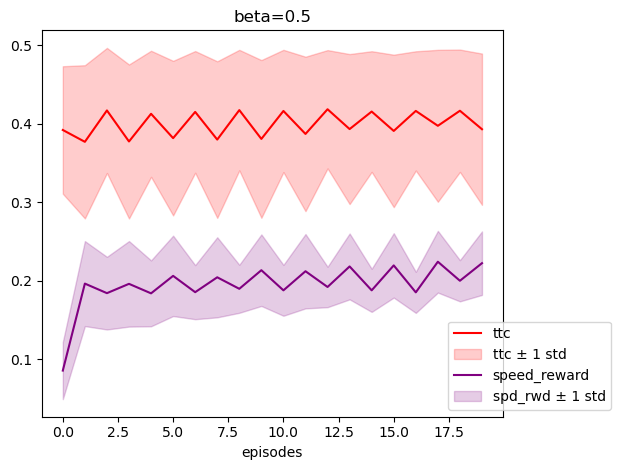

In [29]:
# plot training ttc vs speed for 0.5, see if ttc will converge

# x = np.arange(51)

b=5
beta = b/10
cur_dir = f'{fe_testing_exp_dir}/{beta}'
train_df = pd.read_csv(f'{cur_dir}/train_results.csv')

ttc_y, ttc_std = train_df['ttc_mean'], train_df['ttc_std']
speed_reward_y, speed_reward_std = train_df['speed_reward_mean'], train_df['speed_reward_std']

# speed_y, speed_std = train_df['speed_rl'], train_df['speed_rl_std']
# drac_y, drac_std = train_df['drac_mean'], train_df['drac_std']
# ssm_y = ttc_y-drac_y
# ssm_y, ssm_std = train_df['ssm_mean'], train_df['ssm_std']
# reward_y = train_df['reward_mean']

x = np.arange(len(speed_reward_y))


plt.title(f'beta={beta}')
plt.plot(x, ttc_y, color='red', label='ttc')
plt.fill_between(x, ttc_y-ttc_std, ttc_y+ttc_std, color='red', alpha=0.2, label='ttc ± 1 std')
plt.plot(x, speed_reward_y, color='purple', label='speed_reward')
plt.fill_between(x, speed_reward_y-speed_reward_std, speed_reward_y+speed_reward_std, color='purple', alpha=0.2, label='spd_rwd ± 1 std')

# plt.plot(x, ssm_y, color='pink', label='ssm')
# plt.plot(x, drac_y, color='green', label='drac')
# plt.fill_between(x, drac_y-drac_std, drac_y+drac_std, color='green', alpha=0.2, label='drac ± 1 std')
# plt.plot(x, reward_y, color='blue', label='reward')

plt.xlabel('episodes')

plt.legend(loc='lower right', bbox_to_anchor=(1.25, 0))
plt.tight_layout()

## intersection

#### helper funcs

In [27]:
intersection_folder = f'{wulab}/pareto/intersection'
intersection_num_runs = 2 #number of training runs for each experiment, usually 3

def intersection_train_script_text(
        output_log='output-%j.log',
        run_dir='.', 
        worker_kwargs=[{'flow_rate_h':700,'flow_rate_v':700}], 
        n_workers=45,
        n_rollouts_per_step=45, 
        horizon=2000,
        n_steps=200,
        av_frac=0.333,
        alg='TRPO',
        use_critic=False,
        beta=0,
        scale_pet=1,
        scale_drac=1,
        seed_np=False,
        seed_torch=False,
        residual_transfer=False,
        mrtl=False,
    ): # format into script runnable on supercloud
    script_text = (f'''#!/bin/sh

#SBATCH -o {output_log}
#SBATCH --time=72:00:00          # total run time limit (HH:MM:SS)
#SBATCH -c {n_workers}

'''
f'''python $F/intersection.py {run_dir} "n_workers={n_workers}" "n_rollouts_per_step={n_rollouts_per_step}" "worker_kwargs={worker_kwargs}"'''
f''' "av_frac={av_frac}" "horizon={horizon}" "n_steps={n_steps}" "alg='{alg}'" "use_critic={use_critic}"'''
f''' "beta={beta}" "scale_pet={scale_pet}" "scale_drac={scale_drac}" "seed_np={seed_np}" "seed_torch={seed_torch}" "residual_transfer={residual_transfer}" "mrtl={mrtl}" '''
                  )
    return script_text

def intersection_eval_script_text(
        output_log='output-%j.log',
        run_dir='.', 
        e='200',
        warmup_steps=1000,
        skip_stat_steps=3000,
        horizon=2000,
        flow_rate_h=700,
        flow_rate_v=700,
        n_steps=10,
        n_rollouts_per_step=1, 
        skip_vehicle_info_stat_steps=False,
        full_rollout_only=True,
        result_save='evaluations/eval.csv',
        vehicle_info_save='trajectories/trajectory.npz',
        save_agent=True,
        beta=0,
        scale_pet=1,
        scale_drac=1,
        residual_transfer=False,
        mrtl=False,
    ): # format into script runnable on supercloud
    script_text = (f'''#!/bin/sh

#SBATCH -o {output_log}
#SBATCH --time=72:00:00          # total run time limit (HH:MM:SS)
#SBATCH -c 40

'''
f'''python $F/intersection.py {run_dir} "e={e}" "flow_rate_h={flow_rate_h}" "flow_rate_v={flow_rate_v}" "warmup_steps={warmup_steps}" "skip_stat_steps={skip_stat_steps}" "horizon={horizon}" "n_steps={n_steps}"'''
f''' "n_rollouts_per_step={n_rollouts_per_step}" "skip_vehicle_info_stat_steps={skip_vehicle_info_stat_steps}" "full_rollout_only={full_rollout_only}"'''
f''' "result_save={result_save}" "vehicle_info_save={vehicle_info_save}" "save_agent={save_agent}"'''
f''' "beta={beta}" "scale_pet={scale_pet}" "scale_drac={scale_drac}" "residual_transfer={residual_transfer}" "mrtl={mrtl}"'''
                  )
    return script_text

# def single_get_best_source_per_target(i_list, source_list, target_list, exp_dir, e=290): # returns {t: best s}
#     best = dict()
    
#     for t in target_list:
#         avg_performance_per_source = dict() # s -> (avg reward, number runs)
#         for i in i_list:
#             for s in source_list:
#                 try:
#                     source_dir = f'{single_scratch_exp_dir}/{s}_{source_best_runs_per_beta[s]}'
#                     target_dir = f'{exp_dir}/{s}_{source_best_runs_per_beta[s]}_e{source_e}_to_{t}_{i}'

#                     eval_df = pd.read_csv(f'{target_dir}/eval_e{e}.csv')
#                     avg_reward = np.mean(eval_df['reward_mean'])

#                     if s in avg_performance_per_source:
#                         perf, num = avg_performance_per_source[s] 
#                         avg_performance_per_source[s] = ((perf*num+avg_reward)/(num+1), num+1)
#                     else:
#                         avg_performance_per_source[s] = (avg_reward, 1)
#                 except Exception as exc:
#                     print(i, s, t)
#                     print(exc)
#         best_source = max(avg_performance_per_source, key=lambda x: avg_performance_per_source[x][0])
#         best[t] = best_source
#     return best

# def plot_best_eval_additional_training_methods(exp_dir, target_values, title, best_source_per_target, label_method, i_range=[0,1], e=290, source_e=145): 
#     ssms, speeds, labels = [], [], []
#     for t in target_values:
#         s = best_source_per_target[t]
#         cur_ssms, cur_speeds = [], []
#         for i in i_range:
#             target_dir = f'{exp_dir}/{s}_{source_best_runs_per_beta[s]}_e{source_e}_to_{t}_{i}'
#             eval_csv = f'{target_dir}/eval_e{e}.csv'
#             if os.path.exists(eval_csv):
#                 try:
#                     eval_df = pd.read_csv(eval_csv)

#                     cur_ssms += [np.mean(eval_df['ssm_mean'])]
#                     cur_speeds += [np.mean(eval_df['speed_reward_mean'])]
                    
#                 except:
#                     print(s, t)
        
#         ssms += [sum(cur_ssms)/len(cur_ssms)]        
#         speeds += [sum(cur_speeds)/len(cur_speeds)]   
#         labels += [f'{t} {label_method}']

#     # print(ssms, speeds, labels)

#     plt.scatter(ssms, speeds, c=np.arange(len(ssms)), cmap='plasma')
#     for (li, xi, yi) in zip(labels, ssms, speeds):
#         plt.annotate(f'{li}', (xi, yi), textcoords="offset points", xytext=(2,5),
#                      ha='center', fontsize=8)

#     plt.title(title)
#     plt.xlabel('ssm')
#     plt.ylabel('speed')
#     plt.tight_layout()
#     plt.show()
    
#     return ssms, speeds, labels


# def get_all_eval_additional_training_methods(exp_dir, target_values, source_values, label_method, i_range=[0,1], e=290, source_e=145): 
#     ssms, speeds, labels = [], [], []
#     for t in target_values:
#         for s in source_values:
#             for i in i_range:
#                 # cur_ssms, cur_speeds  = [], []
#                 target_dir = f'{exp_dir}/{s}_{source_best_runs_per_beta[s]}_e{source_e}_to_{t}_{i}'
#                 eval_csv = f'{target_dir}/eval_e{e}.csv'
#                 if os.path.exists(eval_csv):
#                     try:
#                         eval_df = pd.read_csv(eval_csv)

#                         ssms += [np.mean(eval_df['ssm_mean'])]
#                         speeds += [np.mean(eval_df['speed_reward_mean'])]
#                         # labels += [f'{s} to {t} run {i} {label_method}']
#                         labels += [f'({s},{t},{i},{label_method})']

#                     except:
#                         print(s, t)
    
#     return ssms, speeds, labels


##### Scaling SSM reward terms

In [28]:
intersection_scaling_SSM_dir = f'{intersection_folder}/ssm_scaling'
Path(f'{intersection_scaling_SSM_dir}').mkdir(parents=True, exist_ok=True)
scale_values=[s/10.0 for s in range(1, 11)]
run_nums=np.arange(intersection_num_runs)

seed_np=1228644375
seed_torch=106619

# seed_np=False
# seed_torch=False

# TODO:
# edit SSMs for intersection (pet and drac? or other SSMs? and also update codebase + script writing functions to take in correct args)
# scale SSM: train funcs
# from scratch: train & eval funcs
# finetune: train & eval funcs

In [36]:
def scale_SSM_intersection(i_scale_pairs):
    output_logs = []
    for i, scale in i_scale_pairs:
        cur_dir = f'{intersection_scaling_SSM_dir}/beta0.5_SSM{scale}_run{i}'
        print(cur_dir)
        Path(f'{cur_dir}').mkdir(parents=True, exist_ok=True)
        output_log_name = f'{cur_dir}/train0.5_SSM{scale}_run{i}.log'
        train_script_text = intersection_train_script_text(output_log=output_log_name, run_dir=cur_dir, beta=0.5, scale_pet=scale, scale_drac=scale, n_steps=500, seed_np=seed_np, seed_torch=seed_torch)
        print(train_script_text)
        train_script_path = f'{cur_dir}/train0.5_SSM{scale}_run{i}.sh'
        print(train_script_path)
        create_file_with_contents(train_script_path, train_script_text)
        # out, err = submit_job(train_script_path)
        output_logs += [output_log_name]
    return output_logs

In [37]:
# train_outputs = scale_SSM_intersection(product([0,1], [0.6, 0.7, 0.8, 0.9, 1.0, 0.1, 0.2, 0.3, 0.4, 0.5]))
train_outputs = scale_SSM_intersection(product([0], [0.6]))
print(train_outputs)

~/wulab_shared/jessica_code/automatic_vehicular_control/automatic_vehicular_control/pareto/intersection/ssm_scaling/beta0.5_SSM0.6_run0
#!/bin/sh

#SBATCH -o ~/wulab_shared/jessica_code/automatic_vehicular_control/automatic_vehicular_control/pareto/intersection/ssm_scaling/beta0.5_SSM0.6_run0/train0.5_SSM0.6_run0.log
#SBATCH --time=72:00:00          # total run time limit (HH:MM:SS)
#SBATCH -c 45

python $F/intersection.py ~/wulab_shared/jessica_code/automatic_vehicular_control/automatic_vehicular_control/pareto/intersection/ssm_scaling/beta0.5_SSM0.6_run0 "n_workers=45" "n_rollouts_per_step=45" "worker_kwargs=[{'flow_rate_h': 700, 'flow_rate_v': 700}]" "av_frac=0.333" "horizon=2000" "n_steps=500" "alg='TRPO'" "use_critic=False" "beta=0.5" "scale_pet=0.6" "scale_drac=0.6" "seed_np=1228644375" "seed_torch=106619" "residual_transfer=False" "mrtl=False" 
~/wulab_shared/jessica_code/automatic_vehicular_control/automatic_vehicular_control/pareto/intersection/ssm_scaling/beta0.5_SSM0.6_run0/

##### From Scratch

##### Finetuning

##### Residual Transfer ?

##### Multi Task

##### Multi Task Residual Learning ?

## highway bottleneck

#### helper funcs

##### Scaling SSM reward terms

##### From Scratch

##### Finetuning

##### Residual Transfer ?

##### Multi Task

##### Multi Task Residual Learning ?

## highway ramp

#### helper funcs

##### Scaling SSM reward terms

##### From Scratch

##### Finetuning

##### Residual Transfer ?

##### Multi Task

##### Multi Task Residual Learning ?